In [1]:
#General modules import
import numpy as np
import pandas as pd
import numpy.random as rd
from scipy import stats
import scipy as sc

from math import gcd
from numpy import pi

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

import os, sys

import rebound as rb


In [4]:
#Project specific modules
import amdcrit #Utility functions to compute critical AMDs (Laskar & Petit 2017, Petit et al. 2017, 2018)
import survivaltime as st #Functions to compute the survival time of multiplanet systems (Petit et al. 2020)

from laplacecoefficients import b_lap, db_lap

# 3 planets resonances location

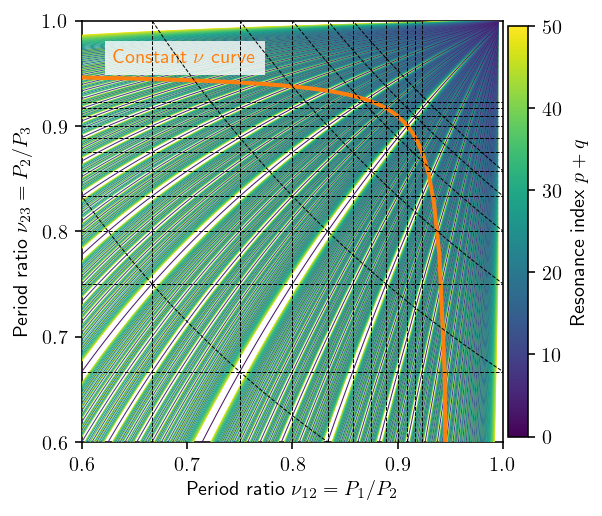

In [3]:
u=np.linspace(0.5,1,100)
pqmax = 50
fig,ax = plt.subplots(figsize=(4,4))
ax.set_aspect('equal', adjustable='box')
for pq in range(2,pqmax):
    for p in range(1,pq):
        if gcd(p,pq)==1:
            q=pq-p
            mask = ((1-p/q*(1/u-1))>0.3)&((1-p/q*(1/u-1))<1)
            ax.plot(u[mask],(1-p/q*(1/u-1))[mask],c=cm.viridis(pq/pqmax),lw=0.5,zorder=2*pqmax-pq)
for pq in range(1,pqmax):
    if pq < pqmax/4:
        ax.axhline(1-1/(pq+1),c='k',ls='--',lw=0.5,zorder = pqmax*3)
        ax.axvline(1-1/(pq+1),c='k',ls='--',lw=0.5,zorder = pqmax*3)
    if pq < pqmax/8:
        ax.plot(u,pq/(pq+1)/u,c='k',ls='--',lw=0.5,zorder = pqmax*3)

sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0, vmax=pqmax))
plt.colorbar(sm,fraction=0.046, pad=0.01,label=r'Resonance index $p+q$')
ax.set_xlim(0.6,1)
ax.set_ylim(0.6,1)
ax.set_yticks(np.linspace(0.6,1,5))

#Constant nu curve
nu = 0.05
nu23 = (1-u-nu)/(1-(1+nu)*u)

ax.plot(u[u<1/(1+nu)],nu23[u<1/(1+nu)],'tab:orange',lw=2,zorder=2*pqmax+1)
text = ax.text(0.63,0.96,r'Constant $\nu$ curve',color='tab:orange',zorder=2*pqmax+1,)
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
#ax.plot(u,1/u,'k',lw=2,zorder= pqmax*3)
ax.set_xlabel(r'Period ratio $\nu_{12} = P_1/P_2$')
ax.set_ylabel(r'Period ratio $\nu_{23} = P_2/P_3$')

fig.savefig('Figures/res0_loci.pdf',bbox_inches='tight')
fig.savefig('../Paper/Figures/res0_loci.pdf',bbox_inches='tight')

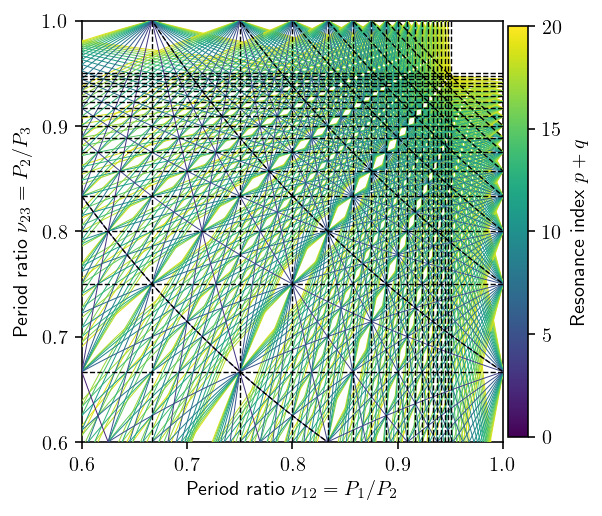

In [1834]:
u=np.linspace(0.5,1,100)
pqmax = 20
fig,ax = plt.subplots(figsize=(4,4))
ax.set_aspect('equal', adjustable='box')
for pq in range(2,pqmax):
    for p in range(1,pq):
        
        q=pq-p
        #mask = ((1-p/q*(1/u-1))>0.3)&((1-p/q*(1/u-1))<1)
        ax.plot(u,(1+(p+1)/q-p/q*1/u),c=cm.viridis(pq/pqmax),lw=0.5,zorder=2*pqmax-pq)
        ax.plot(u,(1+(p-1)/q-p/q*1/u),c=cm.viridis(pq/pqmax),lw=0.5,zorder=2*pqmax-pq)
        ax.plot(u,(1-(p+1)/q+p/q*1/u),c=cm.viridis(pq/pqmax),lw=0.5,zorder=2*pqmax-2*max(p,q))
for pq in range(1,pqmax):
    if pq < pqmax:
        ax.axhline(1-1/(pq+1),c='k',ls='--',lw=0.7,zorder = pqmax*3)
        ax.axvline(1-1/(pq+1),c='k',ls='--',lw=0.7,zorder = pqmax*3)
    if pq < pqmax/2:
        ax.plot(u,pq/(pq+1)/u,c='k',ls='--',lw=0.7,zorder = pqmax*3)

sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0, vmax=pqmax))
cb=plt.colorbar(sm,fraction=0.046, pad=0.01,label=r'Resonance index $p+q$')
cb.set_ticks(np.arange(0,pqmax+1,5))
ax.set_xlim(0.6,1)
ax.set_ylim(0.6,1)
ax.set_yticks(np.linspace(0.6,1,5))



#ax.plot(u,1/u,'k',lw=2,zorder= pqmax*3)
ax.set_xlabel(r'Period ratio $\nu_{12} = P_1/P_2$')
ax.set_ylabel(r'Period ratio $\nu_{23} = P_2/P_3$')

fig.savefig('Figures/res1_loci.pdf',bbox_inches='tight')
fig.savefig('../Paper/Figures/res01_loci.pdf',bbox_inches='tight')

In [4]:
import scipy.integrate as integrate

def diffusion_direction_curve(nu12,nu23,masses=np.ones(3)):
    'From an initial position and masses, computes the diffusion curve by solving the differential equation'
    solfor = integrate.solve_ivp(lambda t,y: diffusion_slope(t,y,masses=masses),
                                 (nu12,1),np.array([nu23]),events=eventnu23,max_step=0.01)
    solback = integrate.solve_ivp(lambda t,y: diffusion_slope(t,y,masses=masses),
                                  (nu12,0),np.array([nu23]),events=eventnu23,max_step=0.01)
    nu12s = np.concatenate((solback.t[:0:-1],solfor.t))
    nu23s = np.concatenate((solback.y[0][:0:-1],solfor.y[0]))
    return nu12s,nu23s
def eventnu23(nu12,nu23):
    return 1-nu23
eventnu23.terminal=True
    
def diffusion_slope(nu12,nu23,masses=np.ones(3)):
    return -nu23/nu12*(1-nu12*nu23+(1-nu12)*masses[0]/masses[1]*nu12**(-1/3))/(1-nu12*nu23+nu12*(1-nu23)*masses[2]/masses[1]*nu23**(1/3))

def integrate_gradeta(nu12,nu23,masses=np.ones(3)):
    solfor = integrate.solve_ivp(lambda t,y: gradeta_slope(t,y,masses=masses),
                                 (nu12,1),np.array([nu23]),events=eventnu23,max_step=0.01)
    solback = integrate.solve_ivp(lambda t,y: gradeta_slope(t,y,masses=masses),
                                  (nu12,0),np.array([nu23]),events=eventnu23,max_step=0.01)
    nu12s = np.concatenate((solback.t[:0:-1],solfor.t))
    nu23s = np.concatenate((solback.y[0][:0:-1],solfor.y[0]))
    return nu12s,nu23s

def gradeta_slope(nu12,nu23,masses=np.ones(3)):
    eta = nu12*(1-nu23)/(1-nu12*nu23)
    return -eta/(1-eta)*nu12**-2


In [7]:
def nus_to_eta(nu12,nu23):
    return nu12*(1-nu23)/(1-nu12*nu23)

In [10]:
def nus_to_nu_eta(nu12,nu23):
    return 1/(1/(1/nu12-1)+1/(1-nu23)),nu12*(1-nu23)/(1-nu12*nu23)
def nu_eta_to_nus(nu,eta):
    return eta/(eta+nu),(1-eta-nu)/(1-eta)



In [8]:
nu12diff,nu23diff = diffusion_direction_curve(0.8,0.8)
nu12greta,nu23greta = integrate_gradeta(0.8,0.8)

Text(0, 0.5, '$\\eta$')

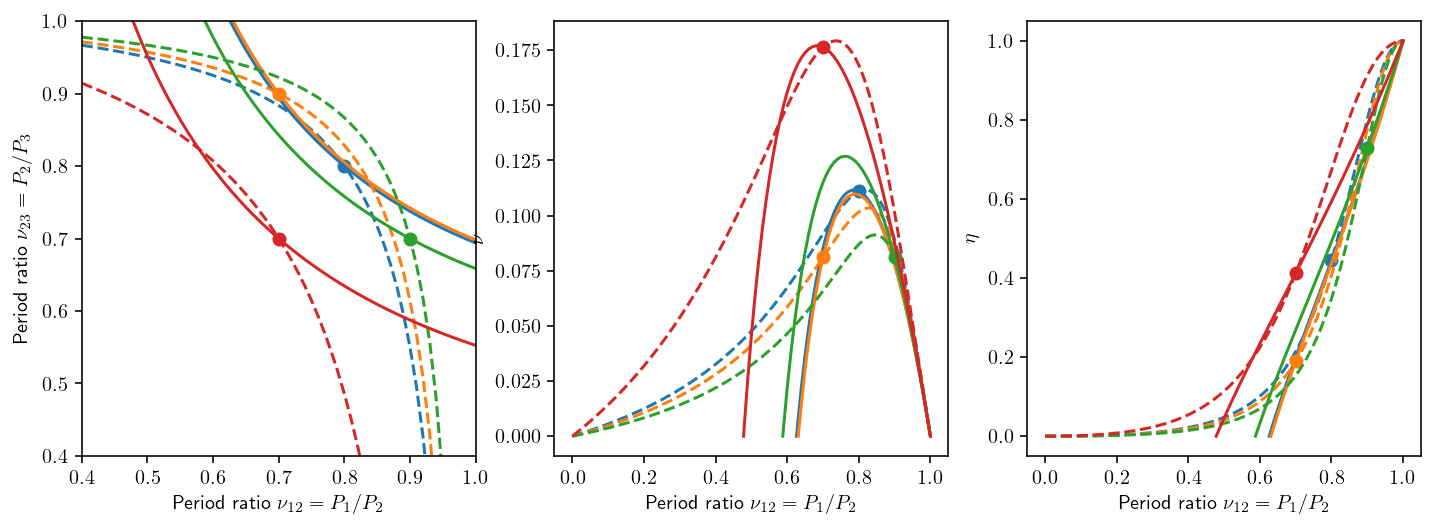

In [11]:
fig,axs = plt.subplots(1,3,figsize=(12,4))
for k,inicon in enumerate([(0.8,0.8),(0.7,0.9),(0.9,0.7),(0.7,0.7)]):
    
    nu12diff,nu23diff = diffusion_direction_curve(*inicon,np.array([0.1,1,1]))
    nu12greta,nu23greta = integrate_gradeta(*inicon)
    axs[0].plot(*inicon,c=cm.tab10(k),marker='o')
    axs[0].plot(nu12diff,nu23diff,c=cm.tab10(k))
    axs[0].plot(nu12greta,nu23greta,'--',c=cm.tab10(k))
    
    nudiff,etadiff = nus_to_nu_eta(nu12diff,nu23diff)
    nugreta,etagreta = nus_to_nu_eta(nu12greta,nu23greta)

    axs[1].plot(inicon[0],nus_to_nu_eta(*inicon)[0],c=cm.tab10(k),marker='o')
    axs[1].plot(nu12diff,nudiff,c=cm.tab10(k))
    axs[1].plot(nu12greta,nugreta,'--',c=cm.tab10(k))

    axs[2].plot(inicon[0],nus_to_nu_eta(*inicon)[1],c=cm.tab10(k),marker='o')
    axs[2].plot(nu12diff,etadiff,c=cm.tab10(k))
    axs[2].plot(nu12greta,etagreta,'--',c=cm.tab10(k))
axs[0].set_xlim(0.4,1)
axs[0].set_ylim(0.4,1)
for ax in axs:  ax.set_xlabel(r'Period ratio $\nu_{12} = P_1/P_2$')

axs[0].set_ylabel(r'Period ratio $\nu_{23} = P_2/P_3$')
axs[1].set_ylabel(r'$\nu$')
axs[2].set_ylabel(r'$\eta$')


In [232]:
nus_to_nu_eta(*inicon)[1]

0.411764705882353

### $\eta$ On edges of square of 1st MMR

In [1751]:
from sympy.abc import P,Q
synu12,synu23 = sy.symbols('\nu_{12},\nu_{23}')

In [1764]:
syeta = (1-synu23)/(1/synu12-synu23)
synu = syeta*(1/synu12-1)

In [1754]:
# Upper left
sy.simplify(syeta.replace(synu12,(P-1)/P).replace(synu23,Q/(Q+1)))

(P - 1)/(P + Q)

In [1765]:
# Upper left nu
sy.simplify(synu.replace(synu12,(P-1)/P).replace(synu23,Q/(Q+1)))

1/(P + Q)

In [1755]:
# Upper right
sy.simplify(syeta.replace(synu12,(P)/(P+1)).replace(synu23,Q/(Q+1)))

P/(P + Q + 1)

In [1766]:
# Upper right nu
sy.simplify(synu.replace(synu12,(P)/(P+1)).replace(synu23,Q/(Q+1)))

1/(P + Q + 1)

In [1756]:
# Lower left
sy.simplify(syeta.replace(synu12,(P-1)/P).replace(synu23,(Q-1)/(Q)))

(P - 1)/(P + Q - 1)

In [1767]:
# Lower left nu
sy.simplify(synu.replace(synu12,(P-1)/P).replace(synu23,(Q-1)/(Q)))

1/(P + Q - 1)

In [1761]:
# Lower right
sy.simplify(syeta.replace(synu12,(P)/(P+1)).replace(synu23,(Q-1)/(Q)))

P/(P + Q)

In [1768]:
# Lower right nu
sy.simplify(synu.replace(synu12,(P)/(P+1)).replace(synu23,(Q-1)/(Q)))

1/(P + Q)

In [1763]:
#Digaonal width:
sy.simplify(syeta.replace(synu12,(P)/(P+1)).replace(synu23,(Q-1)/(Q))-syeta.replace(synu12,(P-1)/P).replace(synu23,Q/(Q+1)))

1/(P + Q)

In [1770]:
#Horizontal width low:
sy.factor(syeta.replace(synu12,(P)/(P+1)).replace(synu23,(Q-1)/(Q))-syeta.replace(synu12,(P-1)/P).replace(synu23,(Q-1)/(Q)))

Q/((P + Q)*(P + Q - 1))

In [1771]:
#Horizontal width high:
sy.factor(syeta.replace(synu12,(P)/(P+1)).replace(synu23,(Q)/(Q+1))-syeta.replace(synu12,(P-1)/P).replace(synu23,(Q)/(Q+1)))

(Q + 1)/((P + Q)*(P + Q + 1))

In [1774]:
#Width nu other diag
sy.factor(synu.replace(synu12,(P-1)/P).replace(synu23,(Q-1)/(Q))-synu.replace(synu12,(P)/(P+1)).replace(synu23,Q/(Q+1)))

2/((P + Q - 1)*(P + Q + 1))

In [1776]:
#Width eta other diag
sy.factor(syeta.replace(synu12,(P)/(P+1)).replace(synu23,Q/(Q+1))-syeta.replace(synu12,(P-1)/P).replace(synu23,(Q-1)/(Q)))

-(P - Q - 1)/((P + Q - 1)*(P + Q + 1))

In [12]:
#Not convenient approx much better
def distance_eta_diffusion_direction_exact(nu12,nu23,masses=np.ones(3)):
    P = np.ceil(nu12/(1-nu12))
    Q = np.ceil(nu23/(1-nu23))
    eta0 = nu12*(1-nu23)/(1-nu12*nu23)
    def eventnu23do(nu12,nu23):
        return nu23-(Q-1)/Q
    def eventnu23up(nu12,nu23):
        return nu23-Q/(Q+1)
    eventnu23do.terminal=True
    eventnu23up.terminal=True
    
    'From an initial position and masses, computes the diffusion curve by solving the differential equation'
    solfor = integrate.solve_ivp(lambda t,y: diffusion_slope(t,y,masses=masses),
                                 (nu12,P/(P+1)),np.array([nu23]),events=eventnu23do)
    solback = integrate.solve_ivp(lambda t,y: diffusion_slope(t,y,masses=masses),
                                  (nu12,(P-1)/P),np.array([nu23]),events=eventnu23up)
    
    
    nu12s = np.array([solback.t[-1],solfor.t[-1]])
    nu23s = np.array([solback.y[0][-1],solfor.y[0][-1]])
    etas = nu12s*(1-nu23s)/(1-nu12s*nu23s)
    detas = np.min(abs(etas-eta0))
    forward = np.argmin(abs(etas-eta0))
    
    return detas,forward



In [15]:
#Don't use
#deta,forward = np.vectorize(distance_eta_diffusion_direction_exact)(Nu12_low,Nu23_low)

In [16]:
#Good even if approx
def distance_eta_diffusion_direction(nu12,nu23,masses=np.ones(3)):
    P = np.ceil(nu12/(1-nu12))
    Q = np.ceil(nu23/(1-nu23))
    eta0 = nus_to_eta(nu12,nu23)

    s0 = diffusion_slope(nu12,nu23,masses)

    # res up
    nu12up = (Q/(Q+1)-nu23)/s0+nu12
    # res down
    nu12do = (1-1/Q-nu23)/s0+nu12
    #res right
    nu23ri = nu23+s0*(P/(P+1)-nu12)
    #res left
    nu23le = nu23+s0*(1-1/P-nu12)

    nu12sma = np.maximum(nu12up,1-1/P)
    nu23sma = np.minimum(nu23le,Q/(Q+1))
    etasma = nus_to_eta(nu12sma,nu23sma)

    nu12lar = np.minimum(nu12do,(P)/(P+1))
    nu23lar = np.maximum(nu23ri,1-1/Q)
    etalar = nus_to_eta(nu12lar,nu23lar)

    deta = etalar-etasma

    return deta,(eta0-etasma)/(etalar-etasma)



In [18]:
Npts_low =200
nu12_low = np.linspace(0.6,1,Npts_low)[:-1]
nu23_low = nu12_low.copy()

Nu12_low,Nu23_low = np.meshgrid(nu12_low,nu23_low)

In [19]:
Eta_low = Nu12_low*(1-Nu23_low)/(1-Nu12_low*Nu23_low)
Nu_low = 1/(1/(1/Nu12_low-1)+1/(1-Nu23_low))


In [20]:
deta,y0 = distance_eta_diffusion_direction(Nu12_low,Nu23_low,masses=np.array([1,1,1]))

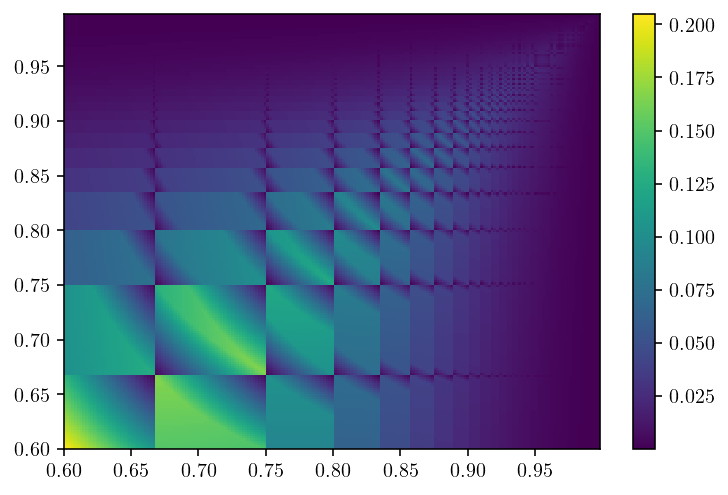

In [21]:
plt.pcolormesh(Nu12_low,Nu23_low,deta)
plt.colorbar()

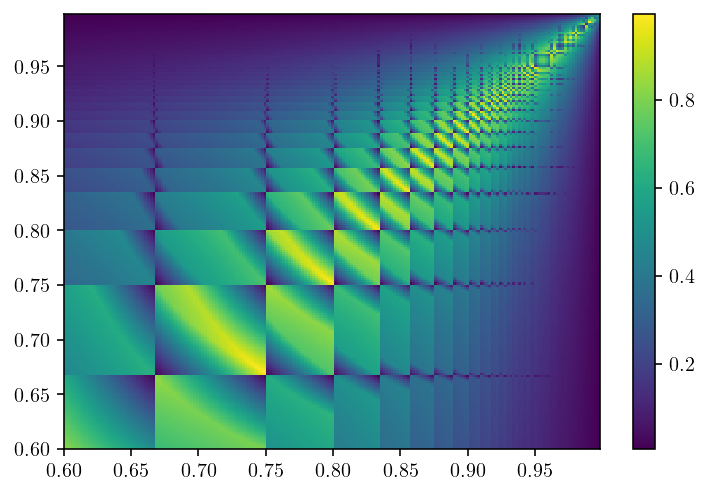

In [22]:
plt.pcolormesh(Nu12_low,Nu23_low,deta/Nu_low)
plt.colorbar()

In [23]:
np.mean(deta/Nu_low)

0.37938276896095907

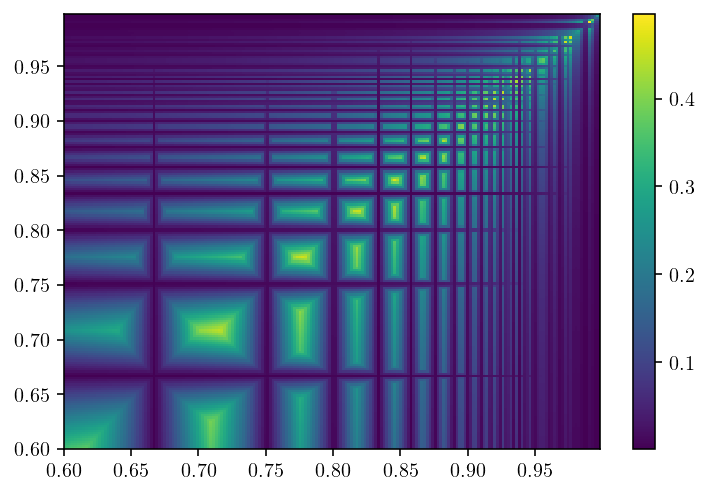

In [24]:
plt.pcolormesh(Nu12_low,Nu23_low,deta*np.minimum(y0,1-y0)/Nu_low)
plt.colorbar()

In [25]:
np.mean(deta*np.minimum(y0,1-y0)/Nu_low)

0.0962812919411095

In [26]:
np.std(deta*np.minimum(y0,1-y0)/Nu_low)

0.08611494618759898

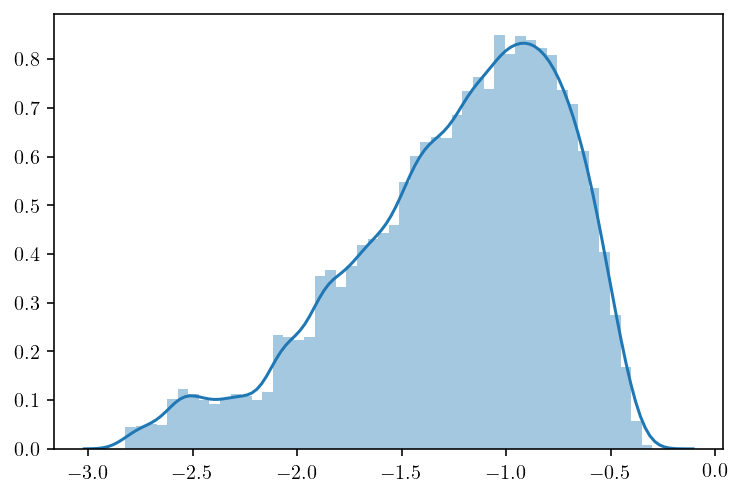

In [30]:
sns.distplot(np.log10(deta*np.minimum(y0,1-y0)/Nu_low))

In [34]:
np.max(deta/Nu_low)

0.998995733787673

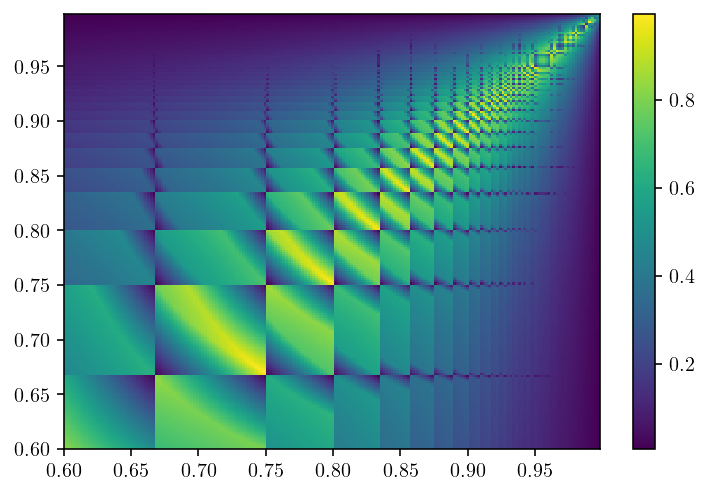

In [35]:
plt.pcolormesh(Nu12_low,Nu23_low,deta/Nu_low)
plt.colorbar()

# Overlap 

## Overlap on plane

In [992]:

def res_width_ex(Ps,PQ,Nu12_res,Nu23_res,masses,eccterm=False):
    """
    Compute the frequency of the Laplace resonance as a function of the masses and the period ratios
    nu12 = n2/n1
    nu23 = n3/n2
    nu23 is computed at the center as a function of nu12 p and q
    Eq. 40 used for Rpq
    """
    
    m1,m2,m3 = masses
    m0 = 1
    eta = Ps/PQ

    al12 = Nu12_res**(2/3)
    al23 = Nu23_res**(2/3)
    plsep = (1-al12)*(1-al23)/(2-al12-al23)
    
    K2red = 3*(1+m2/m1*eta**2/al12**2+(1-eta)**2*al23**2*m2/m3)#Reduced because most of the terms are not needed
    bp = bka(.5,al12,Ps)
    bq = bka(.5,al23,PQ-Ps)
    dbp = (0.5*(bka(1.5,al12,Ps+1)+bka(1.5,al12,Ps-1))-al12*bka(1.5,al12,Ps))
    dbq = (0.5*(bka(1.5,al23,PQ-Ps+1)+bka(1.5,al23,PQ-Ps-1))-al23*bka(1.5,al23,PQ-Ps))
    
    
    Rpq = m1*m3/m0**2*al23*(1/(1-Nu23_res)*bq*(bp+al12*dbp)+
                            al23/(Nu12_res**-1-1)*bp*dbq+
                            3*bp*bq/(2*(1-Nu23_res)*(1/Nu12_res-1))) #Same as K2
    
    if eccterm:
        Rext = 1/2*((2*Ps+1)*bp+al12*dbp)
        Rint = 1/2*(2*(PQ-Ps)*bq+al23*dbq)
        Nu = 1/(1/(1/Nu12_res-1)+1/(1-Nu23_res))
        Rpq += m1*m3/m0**2*al23*Rext*Rint*(1/(PQ*Nu-1))
    
    freq = np.sqrt(abs(Rpq)*K2red)


    res = np.nan_to_num(4*np.sqrt(2)/3*eta*(1-eta)/plsep*freq)
    return res

In [1423]:

def res_width_ex_fast(Ps,PQ,Nu12_res,Nu23_res,masses,eccterm=False):
    """
    Compute the frequency of the Laplace resonance as a function of the masses and the period ratios
    nu12 = n2/n1
    nu23 = n3/n2
    nu23 is computed at the center as a function of nu12 p and q
    Eq. 40 used for Rpq
    """
    
    m1,m2,m3 = masses
    m0 = 1
    eta = Ps/PQ
    Qs = PQ-Ps

    al12 = Nu12_res**(2/3)
    al23 = Nu23_res**(2/3)
    plsep = (1-al12)*(1-al23)/(2-al12-al23)
    
    K2red = 3*(1+m2/m1*eta**2/al12**2+(1-eta)**2*al23**2*m2/m3)#Reduced because most of the terms are not needed
    bp = 2*al12**Ps/(pi*Ps*(1-al12**2))**.5
    bq = 2*al23**Qs/(pi*Qs*(1-al23**2))**.5
    dbp = bp/al12*(Ps-1+1/(1-al12**2))
    dbq = bq/al23*(Qs-1+1/(1-al23**2))
    
    Nu = 1/(1/(Nu12_res**-1-1)+1/(1-Nu23_res))
    
    
    Rpq = m1*m3/m0**2*al23*(1/(1-Nu23_res)*bq*(bp+al12*dbp)+
                            al23/(Nu12_res**-1-1)*bp*dbq+
                            3*bp*bq/(2*(1-Nu23_res)*(1/Nu12_res-1))) #Same as K2
    
    if eccterm:
        Rext = 1/2*((2*Ps+1)*bp+al12*dbp)
        Rint = 1/2*(2*Qs*bq+al23*dbq)
        Nu = 1/(1/(1/Nu12_res-1)+1/(1-Nu23_res))
        Rpq += m1*m3/m0**2*al23*Rext*Rint*(1/(PQ*Nu-1))
    
    freq = np.sqrt(abs(Rpq)*K2red)


    res = np.nan_to_num(4*np.sqrt(2)/3*eta*(1-eta)/plsep*freq)
    return res

In [1370]:
def width_eta_useful_Quillen(Ps,PQ,Nu12_res,Nu23_res,masses,eccterm=False):
    """
    Compute the width of the Laplace resonance as a function of the masses and the period ratios
    
    Using the approximate version defined in  eq. 46
    nu12 = n2/n1
    nu23 = n3/n2
    nu23 is computed at the center as a function of nu12 p and q
    """

    eta = Ps/PQ
    m1,m2,m3 = masses
    m0 = 1

    al12 = Nu12_res**(2/3)
    al23 = Nu23_res**(2/3)
    plsep = (1-al12)*(1-al23)/(2-al12-al23)
    M = np.sqrt(m1*m3/m0**2*(1+m2/m1*eta**2/al12**2+(1-eta)**2*al23**2*m2/m3)) 

    Logpart = abs(np.log(plsep**2/(eta*(1-eta))))+abs(np.log(plsep/eta)*np.log(plsep/(1-eta)))
    if eccterm:
        Nu = 1/(1/(Nu12_res**-1-1)+1/(1-Nu23_res))
        Logpart += 1.5/(Nu-1/PQ)
        Logpart = abs(Logpart)
    #return 6/16/(PQ*Nu-1),abs(np.log(plsep**2/(eta*(1-eta))))+abs(np.log(plsep/eta)*np.log(plsep/(1-eta)))
    return np.nan_to_num(M*4/3*np.sqrt(Logpart)*(eta*(1-eta))**1.5/plsep**2*np.exp(-plsep*PQ))

In [1420]:
A = 4/3*np.sqrt(34/pi)

In [1422]:
((3/2)*(.25)**3)**(1/8)*A**.25

0.9052420622494571

In [1417]:
nus_to_nu_eta(nu12,nu12)

(array([0.000999  , 0.00129761, 0.00159605, 0.0018943 , 0.00219238,
        0.00249028, 0.002788  , 0.00308555, 0.00338291, 0.0036801 ,
        0.00397711, 0.00427395, 0.00457061, 0.00486709, 0.00516339,
        0.00545952, 0.00575547, 0.00605125, 0.00634685, 0.00664227,
        0.00693752, 0.00723259, 0.00752749, 0.00782221, 0.00811676,
        0.00841114, 0.00870533, 0.00899936, 0.00929321, 0.00958688,
        0.00988038, 0.01017371, 0.01046686, 0.01075984, 0.01105265,
        0.01134528, 0.01163774, 0.01193003, 0.01222214, 0.01251409,
        0.01280585, 0.01309745, 0.01338888, 0.01368013, 0.01397121,
        0.01426212, 0.01455285, 0.01484342, 0.01513381, 0.01542404,
        0.01571409, 0.01600397, 0.01629368, 0.01658322, 0.01687259,
        0.01716179, 0.01745082, 0.01773968, 0.01802837, 0.01831689,
        0.01860524, 0.01889342, 0.01918143, 0.01946928, 0.01975695,
        0.02004446, 0.02033179, 0.02061896, 0.02090596, 0.02119279,
        0.02147946, 0.02176595, 0.02205228, 0.02

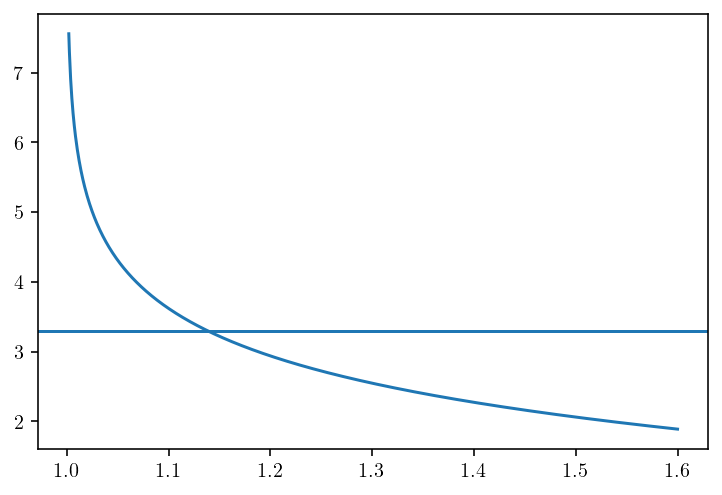

In [1418]:
nu,eta = nus_to_nu_eta(nu12,nu12)
plsep = 2/3*nu

plt.plot(1/nu12,np.sqrt(abs(np.log(plsep**2/(eta*(1-eta))))+abs(np.log(plsep/eta)*np.log(plsep/(1-eta)))))
plt.axhline(np.sqrt(34/pi))

In [1347]:
def width_eta_useful(Ps,PQ,Nu12_res,Nu23_res,masses):
    """
    Compute the width of the Laplace resonance as a function of the masses and the period ratios
    
    Using the approximate version defined in  eq. 46
    nu12 = n2/n1
    nu23 = n3/n2
    nu23 is computed at the center as a function of nu12 p and q
    """

    eta = Ps/PQ
    m1,m2,m3 = masses
    m0 = 1

    al12 = Nu12_res**(2/3)
    al23 = Nu23_res**(2/3)
    plsep = (1-al12)*(1-al23)/(2-al12-al23)
    M = np.sqrt(m1*m3/m0**2*(1+m2/m1*eta**2/al12**2+(1-eta)**2*al23**2*m2/m3)) 

    Logpart = 1/al12*abs(np.log(plsep/eta)*np.log(plsep/(1-eta)))

    return np.nan_to_num(M*4/3*np.sqrt(17*Logpart)*(eta*(1-eta))**1.25/plsep**1.5*al12**(Ps/2)*al23**((PQ-Ps)/2))#*np.exp(-plsep*PQ))

In [1247]:
def width_eta_useful_full(Ps,PQ,Nu12_res,Nu23_res,masses,pqterms=1):
    """
    Compute the width of the Laplace resonance as a function of the masses and the period ratios
    
    Using the approximate version defined in  eq. 46
    nu12 = n2/n1
    nu23 = n3/n2
    nu23 is computed at the center as a function of nu12 p and q
    """

    eta = Ps/PQ
    m1,m2,m3 = masses
    m0 = 1

    al12 = Nu12_res**(2/3)
    al23 = Nu23_res**(2/3)
    
    
    plsep = (1-al12)*(1-al23)/(2-al12-al23)
    M = np.sqrt(m1*m3*al23/m0**2*(1+m2/m1*eta**2/al12**2+(1-eta)**2*al23**2*m2/m3))  #m1*m3*al23/m0**2 comes from Rpq
    
    Nu = 1/(1/(Nu12_res**-1-1)+1/(1-Nu23_res))
    
    
    d12 = 1-al12
    d23 = 1-al23
    
    Logpart = (pqterms*(-np.log(d12)/al12-np.log(d23)/al23+np.log(d12)*np.log(d23)/al12/al23)/(PQ*plsep)
               +2*np.log(d12)*np.log(d23)/al12/al23)
    Logpart += Nu/(Nu-1/PQ)*(pqterms*(-.75*np.log(d12)/al12-.75*np.log(d23)/al23+.5*np.log(d12)*np.log(d23)/al12/al23)/(PQ*plsep)
                             +pqterms*.25/plsep**2/PQ**2
                             +9/4*np.log(d12)*np.log(d23)/al12/al23)
   

    Logpart = abs(Logpart)
    #return 6/16/(PQ*Nu-1),abs(np.log(plsep**2/(eta*(1-eta))))+abs(np.log(plsep/eta)*np.log(plsep/(1-eta)))
    return np.nan_to_num(M*8/3*np.sqrt(Logpart)*(eta*(1-eta))**1.25/plsep**1.5)*al12**(Ps/2)*al23**((PQ-Ps)/2)#*np.exp(-plsep*PQ)

In [32]:
Npts =2000
nu12 = np.linspace(0.6,1,Npts)[:-1]
nu23 = nu12.copy()

Nu12,Nu23 = np.meshgrid(nu12,nu23)

In [33]:
Eta = Nu12*(1-Nu23)/(1-Nu12*Nu23)
Nu = 1/(1/(1/Nu12-1)+1/(1-Nu23))


In [34]:
from IPython.display import clear_output

In [35]:
Overlap = np.zeros_like(Nu12)


In [1426]:
Overlap_ex = np.zeros_like(Nu12)

In [1065]:
Overlap_ex1e5 = np.zeros_like(Nu12)

In [1432]:
for k in range(2,200): #Indexes starts at 2
    
    Ps = np.rint(k*Eta)
    Ps0 = Ps.copy()
    Ps += Ps==0
    Ps -= Ps==k
    Eta0 = Ps/k
    Dist = Eta-Eta0
    Qs = k-Ps
    
    #Find loci
    Nu12_res = Nu12.copy()
    Nu23_res = Nu23.copy()
    if np.max(abs(Dist))>0.01:
        j=0

        dEta = Nu12_res*(1-Nu23_res)/(1-Nu12_res*Nu23_res)-Eta0
        while (j<10) and (np.max(abs(dEta[(Ps0>0)&(Ps0<k)]))>1e-3):
            
            print('Gradient :',k,j)
            j+=1
            dEta = Nu12_res*(1-Nu23_res)/(1-Nu12_res*Nu23_res)-Eta0

            GrEta1 = (1-Nu23_res)/(1-Nu12_res*Nu23_res)**2
            GrEta2 = -Nu12_res*(1-Nu12_res)/(1-Nu12_res*Nu23_res)**2

            Nu12_res -= 0.5*dEta/GrEta1 #Unstable without the 0.5
            Nu23_res -= 0.5*dEta/GrEta2
    clear_output(wait=True)
    print('Width :',k)
    Widths = res_width_ex_fast(Ps,k,Nu12_res,Nu23_res,1e-4*np.ones(3),eccterm=True)/2

    Overlap_ex += abs(Dist)<Widths

Width : 199


In [1437]:
for k in range(2,200): #Indexes starts at 2
    
    Ps = np.rint(k*Eta)
    Ps0 = Ps.copy()
    Ps += Ps==0
    Ps -= Ps==k
    Eta0 = Ps/k
    Dist = Eta-Eta0
    Qs = k-Ps
    
    #Find loci
    Nu12_res = Nu12.copy()
    Nu23_res = Nu23.copy()
    if np.max(abs(Dist))>0.01:
        j=0

        dEta = Nu12_res*(1-Nu23_res)/(1-Nu12_res*Nu23_res)-Eta0
        while (j<10) and (np.max(abs(dEta[(Ps0>0)&(Ps0<k)]))>1e-3):
            
            print('Gradient :',k,j)
            j+=1
            dEta = Nu12_res*(1-Nu23_res)/(1-Nu12_res*Nu23_res)-Eta0

            GrEta1 = (1-Nu23_res)/(1-Nu12_res*Nu23_res)**2
            GrEta2 = -Nu12_res*(1-Nu12_res)/(1-Nu12_res*Nu23_res)**2

            Nu12_res -= 0.5*dEta/GrEta1 #Unstable without the 0.5
            Nu23_res -= 0.5*dEta/GrEta2
    clear_output(wait=True)
    print('Width :',k)
    Widths = res_width_ex_fast(Ps,k,Nu12_res,Nu23_res,1e-5*np.ones(3),eccterm=True)/2

    Overlap_ex1e5 += abs(Dist)<Widths

Width : 199


In [44]:
Overlap = np.zeros_like(Nu12)
for k in range(2,200): #Indexes starts at 2
    clear_output(wait=True)
    Ps = np.rint(k*Eta)
    Ps0 = Ps.copy()
    Ps += Ps==0
    Ps -= Ps==k
    Eta0 = Ps/k
    Dist = Eta-Eta0
    Qs = k-Ps
    
    #Find loci
    Nu12_res = Nu12.copy()
    Nu23_res = Nu23.copy()
    if np.max(abs(Dist))>0.01:
        j=0

        dEta = Nu12_res*(1-Nu23_res)/(1-Nu12_res*Nu23_res)-Eta0
        while (j<10) and (np.max(abs(dEta[(Ps0>0)&(Ps0<k)]))>1e-3):
            
            print('Gradient :',k,j)
            j+=1
            dEta = Nu12_res*(1-Nu23_res)/(1-Nu12_res*Nu23_res)-Eta0

            GrEta1 = (1-Nu23_res)/(1-Nu12_res*Nu23_res)**2
            GrEta2 = -Nu12_res*(1-Nu12_res)/(1-Nu12_res*Nu23_res)**2

            Nu12_res -= 0.5*dEta/GrEta1 #Unstable without the 0.5
            Nu23_res -= 0.5*dEta/GrEta2
    
    print('Width')
    Widths = width_eta_useful(Ps,k,Nu12_res,Nu23_res,1e-4*np.ones(3))/2

    Overlap += abs(Dist)<Widths

Width


In [1406]:

def _overlap(k,eta,plsep,masses):
    d12 = plsep*eta
    nu12 = (1-d12)**1.5
    return k*res_width_ex(k*eta,k,nu12,1-eta/(1-eta)*(1/nu12-1),masses,eccterm=True)
def _overlap_fast(k,eta,plsep,masses):
    d12 = plsep*eta
    nu12 = (1-d12)**1.5
    return k*res_width_ex_fast(k*eta,k,nu12,1-eta/(1-eta)*(1/nu12-1),masses,eccterm=True)

def _overlap_Quillen(k,eta,plsep,masses):
    d12 = plsep*eta
    nu12 = (1-d12)**1.5
    return k*width_eta_useful_Quillen(k*eta,k,nu12,1-eta/(1-eta)*(1/nu12-1),masses,eccterm=False)



In [1393]:
eta= 0.5
plsep = np.linspace(0.01,0.3,200)
masses=1e-5*np.ones(3)
density = np.array([[integrate.quad(_overlap,2,300,args=(eta,psep,masses)) for psep in plsep] for eta in [0.1,0.2,0.3,0.4,0.5]])

In [1376]:
densityQuillen = np.array([[integrate.quad(_overlap_Quillen,0,np.infty,args=(eta,psep,masses)) for psep in plsep] for eta in [0.1,0.2,0.3,0.4,0.5]])

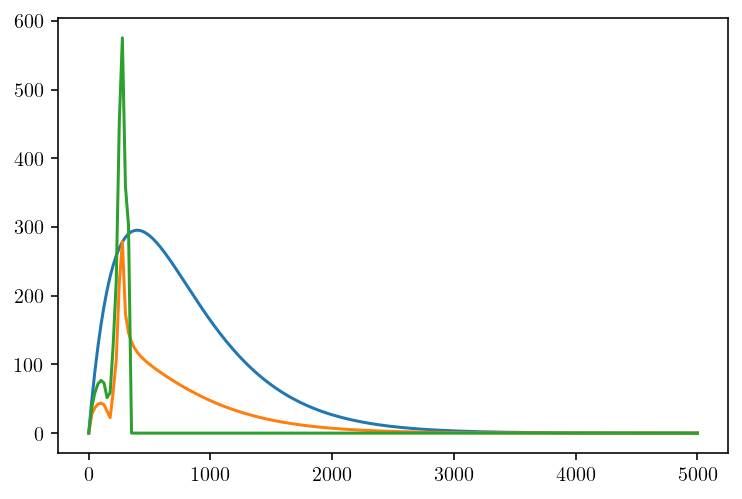

In [1409]:
pqs = np.linspace(0,5000,200)
plt.plot(pqs,_overlap_Quillen(pqs,eta,0.01,masses))
plt.plot(pqs,_overlap_fast(pqs,eta,0.01,masses))
plt.plot(pqs,_overlap(pqs,eta,0.01,masses))

NameError: name 'ps' is not defined

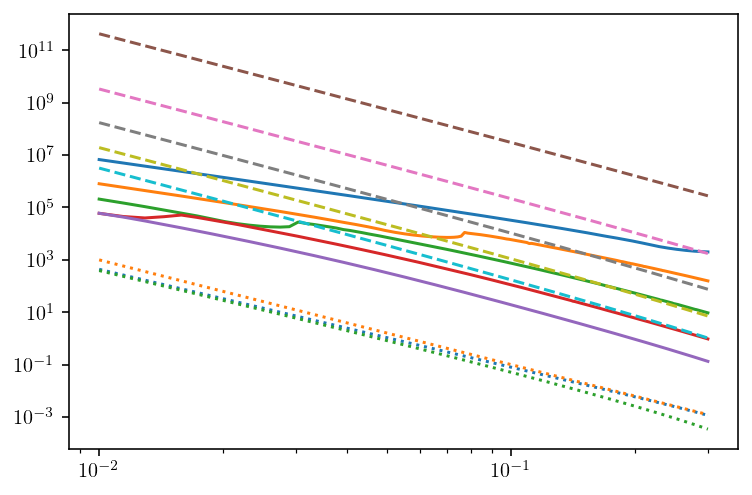

In [1398]:
plt.loglog(plsep,density[:,:,0].T)
plt.loglog(plsep,densityQuillen[:,:,0].T,'--')
plt.plot(plsep,fillingfactor_th(3/2*plsep,eta,masses,d4=False)+1,':')
plt.plot(plsep,1e-5*plsep**-4,':')
plt.plot(plsep,-1e-5*plsep**-3.5*np.log(plsep/eta),':')

(0.1, 2)

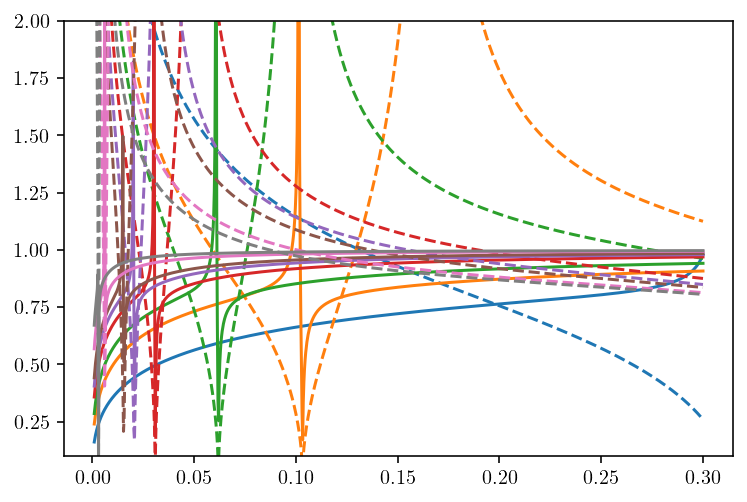

In [1424]:
masses = 1e-6*np.ones(3)
#plt.axvline(nu_eta_to_nus(3/2*get_plsep_ov(0.7,0.7,masses),0.5)[0],ls='--',c='k')
for k,pq in enumerate([2,6,10,20,30,40,100,200]):

    p=pq//2
    q=pq-p
    nu = nus_to_nu_eta(nu12,1-p/q*(1/nu12-1))[0]
    al23 = (1-p/q*(1/nu12-1))**(2/3)
    plt.plot(nu,res_width_ex(p,p+q,nu12,1-p/q*(1/nu12-1),masses,eccterm=True)/res_width_ex_fast(p,p+q,nu12,1-p/q*(1/nu12-1),masses,eccterm=True),c=cm.tab10(k))
    plt.plot(nu,res_width_ex(p,p+q,nu12,1-p/q*(1/nu12-1),masses,eccterm=True)/width_eta_useful(p,p+q,nu12,1-p/q*(1/nu12-1),masses),'--',c=cm.tab10(k))
#plt.yscale('log')
#plt.xscale('log')
plt.ylim(.1,2)

(0.1, 2)

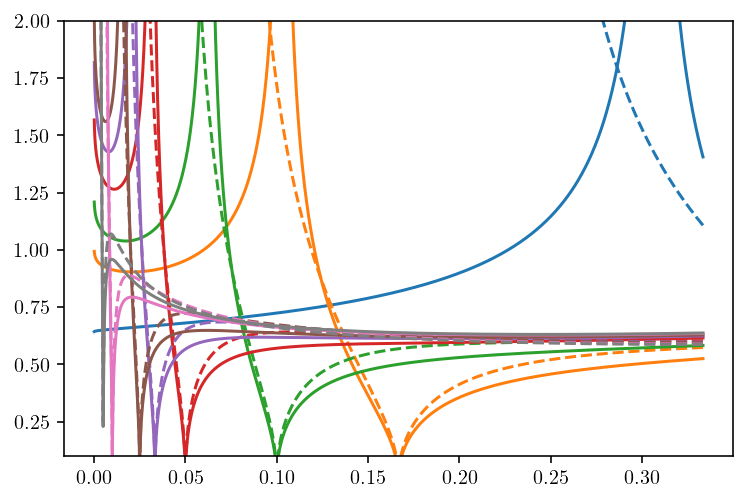

In [1254]:
masses = 1e-6*np.ones(3)
#plt.axvline(nu_eta_to_nus(3/2*get_plsep_ov(0.7,0.7,masses),0.5)[0],ls='--',c='k')
for k,pq in enumerate([2,6,10,20,30,40,100,200]):

    p=pq//2
    q=pq-p
    nu = nus_to_nu_eta(nu12,1-p/q*(1/nu12-1))[0]
    al23 = (1-p/q*(1/nu12-1))**(2/3)
    plt.plot(nu,res_width_ex(p,p+q,nu12,1-p/q*(1/nu12-1),masses,eccterm=False)/res_width_ex_fast(p,p+q,nu12,1-p/q*(1/nu12-1),masses,eccterm=True),c=cm.tab10(k))
    plt.plot(nu,1/al23**.5*res_width_ex(p,p+q,nu12,1-p/q*(1/nu12-1),masses,eccterm=False)/width_eta_useful_full(p,p+q,nu12,1-p/q*(1/nu12-1),masses,pqterms=0),'--',c=cm.tab10(k))
#plt.yscale('log')
#plt.xscale('log')
plt.ylim(.1,2)

(0.1, 3)

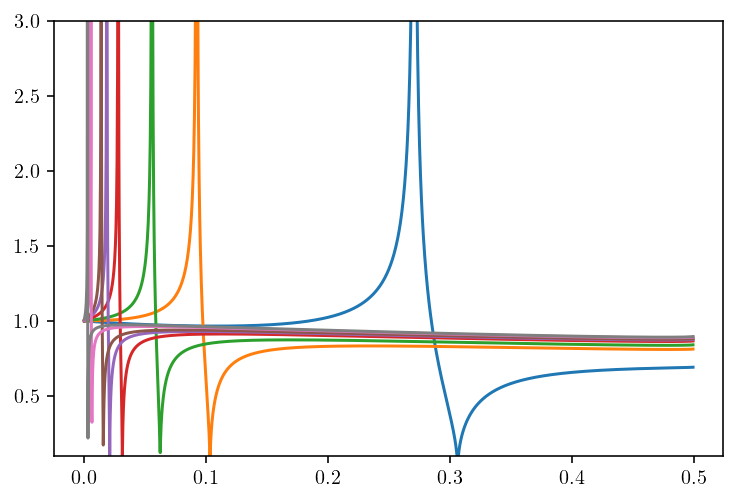

In [1228]:
masses = 1e-6*np.ones(3)
#plt.axvline(nu_eta_to_nus(3/2*get_plsep_ov(0.7,0.7,masses),0.5)[0],ls='--',c='k')
for k,pq in enumerate([2,6,10,20,30,40,100,200]):

    p=pq//2
    q=pq-p
    nu = nus_to_nu_eta(nu12**2,1-p/q*(1/nu12**2-1))[0]
    al23 = (1-p/q*(1/nu12**2-1))**(2/3)
    plt.plot(nu,1/al23**.5*res_width_ex_fast(p,p+q,nu12**2,1-p/q*(1/nu12**2-1),masses,eccterm=True)/width_eta_useful_full(p,p+q,nu12**2,1-p/q*(1/nu12**2-1),masses,pqterms=1),
             c=cm.tab10(k))
#plt.yscale('log')
#plt.xscale('log')
plt.ylim(.1,3)

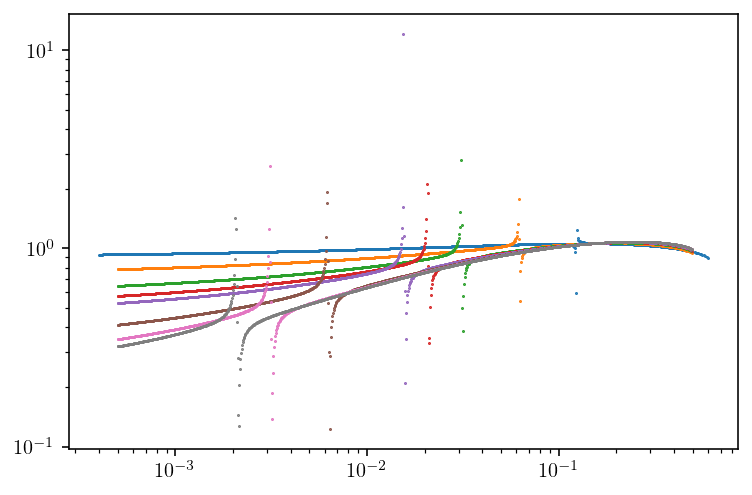

In [1153]:
masses = 1e-6*np.ones(3)
_nu12 = 1-np.logspace(-3,-.1,1000)
#plt.axvline(nu_eta_to_nus(3/2*get_plsep_ov(0.7,0.7,masses),0.5)[0],ls='--',c='k')
for k,pq in enumerate([5,10,20,30,40,100,200,300]):

    p=pq//2
    q=pq-p
    nu = nus_to_nu_eta(_nu12,1-p/q*(1/_nu12-1))[0]
    #plt.axvline(1/pq,c=cm.tab10(k))
    plt.loglog(nu,res_width_ex_fast(p,p+q,_nu12,1-p/q*(1/_nu12-1),masses,eccterm=True)/res_width_ex(p,p+q,_nu12,1-p/q*(1/_nu12-1),masses,eccterm=True),'.',c=cm.tab10(k),ms=1)
    #plt.plot(nu,res_width_ex(p,p+q,nu12,1-p/q*(1/nu12-1),masses,eccterm=False)/width_eta_useful_full(p,p+q,nu12,1-p/q*(1/nu12-1),masses,pqterms=0),'--',c=cm.tab10(k))
plt.yscale('log')
#plt.ylim(1e-1,3)

(1, 3)

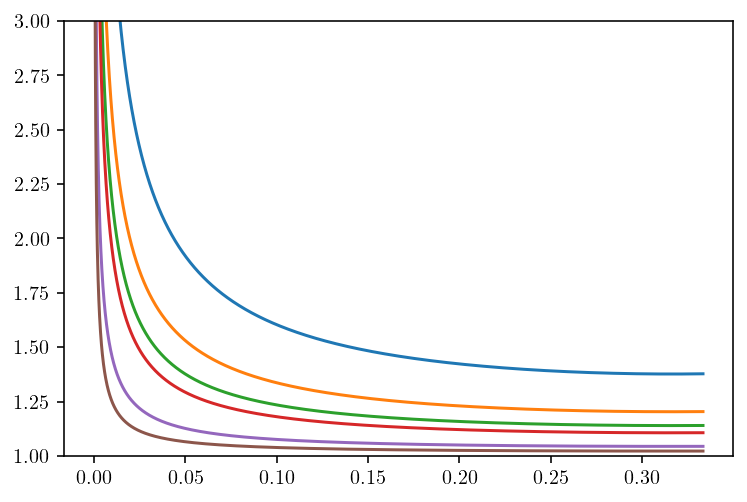

In [1030]:
masses = 1e-6*np.ones(3)
#plt.axvline(nu_eta_to_nus(3/2*get_plsep_ov(0.7,0.7,masses),0.5)[0],ls='--',c='k')
for k,pq in enumerate([10,20,30,40,100,200]):

    p=pq//2
    q=pq-p
    nu = nus_to_nu_eta(nu12,1-p/q*(1/nu12-1))[0]
    plt.plot(nu,width_eta_useful_full(p,p+q,nu12,1-p/q*(1/nu12-1),masses,pqterms=1)/width_eta_useful_full(p,p+q,nu12,1-p/q*(1/nu12-1),masses,pqterms=0),c=cm.tab10(k))
    #plt.plot(nu,res_width_ex(p,p+q,nu12,1-p/q*(1/nu12-1),masses,eccterm=False)/width_eta_useful_full(p,p+q,nu12,1-p/q*(1/nu12-1),masses,pqterms=0),'--',c=cm.tab10(k))
#plt.yscale('log')
plt.ylim(1,3)

In [988]:
bq.shape

(1999, 1999)

In [1425]:
Al12 = Nu12**(2/3)
Al23 = Nu23**(2/3)
m1,m2,m3 = 1e-4*np.ones(3)
m0=1
Plsep = (1-Al12)*(1-Al23)/(2-Al12-Al23)

Mfac = (m1*m3/m0**2*np.sqrt(Eta**2/Al12**2+1+(1-Eta)**2*Al23**2))**.5
Logpart = abs(np.log(Plsep**2/(Eta*(1-Eta))))+abs(np.log(Plsep/Eta)*np.log(Plsep/(1-Eta)))

Overlap_th = Mfac*Logpart**.5*4/3*(Eta*(1-Eta))**1.5/Plsep**4



In [1601]:
masses = 1e-4*np.ones(3)
def fillingfactor_th(nu,eta,masses):
    m1,m2,m3 = masses
    m0=1
    nu12,nu23=nu_eta_to_nus(nu,eta)
    plsep = 1/(1/(1-nu12**(2/3))+1/(1-nu23**(2/3)))
    Mfac = (m1*m3/m0**2*(eta**2/nu12**(4/3)+1+(1-eta)**2*nu23**(4/3)))**.5

    return np.nan_to_num(Mfac*(38/pi)**.5*4*2**.5/3*(eta*(1-eta))**1.5/plsep**4-1)

In [1503]:
nus = np.linspace(0.001,0.3,1000)
eta=0.5

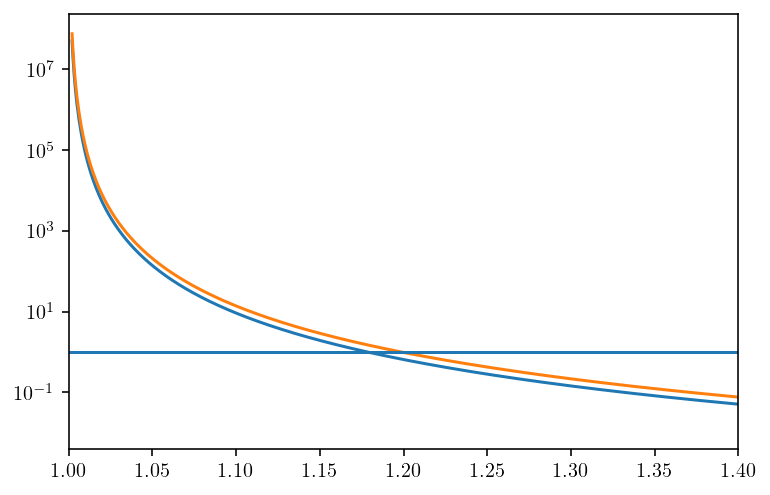

In [1610]:
nu12,nu23=nu_eta_to_nus(nus,eta)
#plt.plot(1/nu12,(fillingfactor_th(nus,eta,masses,d4=False)+1)/(fillingfactor_th(nus,eta,masses,d4=True)+1))
plt.semilogy(1/nu12,fillingfactor_th(nus,eta,1e-5*np.ones(3))+1)
plt.semilogy(1/nu12,1.5*(fillingfactor_th(nus,eta,1e-5*np.ones(3),)+1))
plt.xlim(1,1.4)
plt.axhline(1)

In [47]:
import scipy.optimize as optimize

In [1125]:
nu23ov = nu23.copy()
nu12guess = 1-1.5/(1/0.05-1/(1-nu23ov**(2/3)))

nu12ov = optimize.fsolve(fillingfactor_th,nu12guess,args=(nu23ov,masses))

SyntaxError: invalid syntax (<ipython-input-1125-445041d8a0c3>, line 4)

In [1133]:
etas = np.linspace(0,1,1000)
nuguess = 0.05*np.ones_like(etas)

nuov = optimize.fsolve(fillingfactor_th,nuguess,args=(etas,0.1*masses))
nu12ov,nu23ov = nu_eta_to_nus(nuov,etas)

Text(0, 0.5, 'Period ratio $\\nu_{23} = P_2/P_3$')

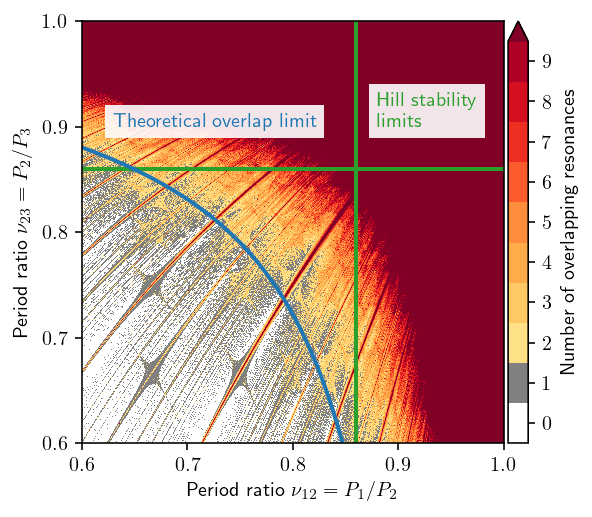

In [1451]:
fig,ax = plt.subplots(figsize=(4,4))
ax.set_aspect('equal', adjustable='box')

boundaries = np.linspace(-.5, 9.5,11)
cmap_reds = plt.cm.get_cmap('YlOrRd',len(boundaries))
colors = list(cmap_reds(np.arange(len(boundaries))))
#replace first color with white
colors[0] = "white"
colors[1] = 'grey'
cmap = matplotlib.colors.ListedColormap(colors[:-1], "")
# set over-color to last color of list 
cmap.set_over(colors[-1])

pcm =plt.pcolormesh(Nu12,Nu23,Overlap_ex,
    cmap=cmap,rasterized=True,
    norm = matplotlib.colors.BoundaryNorm(boundaries, ncolors=len(boundaries)-1, clip=False)
)
cb = plt.colorbar(pcm, extend="max",fraction=0.045, pad=0.01)
cb.set_ticks(np.arange(10))
cb.set_label('Number of overlapping resonances')
ax.set_xlim(0.6,1)
ax.set_ylim(0.6,1)
ax.set_yticks(np.linspace(0.6,1,5))



Rh = (2e-4/3)**(1/3)
plt.axhline(1-3.46*Rh,lw=2,c='tab:green')
plt.axvline(1-3.46*Rh,lw=2,c='tab:green')
text = ax.text(0.88,0.9,'Hill stability\n limits',color='tab:green',zorder=2*pqmax+1,)
text.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='none'))

etas = np.linspace(0,1,1000)
nuguess = 0.05*np.ones_like(etas)
nuov = optimize.fsolve(fillingfactor_th,nuguess,args=(etas,1e-4*np.ones(3)))
nu12ov,nu23ov = nu_eta_to_nus(nuov,etas)
ax.plot(nu12ov,nu23ov,lw=2)

text = ax.text(0.63,0.9,'Theoretical overlap limit',color='tab:blue',zorder=2*pqmax+1,)
text.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='none'))

ax.set_xlabel(r'Period ratio $\nu_{12} = P_1/P_2$')
ax.set_ylabel(r'Period ratio $\nu_{23} = P_2/P_3$')
#fig.savefig('Figures/overlap1e4.pdf',bbox_inches='tight')
#fig.savefig('../Paper/Figures/overlap1e4.pdf',bbox_inches='tight')

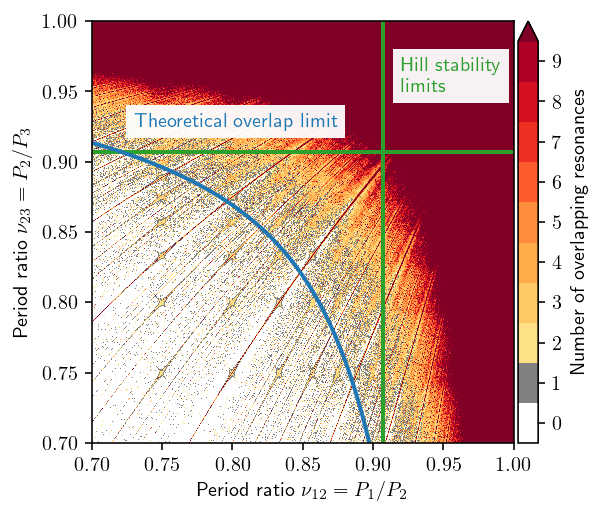

In [1613]:
fig,ax = plt.subplots(figsize=(4,4))
ax.set_aspect('equal', adjustable='box')

boundaries = np.linspace(-.5, 9.5,11)
cmap_reds = plt.cm.get_cmap('YlOrRd',len(boundaries))
colors = list(cmap_reds(np.arange(len(boundaries))))
#replace first color with white
colors[0] = "white"
colors[1] = 'grey'
cmap = matplotlib.colors.ListedColormap(colors[:-1], "")
# set over-color to last color of list 
cmap.set_over(colors[-1])

pcm =plt.pcolormesh(Nu12,Nu23,Overlap_ex1e5,#ndimage.filters.gaussian_filter(Overlap_ex1e5,sigma=5),
    cmap=cmap,rasterized=True,
    norm = matplotlib.colors.BoundaryNorm(boundaries, ncolors=len(boundaries)-1, clip=False)
)
cb = plt.colorbar(pcm, extend="max",fraction=0.045, pad=0.01)
cb.set_ticks(np.arange(10))
cb.set_label('Number of overlapping resonances')
ax.set_xlim(0.7,1)
ax.set_ylim(0.7,1)
#ax.set_yticks(np.linspace(0.6,1,5))



Rh = (2e-5/3)**(1/3)
plt.axhline((amdcrit.hill_circular_spacing(2e-5))**1.5,lw=2,c='tab:green')
plt.axvline((amdcrit.hill_circular_spacing(2e-5))**1.5,lw=2,c='tab:green')

#plt.axhline((1-1.46*(2e-5)**(2/7))**1.5,lw=2,c='tab:orange')
#plt.axvline((1-1.46*(2e-5)**(2/7))**1.5,lw=2,c='tab:orange')
text = ax.text(0.92,0.95,'Hill stability\n limits',color='tab:green',zorder=2*pqmax+1,)
text.set_bbox(dict(facecolor='white', alpha=0.95, edgecolor='none'))

etas = np.linspace(0,1,1000)
nuguess = 0.05*np.ones_like(etas)
nuov = optimize.fsolve(fillingfactor_th,nuguess,args=(etas,1e-5*np.ones(3)))
nu12ov,nu23ov = nu_eta_to_nus(nuov,etas)
sl = (nu12ov<1)&(nu23ov<1)
ax.plot(nu12ov[sl],nu23ov[sl],lw=2)

text = ax.text(0.73,0.925,'Theoretical overlap limit',color='tab:blue',zorder=2*pqmax+1,)
text.set_bbox(dict(facecolor='white', alpha=0.95, edgecolor='none'))

ax.set_xlabel(r'Period ratio $\nu_{12} = P_1/P_2$')
ax.set_ylabel(r'Period ratio $\nu_{23} = P_2/P_3$')
#fig.savefig('Figures/overlap1e4.pdf',bbox_inches='tight')
fig.savefig('../Paper/Figures/overlap1e5ex.pdf',bbox_inches='tight',dpi=400)

In [1449]:
ndimage.filters.gaussian_filter(Overlap_ex1e5,sigma=100)

array([[2.37850832e-02, 2.37855644e-02, 2.37864949e-02, ...,
        8.02385298e+01, 8.02506744e+01, 8.02567475e+01],
       [2.37847280e-02, 2.37852093e-02, 2.37861399e-02, ...,
        8.02390398e+01, 8.02511845e+01, 8.02572576e+01],
       [2.37840412e-02, 2.37845226e-02, 2.37854534e-02, ...,
        8.02400598e+01, 8.02522046e+01, 8.02582777e+01],
       ...,
       [6.00470918e+01, 6.00477028e+01, 6.00489248e+01, ...,
        3.85290946e+02, 3.85294337e+02, 3.85296033e+02],
       [6.00558900e+01, 6.00565010e+01, 6.00577231e+01, ...,
        3.85294287e+02, 3.85297678e+02, 3.85299373e+02],
       [6.00602896e+01, 6.00609007e+01, 6.00621229e+01, ...,
        3.85295958e+02, 3.85299349e+02, 3.85301044e+02]])

Text(0, 0.5, 'Period ratio $\\nu_{23} = P_2/P_3$')

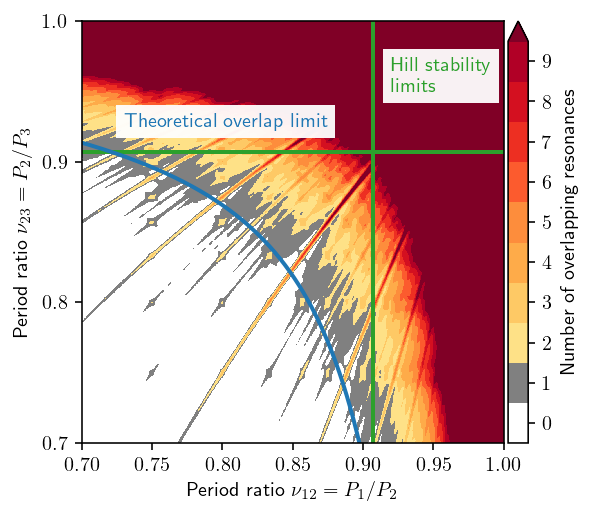

In [1727]:
fig,ax = plt.subplots(figsize=(4,4))
ax.set_aspect('equal', adjustable='box')

boundaries = np.linspace(-.5, 9.5,11)
cmap_reds = plt.cm.get_cmap('YlOrRd',len(boundaries))
colors = list(cmap_reds(np.arange(len(boundaries))))
#replace first color with white
colors[0] = "white"
colors[1] = 'grey'
cmap = matplotlib.colors.ListedColormap(colors[:-1], "")
# set over-color to last color of list 
cmap.set_over(colors[-1])

pcm =plt.pcolormesh(Nu12,Nu23,ndimage.filters.gaussian_filter(Overlap_ex1e5,sigma=5)-.5,
    cmap=cmap,rasterized=True,
    norm = matplotlib.colors.BoundaryNorm(boundaries, ncolors=len(boundaries)-1, clip=False)
)
cb = plt.colorbar(pcm, extend="max",fraction=0.045, pad=0.01)
cb.set_ticks(np.arange(10))
cb.set_label('Number of overlapping resonances')
ax.set_xlim(0.7,1)
ax.set_ylim(0.7,1)
ax.set_yticks(np.linspace(0.7,1,4))

Rh = (2e-5/3)**(1/3)
plt.axhline((amdcrit.hill_circular_spacing(2e-5))**1.5,lw=2,c='tab:green')
plt.axvline((amdcrit.hill_circular_spacing(2e-5))**1.5,lw=2,c='tab:green')

#plt.axhline((1-1.46*(2e-5)**(2/7))**1.5,lw=2,c='tab:orange')
#plt.axvline((1-1.46*(2e-5)**(2/7))**1.5,lw=2,c='tab:orange')
text = ax.text(0.92,0.95,'Hill stability\n limits',color='tab:green',zorder=2*pqmax+1,)
text.set_bbox(dict(facecolor='white', alpha=0.95, edgecolor='none'))

etas = np.linspace(0,1,1000)
nuguess = 0.05*np.ones_like(etas)
nuov = optimize.fsolve(fillingfactor_th,nuguess,args=(etas,1e-5*np.ones(3)))
nu12ov,nu23ov = nu_eta_to_nus(nuov,etas)
sl = (nu12ov<1)&(nu23ov<1)
ax.plot(nu12ov[sl],nu23ov[sl],lw=2)

text = ax.text(0.73,0.925,'Theoretical overlap limit',color='tab:blue',zorder=2*pqmax+1,)
text.set_bbox(dict(facecolor='white', alpha=0.95, edgecolor='none'))

ax.set_xlabel(r'Period ratio $\nu_{12} = P_1/P_2$')
ax.set_ylabel(r'Period ratio $\nu_{23} = P_2/P_3$')
ax.set_xlabel(r'Period ratio $\nu_{12} = P_1/P_2$')
ax.set_ylabel(r'Period ratio $\nu_{23} = P_2/P_3$')

Text(0, 0.5, 'Period ratio $\\nu_{23} = P_2/P_3$')

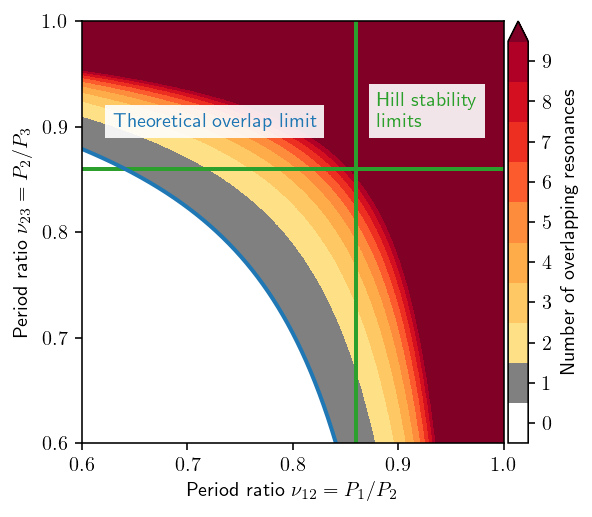

In [164]:
fig,ax = plt.subplots(figsize=(4,4))
ax.set_aspect('equal', adjustable='box')

boundaries = np.linspace(-.5, 9.5,11)
cmap_reds = plt.cm.get_cmap('YlOrRd',len(boundaries))
colors = list(cmap_reds(np.arange(len(boundaries))))
#replace first color with white
colors[0] = "white"
colors[1] = 'grey'
cmap = matplotlib.colors.ListedColormap(colors[:-1], "")
# set over-color to last color of list 
cmap.set_over(colors[-1])

pcm =plt.pcolormesh(Nu12,Nu23,Overlap_th-0.5,# -0.5 because of the color map
    cmap=cmap,rasterized=True,
    norm = matplotlib.colors.BoundaryNorm(boundaries, ncolors=len(boundaries)-1, clip=False)
)
cb = plt.colorbar(pcm, extend="max",fraction=0.045, pad=0.01)
cb.set_ticks(np.arange(10))
cb.set_label('Number of overlapping resonances')
ax.set_xlim(0.6,1)
ax.set_ylim(0.6,1)
ax.set_yticks(np.linspace(0.6,1,5))



Rh = (2e-4/3)**(1/3)
plt.axhline(1-3.46*Rh,lw=2,c='tab:green')
plt.axvline(1-3.46*Rh,lw=2,c='tab:green')
text = ax.text(0.88,0.9,'Hill stability\n limits',color='tab:green',zorder=2*pqmax+1,)
text.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='none'))
ax.plot(nu12ov,nu23ov,lw=2)
text = ax.text(0.63,0.9,'Theoretical overlap limit',color='tab:blue',zorder=2*pqmax+1,)
text.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='none'))

ax.set_xlabel(r'Period ratio $\nu_{12} = P_1/P_2$')
ax.set_ylabel(r'Period ratio $\nu_{23} = P_2/P_3$')

In [228]:
import scipy.ndimage as ndimage

In [167]:
Overlap_smoothed = ndimage.filters.gaussian_filter(Overlap,sigma=5)

Text(0, 0.5, 'Period ratio $\\nu_{23} = P_2/P_3$')

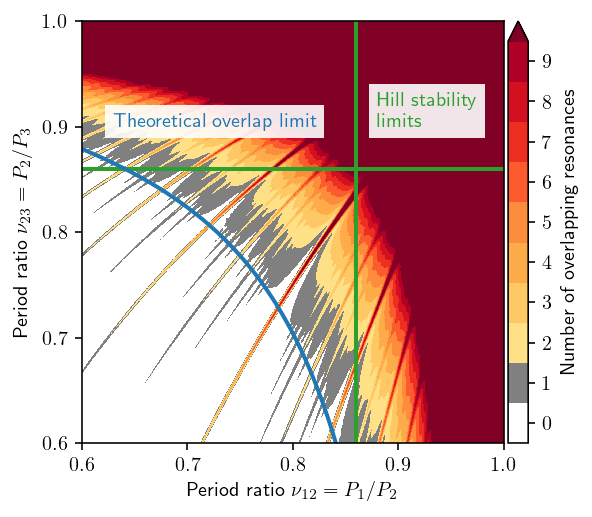

In [168]:
fig,ax = plt.subplots(figsize=(4,4))
ax.set_aspect('equal', adjustable='box')

boundaries = np.linspace(-.5, 9.5,11)
cmap_reds = plt.cm.get_cmap('YlOrRd',len(boundaries))
colors = list(cmap_reds(np.arange(len(boundaries))))
#replace first color with white
colors[0] = "white"
colors[1] = 'grey'
cmap = matplotlib.colors.ListedColormap(colors[:-1], "")
# set over-color to last color of list 
cmap.set_over(colors[-1])

pcm =plt.pcolormesh(Nu12,Nu23,np.floor(Overlap_smoothed),
    cmap=cmap,rasterized=True,
    norm = matplotlib.colors.BoundaryNorm(boundaries, ncolors=len(boundaries)-1, clip=False)
)
cb = plt.colorbar(pcm, extend="max",fraction=0.045, pad=0.01)
cb.set_ticks(np.arange(10))
cb.set_label('Number of overlapping resonances')
ax.set_xlim(0.6,1)
ax.set_ylim(0.6,1)
ax.set_yticks(np.linspace(0.6,1,5))



Rh = (2e-4/3)**(1/3)
plt.axhline(1-3.46*Rh,lw=2,c='tab:green')
plt.axvline(1-3.46*Rh,lw=2,c='tab:green')
text = ax.text(0.88,0.9,'Hill stability\n limits',color='tab:green',zorder=2*pqmax+1,)
text.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='none'))
ax.plot(nu12ov,nu23ov,lw=2)
text = ax.text(0.63,0.9,'Theoretical overlap limit',color='tab:blue',zorder=2*pqmax+1,)
text.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='none'))

ax.set_xlabel(r'Period ratio $\nu_{12} = P_1/P_2$')
ax.set_ylabel(r'Period ratio $\nu_{23} = P_2/P_3$')

Text(0, 0.5, 'Period ratio $\\nu_{23} = P_2/P_3$')

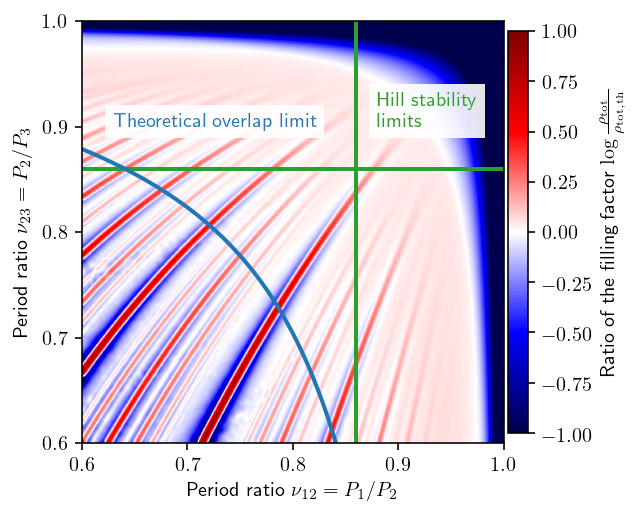

In [48]:
fig,ax = plt.subplots(figsize=(4,4))
ax.set_aspect('equal', adjustable='box')



pcm =plt.pcolormesh(Nu12,Nu23,np.log10(Overlap_smoothed/Overlap_th),
    cmap=cm.seismic,vmin=-1,vmax=1)

cb = plt.colorbar(pcm, fraction=0.045, pad=0.01)

cb.set_label(r'Ratio of the filling factors $\log\frac{\rho_{\mathrm{tot}}}{\rho_{\mathrm{tot,th}}}$')
ax.set_xlim(0.6,1)
ax.set_ylim(0.6,1)
ax.set_yticks(np.linspace(0.6,1,5))



Rh = (2e-4/3)**(1/3)
plt.axhline(1-3.46*Rh,lw=2,c='tab:green')
plt.axvline(1-3.46*Rh,lw=2,c='tab:green')
text = ax.text(0.88,0.9,'Hill stability\n limits',color='tab:green',zorder=2*pqmax+1,)
text.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='none'))
ax.plot(nu12ov,nu23ov,lw=2)
text = ax.text(0.63,0.9,'Theoretical overlap limit',color='tab:blue',zorder=2*pqmax+1,)
text.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='none'))

ax.set_xlabel(r'Period ratio $\nu_{12} = P_1/P_2$')
ax.set_ylabel(r'Period ratio $\nu_{23} = P_2/P_3$')


## Comparison Hill

In [1616]:
A=np.sqrt(38/pi)
print("numfacfreq A",A)
Ares = 4*2**.5/3*A
print("numfacres",Ares)
print("Coeff equal space",(1.5)**.5*Ares**.25*(0.5**2)**(3/8))
print("Numerical coeff Ts/P1, then log10",32*pi*2**.5/3*A,np.log10(32*pi*2**.5/3*A))

numfacfreq A 3.477898169151024
numfacres 6.55798767915458
Coeff equal space 1.165375227151379
Numerical coeff Ts/P1, then log10 164.82020732131525 2.217010456087706


In [1597]:
### Computation with equal mass and spacing
coef2pl = 1.46*2**(2/7)
coef3pl = 2*(1.5)**.5*Ares**.25*(0.5**2)**(3/8)

mm0 = np.logspace(-7,-3,100)

ov2pl = coef2pl*mm0**(2/7)
ov3pl = coef3pl*mm0**.25
hill = (2/3*mm0)**(1/3)
hill_exact = (1-amdcrit.hill_circular_spacing(2*mm0))


fudge_fac = 2 # multiply the resonance width so 
ov3pl_fudge = ov3pl*fudge_fac**(1/4)




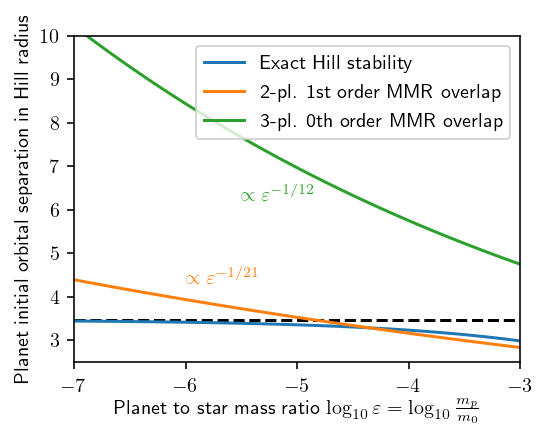

In [1598]:
fig,ax = plt.subplots(figsize=(4,3))
ax.plot(np.log10(mm0),2*3**.5*hill/hill,lw=1.5,ls='--',c='k')#label="Gladman Hill stability"
ax.plot(np.log10(mm0),hill_exact/hill,label="Exact Hill stability",lw=1.5)
ax.plot(np.log10(mm0),ov2pl/hill,label='2-pl. 1st order MMR overlap',lw=1.5)
ax.plot(np.log10(mm0),ov3pl/hill,label='3-pl. 0th order MMR overlap',lw=1.5)
#ax.plot(np.log10(mm0),ov3pl_fudge/hill,label='3-pl. MMR overlap\n larger width',lw=1.5)

ax.text(-5.5,6.2,r'$\propto\varepsilon^{-1/12}$',c='tab:green')
ax.text(-6,4.3,r'$\propto\varepsilon^{-1/21}$',c='tab:orange')

ax.legend()
ax.set_xlim(-7,-3)
ax.set_ylim(2.5,10)

ax.set_xlabel(r'Planet to star mass ratio $\log_{10}\varepsilon=\log_{10}\frac{m_p}{m_0}$')
ax.set_ylabel(r'Planet initial orbital separation in Hill radius')
fig.savefig('Figures/hillcomparison.pdf',bbox_inches='tight')
fig.savefig('../Paper/Figures/hillcomparison.pdf',bbox_inches='tight')

In [66]:
2/7-1/3

-0.047619047619047616

(0, 14)

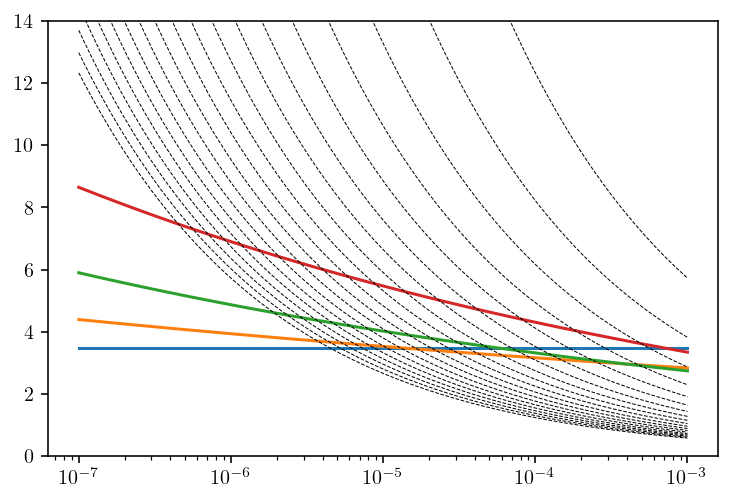

In [1591]:
#plt.semilogx(mm0,ov3pl/ov2pl)
plt.semilogx(mm0,2*3**.5*hill/hill)
plt.semilogx(mm0,ov2pl/hill)
plt.semilogx(mm0,ov3pl/hill)
plt.semilogx(mm0,ov3pl1/hill)

for k in range(1,20):
    plt.plot(mm0,np.ones_like(mm0)/(k+1)/hill,'k--',lw=0.5)
plt.ylim(0,14)

(0.0, 1)

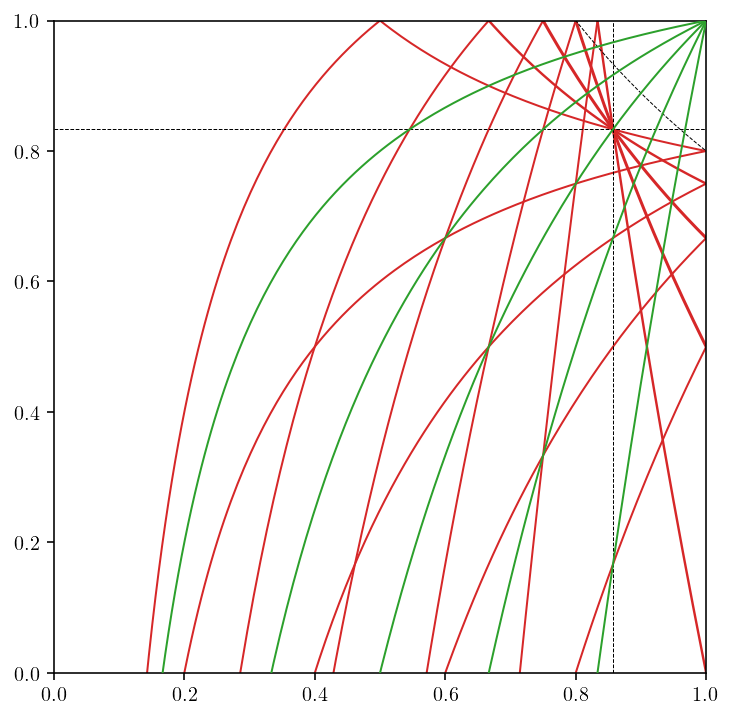

In [160]:
nu12_0 = np.linspace(0,1,200)[1:]
fig,ax = plt.subplots(figsize=(6,6))



for pq in range(6,7):
    for p in range(1,pq):
        q=pq-p
        if gcd(p,pq)==1:
            pass
        ax.plot(nu12_0,(1-p/q*(1/nu12_0-1)),c='tab:green',lw=6/pq**1,zorder=1000)

        ax.plot(nu12_0,(1+(p+1)/q-p/q*1/nu12_0),c='tab:red',lw=6/pq**1)
        ax.plot(nu12_0,(1+(p-1)/q-p/q*1/nu12_0),c='tab:red',lw=6/pq**1)
        ax.plot(nu12_0,(1-(p+1)/q+p/q*1/nu12_0),c='tab:red',lw=6/max(p,q+1)**1)

        #ax.plot(1/x,(1+(p+2)/q-p/q*1/x),c='tab:blue',lw=1/pq**.5)
        #ax.plot(1/x,(1+(p-2)/q-p/q*1/x),c='tab:blue',lw=1/pq**.5)
        
        
    ax.axhline((1-1/(p+1)),c='k',ls='--',lw=0.5)
    ax.axvline((1-1/(p+2)),c='k',ls='--',lw=0.5)
    
    ax.plot(nu12_0,(1-1/p)/nu12_0,c='k',ls='--',lw=0.5)
ax.set_xlim(0.,1)
ax.set_ylim(0.,1)



(0.0, 1)

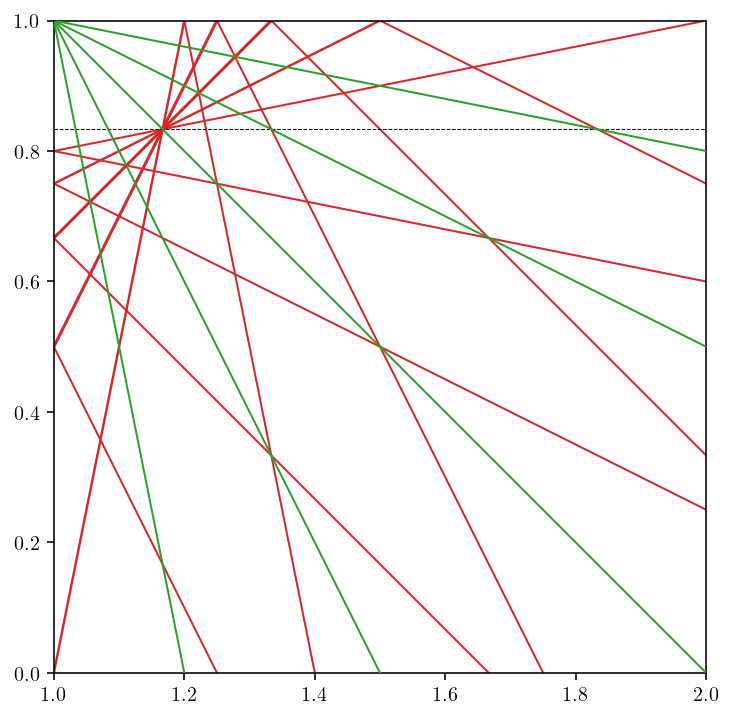

In [155]:
nu12_0 = np.linspace(0,1,200)[1:]
fig,ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal', adjustable='box')


for pq in range(6,7):
    for p in range(1,pq):
        q=pq-p
        if gcd(p,pq)==1:
            pass
        ax.plot(1/nu12_0,(1-p/q*(1/nu12_0-1)),c='tab:green',lw=6/pq**1,zorder=1000)

        ax.plot(1/nu12_0,(1+(p+1)/q-p/q*1/nu12_0),c='tab:red',lw=6/pq**1)
        ax.plot(1/nu12_0,(1+(p-1)/q-p/q*1/nu12_0),c='tab:red',lw=6/pq**1)
        ax.plot(1/nu12_0,(1-(p+1)/q+p/q*1/nu12_0),c='tab:red',lw=6/max(p,q+1)**1)

        #ax.plot(1/x,(1+(p+2)/q-p/q*1/x),c='tab:blue',lw=1/pq**.5)
        #ax.plot(1/x,(1+(p-2)/q-p/q*1/x),c='tab:blue',lw=1/pq**.5)
        
        
    ax.axhline((1-1/(p+1)),c='k',ls='--',lw=0.5)
    ax.axvline((1-1/(p+1)),c='k',ls='--',lw=0.5)
    
    ax.plot(nu12_0,(1-1/p)/nu12_0,c='k',ls='--',lw=0.5)
ax.set_xlim(1,2)
ax.set_ylim(0.,1)



## Curve as a function of dov

In [53]:
ddov = np.linspace(0,1,10000)
xiov = -1-sc.special.lambertw((-1+ddov**4)/np.exp(1),-1).real
def xiovapp(c,ddov=ddov):
    return np.sqrt(2*np.log(1/(1-ddov**4)))+c*np.log(1/(1-ddov**4))

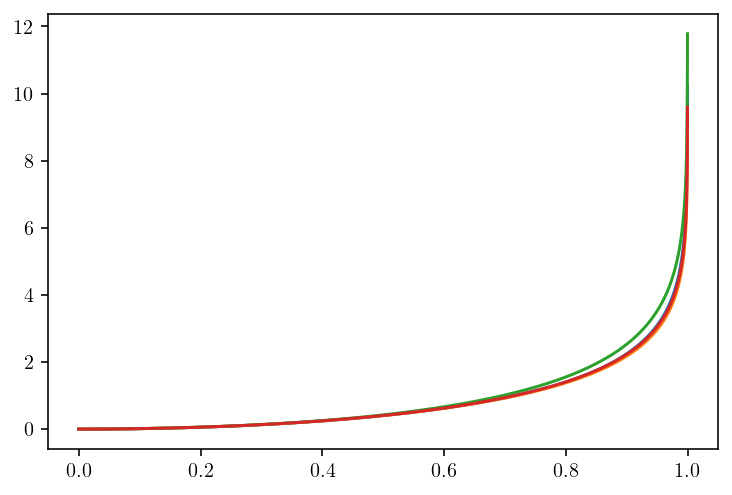

In [56]:
plt.plot(ddov,xiov)
plt.plot(ddov,xiovapp(2/3))
plt.plot(ddov,xiovapp(1))
plt.plot(ddov,xiovapp(2**1.5/3-2/9))

(0, 0.1)

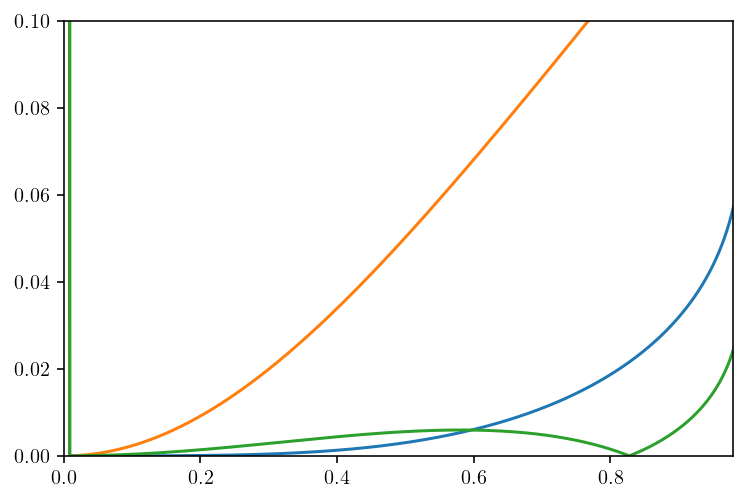

In [59]:

plt.plot(ddov,abs(1-xiovapp(2/3)/xiov))
plt.plot(ddov,abs(1-xiovapp(1)/xiov))
plt.plot(ddov,abs(1-xiovapp(2**1.5/3-2/9)/xiov))
plt.xlim(0,0.98)
plt.ylim(0,0.1)

In [60]:
2**1.5/3-2/9

0.7205868193598413

In [61]:
ddov[abs(1-xiovapp(2**1.5/3-2/9)/xiov)>0.02][0]

0.00010001000100010001

# Diffusion timescale

## Determination of the integral $\int_0^\infty \sqrt{x}e^x dx$

In [1284]:
import sympy as sy

0.6976189480252304

In [1285]:
xi,a=sy.symbols('xi,a')

In [1566]:
res=sy.simplify(sy.integrate(sy.sqrt(21/(4*xi)+sy.Rational(17,4))*xi*sy.exp(-xi),(xi,0,sy.oo)))

In [1567]:
sy.simplify(res)

-441*sqrt(17)*meijerg(((-1/2,), ()), ((-2, 0), ()), 21/17)/(1156*sqrt(pi))

In [1472]:
res0=sy.simplify(sy.integrate(sy.sqrt(sy.Rational(17,4))*xi*sy.exp(-xi),(xi,0,sy.oo)))

In [1560]:
res

Integral(sqrt(xi*(17*xi + 21))*exp(-xi), (xi, 0, a))/2

In [1483]:
sy.N(res)

3.02893076267316

In [1474]:
res0

sqrt(17)/2

Text(0, 0.5, 'Resonance density')

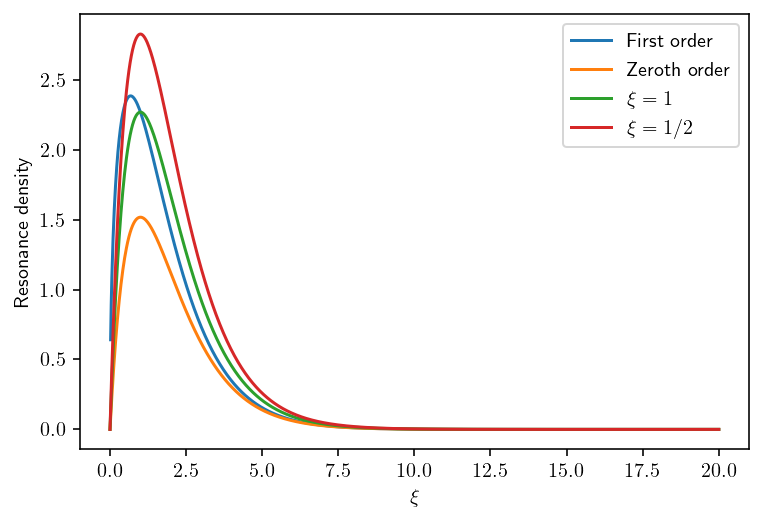

In [1940]:
xis = np.linspace(0,20,1000)
#plt.plot(xis,np.sqrt(5.25/xis+17+1/(4*xis**2))*xis*np.exp(-xis))
plt.plot(xis,np.sqrt(21/xis+17)*xis*np.exp(-xis),label='First order')
plt.plot(xis,np.sqrt(17)*xis*np.exp(-xis),label='Zeroth order')
plt.plot(xis,np.sqrt(38)*xis*np.exp(-xis),label=r'$\xi=1$')
plt.plot(xis,np.sqrt(17+21*2)*xis*np.exp(-xis),label=r'$\xi=1/2$')
plt.legend()
plt.xlabel(r'$\xi$')
plt.ylabel(r'Resonance density')

In [1591]:
4*2**.5/3*(38/pi)**.5

6.55798767915458

In [1589]:
(38/pi)**.5

3.477898169151024

In [1577]:
sy.N(sy.solve(-2*xi**2+2*(1-sy.Rational(21,17))*xi+sy.Rational(21,17))[0])

0.677015063888606

In [1580]:
np.sqrt(17+14)/2

2.7838821814150108

(0, 10)

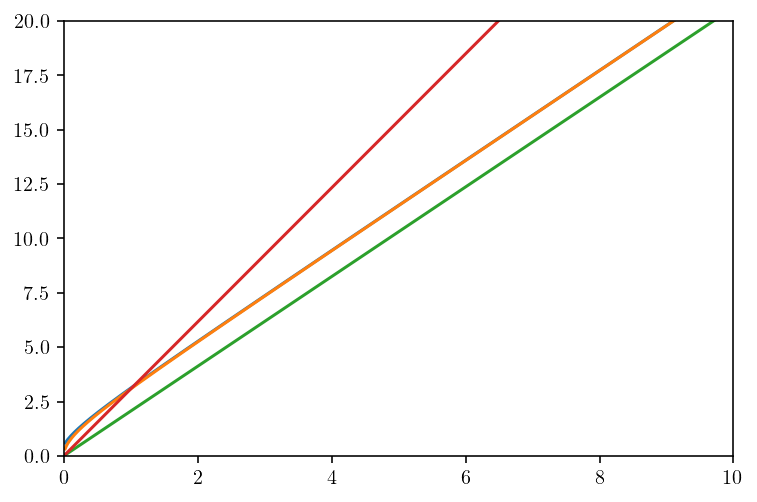

In [1615]:

plt.plot(xis,np.sqrt(5.25/xis+17/4+1/(4*xis**2))*xis)
plt.plot(xis,np.sqrt(5.25/xis+17/4)*xis)
plt.plot(xis,np.sqrt(17/4)*xis)
plt.plot(xis,np.sqrt(38/4)*xis)
plt.ylim(0,20)
plt.xlim(0,10)

In [1473]:
sy.N(res0)

2.06155281280883

In [1343]:
getLogpart(np.linspace(0,0.3,100),0.5)

array([        inf, 36.28257013, 28.29838536, 24.07338563, 21.27510663,
       19.21858025, 17.61220088, 16.3058939 , 15.21273392, 14.27809905,
       13.46555019, 12.74963629, 12.11192217, 11.5386535 , 11.0193134 ,
       10.54569228, 10.11126723,  9.71077559,  9.33991432,  8.99512332,
        8.67342615,  8.37231101,  8.08964022,  7.82358068,  7.57254948,
        7.33517116,  7.11024356,  6.89671039,  6.69363893,  6.50020187,
        6.31566224,  6.13936099,  5.97070658,  5.80916622,  5.65425851,
        5.50554716,  5.36263563,  5.22516253,  5.0927977 ,  4.96523876,
        4.84220814,  4.72345052,  4.60873053,  4.49783079,  4.39055018,
        4.28670224,  4.18611386,  4.08862404,  3.99408281,  3.90235029,
        3.8132958 ,  3.72679708,  3.64273965,  3.56101613,  3.48152568,
        3.40417354,  3.32887049,  3.25553251,  3.18408033,  3.11443914,
        3.04653823,  2.98031073,  2.91569333,  2.85262603,  2.79105195,
        2.7309171 ,  2.67217017,  2.61476242,  2.55864746,  2.50

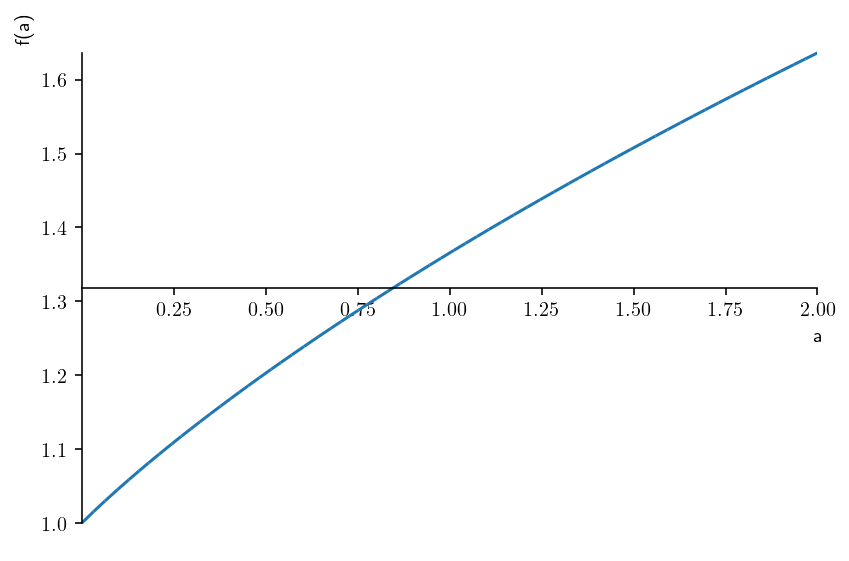

In [1342]:
sy.plot(res,(a,1e-9,2))

In [319]:
y0,D,t,z,a,T = sy.symbols('y0,D,t,z,a,T')

In [546]:
from sympy.abc import k,d,K

In [250]:
with sy.assuming(sy.Q.positive(K)):
    integ = sy.simplify(sy.integrate(sy.sqrt(k)*sy.exp(k),(k,0,K)))

In [251]:
integ

sqrt(K)*exp(K) + I*sqrt(pi)*erf(I*sqrt(K))/2

In [506]:
integ.diff(K)

sqrt(K)*exp(K)

In [254]:
integ2 = (sy.sqrt(K))*sy.exp(K)-sy.sqrt(sy.pi)/2*sy.erfi(sy.sqrt(K))

In [384]:
sy.simplify(sy.series(integ/(sy.sqrt(K)*sy.exp(K)),K,0))

2*K/3 - 4*K**2/15 + 8*K**3/105 - 16*K**4/945 + 32*K**5/10395 + O(K**6)

In [276]:
sy.series(sy.sqrt(sy.pi)/2*sy.erfi(sy.sqrt(K))*sy.exp(-K),K,0)

sqrt(K) - 2*K**(3/2)/3 + 4*K**(5/2)/15 - 8*K**(7/2)/105 + 16*K**(9/2)/945 - 32*K**(11/2)/10395 + O(K**6)

In [227]:
sy.series(integ**2-K*(sy.exp(K)-1-K/3)**2,K,0)

-2*K**4/15 - 767*K**5/6300 + O(K**6)

In [257]:
sy.simplify(sy.integrate(k*d**2*sy.exp(-k*d),(k,0,sy.oo)))

Piecewise((1, Abs(arg(d)) < pi/2), (d**2*Integral(k*exp(-d*k), (k, 0, oo)), True))

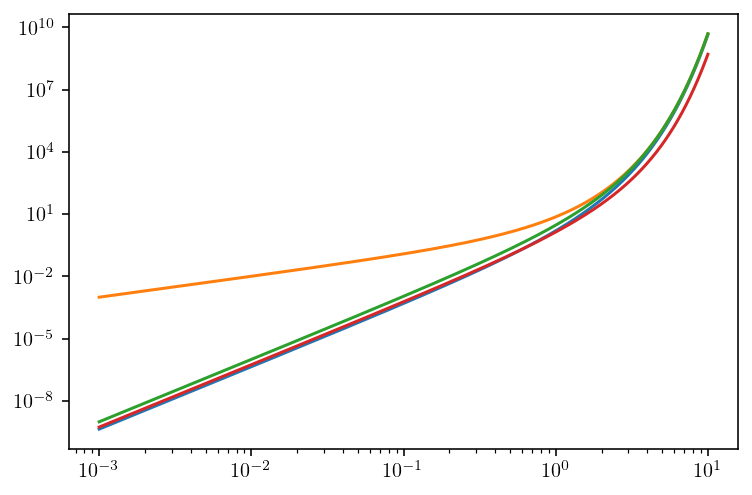

In [190]:
x = np.linspace(0.001,10,100000)

plt.loglog(x,(x**.5*np.exp(x)+(pi)**.5*1j*sc.special.erf(1j*(x)**.5)/2)**2)
plt.loglog(x,(x**.5*np.exp(x))**2)
plt.loglog(x,x*(np.exp(x)-1)**2)
plt.plot(x,x*(np.exp(x)-1)**2-(x**.5*np.exp(x)+(pi)**.5*1j*sc.special.erf(1j*(x)**.5)/2)**2)


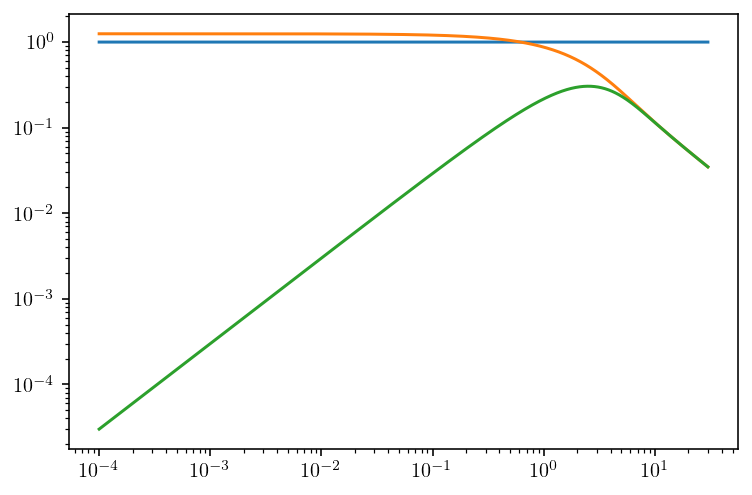

In [237]:
x = np.linspace(0.0001,30,100000)
real = (x**.5*np.exp(x)+(pi)**.5*1j*sc.special.erf(1j*(x)**.5)/2)**2
plt.loglog(x,real/real)
#plt.loglog(x,(x**.5*np.exp(x))/real)
#plt.loglog(x,-(x**.5*np.exp(x)+(pi)**.5*1j*sc.special.erf(1j*(x)**.5)/2)**2+(x**.5*(np.exp(x)-1))**2)
plt.loglog(x,((x*(np.exp(x)-1)**2)/real-1))
plt.loglog(x,abs((x*(np.exp(x)-1-x/3)**2)/real-1))

In [10]:
import scipy.integrate as integrate

In [11]:
def J(t,y0,D=1):
    return y0/(4*pi*D*t**3)**.5*np.exp(-y0**2/(4*D*t))
def Jt(t,y0,D=1):
    return y0/(4*pi*D*t)**.5*np.exp(-y0**2/(4*D*t))

In [12]:
def Pt_ex(t,y0,dy,D=1,N=10):
    res = 0
    for k in np.arange(-N-1,N+1):
        yk = dy-y0+k*dy
        res+=yk/(4*pi*D*t**3)**.5*(-1.)**k*np.exp(-yk**2/(4*D*t))
    return res

In [13]:
def P(y,t,y0,D=1):
    return 1/(4*pi*D*t)**.5*(np.exp(-(y-y0)**2/(4*D*t))-np.exp(-(y+y0)**2/(4*D*t))-np.exp(-(y-3*y0)**2/(4*D*t)))

In [14]:
def P_one(y,t,y0,D=1):
    return 1/(4*pi*D*t)**.5*(np.exp(-(y-y0)**2/(4*D*t))-np.exp(-(y+y0)**2/(4*D*t)))

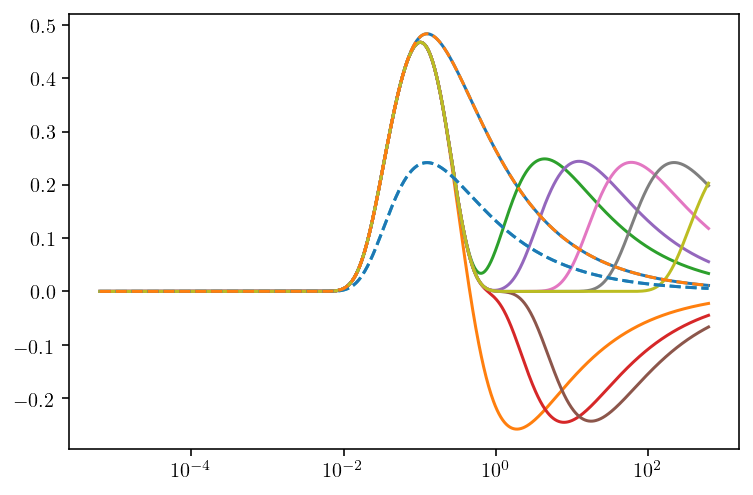

In [15]:
times = np.logspace(-4,4,1000)
y0=0.5
dy=1
D=1
timefac = y0**2*(1-y0)**2
for N in [0,1,2,3,4,5,10,20,50]:
    plt.semilogx(times*timefac,times*timefac*np.nan_to_num(Pt_ex(times*timefac,y0,dy,D,N=N)))
plt.semilogx(times*timefac, times*timefac*J(times*timefac,y0,D),'--')
plt.semilogx(times*timefac, times*timefac*J(times*timefac,dy-y0,D),'--')
plt.semilogx(times*timefac, times*timefac*J(times*timefac,dy-y0,D)+times*timefac*J(times*timefac,y0,D),'--')

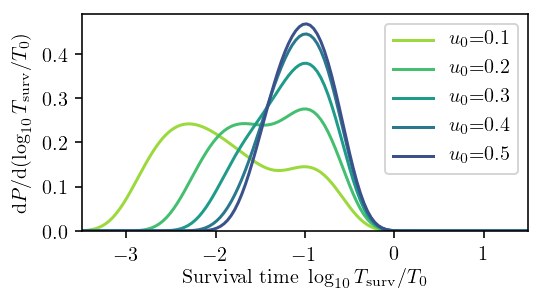

In [70]:
fig,ax = plt.subplots(figsize=(4,2))
times = np.logspace(-4,4,200)
y0=0.5
dy=1
D=1
timefac = y0**2*(1-y0)**2
for y0 in np.linspace(0.1,0.5,5):
    plt.plot(np.log10(times*timefac),times*timefac*np.nan_to_num(Pt_ex(times*timefac,y0,dy,D,N=201)),label = f'$u_0$=${y0:0.02}$',c=cm.viridis_r(1.5*y0))
plt.ylim(0)
plt.legend()
ax.set_xlim(-3.5,1.5)
ax.set_xlabel(r'$\mathrm{Survival\ time\ }\log_{10}T_{\mathrm{surv}}/T_0$')
ax.set_ylabel(r'$\mathrm{d}P/\mathrm{d}(\log_{10}T_{\mathrm{surv}}/T_0)$')
fig.savefig('Figures/pdf_survtime.pdf',bbox_inches='tight')
fig.savefig('../Paper/Figures/pdf_survtime.pdf',bbox_inches='tight')

In [16]:
stds=[]
means = []
meanex = []
stdex = []
nlstds = []
nlmeans =[]
skews = []
times = np.logspace(-4,4,1000)
y0s=np.linspace(0.01,0.99,1000)
remain = []
for y0 in y0s:

    dy=1
    D=1
    timefac = y0**2*(1-y0)**2
    exit_timeaspdf=np.maximum(0,np.nan_to_num(Pt_ex(times*timefac,y0,dy,D,N=200)))*np.diff(times*timefac,prepend=0)

    remain.append(np.sum(1-np.sum(exit_timeaspdf)))
    exit_timeaspdf = exit_timeaspdf/np.sum(exit_timeaspdf)
    
    exitimes = rd.choice(times*timefac,500000,p=exit_timeaspdf)
    
    stds.append(np.log10(exitimes).std())
    means.append(np.log10(exitimes).mean())
    skews.append(stats.skew(np.log10(exitimes)))
    nlstds.append(exitimes.std())
    nlmeans.append(exitimes.mean())
stds=np.array(stds)
means=np.array(means)
skews=np.array(skews)
nlstds=np.array(nlstds)
nlmeans=np.array(nlmeans)
remain = np.array(remain)

In [17]:
meanex = []
stdex = []
y0sex =np.linspace(0.01,0.99,100)
for y0 in y0sex:
    timefac = y0**2*(1-y0)**2
    meanex.append(integrate.quad(lambda x: x*np.exp(x)*timefac*np.nan_to_num(Pt_ex(np.exp(x)*timefac,y0,dy,D,N=200)),-5,5)[0])
    stdex.append(integrate.quad(lambda x: x**2*np.exp(x)*timefac*np.nan_to_num(Pt_ex(np.exp(x)*timefac,y0,dy,D,N=200)),-5,5)[0])
meanex =np.array(meanex)/np.log(10)
stdex =np.array(stdex)/np.log(10)**2
stdex = (stdex-meanex**2)**.5
meanex += 2*np.log10(y0sex*(1-y0sex))

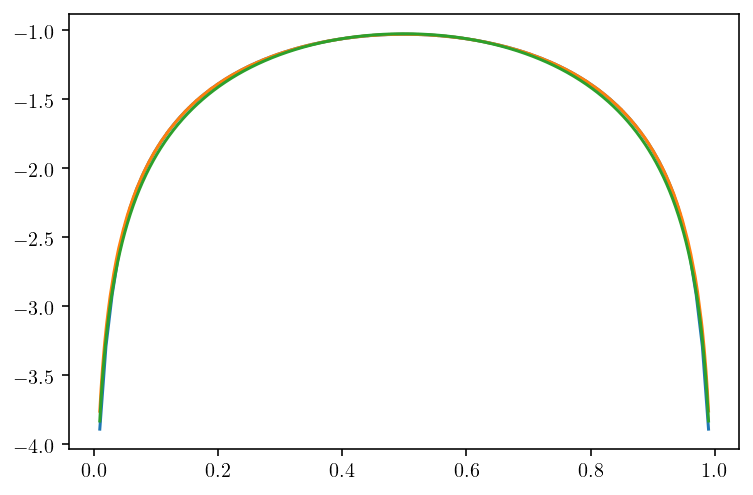

In [73]:
plt.plot(y0sex,meanex)
plt.plot(y0s,means)
plt.plot(y0s,2*np.log10(y0s*(1-y0s))+np.log10(1.5))

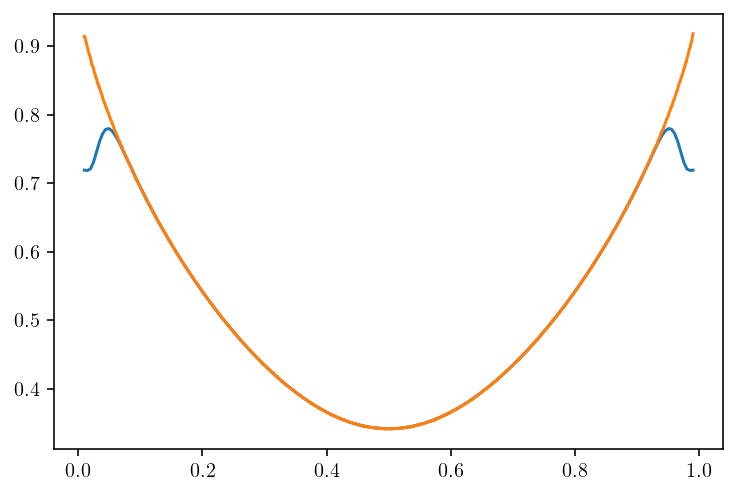

In [2231]:
plt.plot(y0sex,stdex)
plt.plot(y0s,stds)

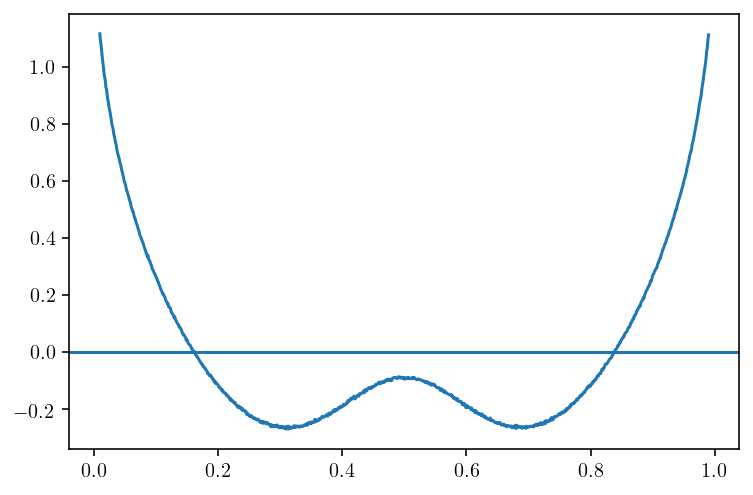

In [2150]:
plt.plot(y0s,skews)

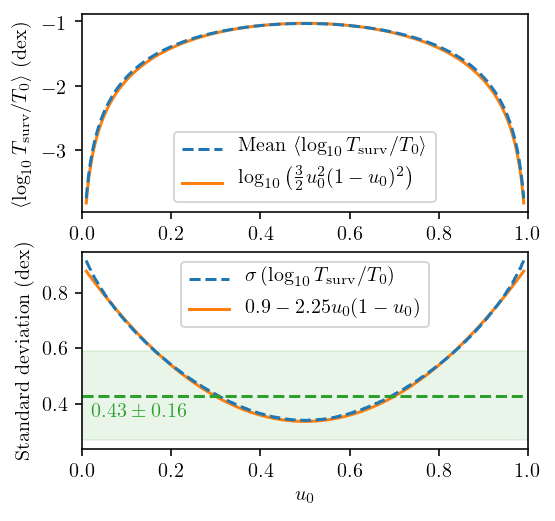

In [27]:
fig,axs = plt.subplots(2,figsize=(4,4))

axs[0].plot(y0s,means,label=r'$\mathrm{Mean\ }\langle\log_{10} T_{\mathrm{surv}}/T_0\rangle$',ls='--',zorder=2)
axs[0].plot(y0s,2*np.log10(y0s*(1-y0s))+np.log10(1.5),label=r'$\log_{10}\left(\frac{3}{2}u_0^2(1-u_0)^2\right)$',zorder=1)
axs[0].legend()
axs[0].set_xlim(0,1)
axs[1].set_xlabel(r'$u_0$')
axs[0].set_ylabel(r'$\langle\log_{10} T_{\mathrm{surv}}/T_0\rangle\mathrm{\ (dex)}$')

axs[1].plot(y0s,stds,label=r'$\sigma\left(\log_{10} T_{\mathrm{surv}}/T_0\right)$',ls='--',zorder=2)
axs[1].plot(y0s,0.9-2.25*y0s*(1-y0s),label=r'$0.9-2.25u_0(1-u_0)$',zorder=1)
axs[1].set_xlim(0,1)
axs[1].set_ylabel(r'$\mathrm{Standard\ deviation\ (dex)}$')
axs[1].legend()

axs[1].fill_between(np.linspace(0,1),0.43-0.16,0.43+0.16,color='tab:green',alpha=0.1)
axs[1].axhline(0.43,c='tab:green',ls='--')
axs[1].text(0.02,0.36,r'$0.43\pm0.16$',c='tab:green')

fig.savefig('Figures/pdf_survtime_stats.pdf',bbox_inches='tight')
fig.savefig('../Paper/Figures/pdf_survtime_stats.pdf',bbox_inches='tight')

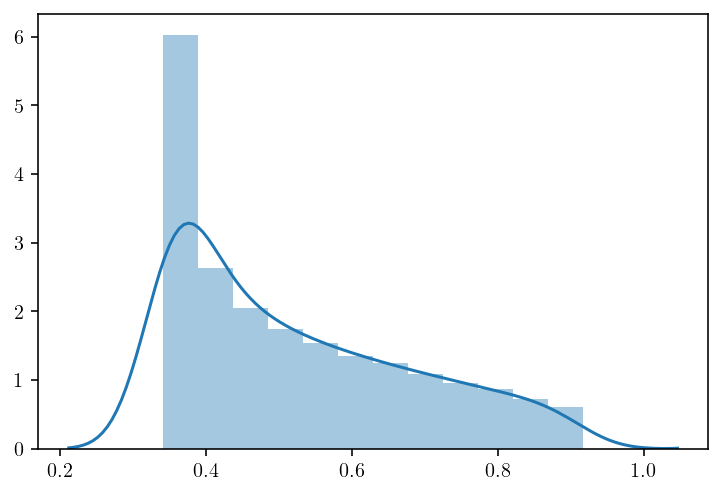

In [75]:
sns.distplot(stds)
#sns.distplot(means)

In [2477]:
np.mean(stds)

0.5224725204005516

In [994]:
#Rational fraction in coef diff
sld,c,xi,syddov = sy.symbols('sld,c,xi,\delta_r')
xil = sy.sqrt(2)*sld+c*sld**2
frac = (xil+3)**2/(xil**3*(xil+1))

In [995]:
sy.series(xil.replace(sld,sy.sqrt(-sy.log(1-syddov**4))),syddov,n=12)

sqrt(2)*\delta_r**2 + \delta_r**4*c + sqrt(2)*\delta_r**6/4 + \delta_r**8*c/2 + 13*sqrt(2)*\delta_r**10/96 + O(\delta_r**12)

In [1043]:
sy.series(1/(frac*syddov**2).replace(sld,sy.sqrt(-sy.log(1-syddov**4))),syddov,n=12)

2*sqrt(2)*\delta_r**4/9 + \delta_r**6*(2*c/3 + 4/27) + \delta_r**8*(sqrt(2)*c**2/3 + 8*sqrt(2)*c/27 + sqrt(2)/54) + \delta_r**10*(c**3/9 + 4*c**2/9 - 2*c/27 + 76/243) + O(\delta_r**12)

In [1344]:
Tdiff_expansion = sy.simplify(sy.series(1/(frac*syddov**6*2*sy.sqrt(2)/9).replace(c,solc).replace(sld,sy.sqrt(-sy.log(1-syddov**4))),syddov,n=3))
Tdiff_expansion

1 + 2*\delta_r**2 + O(\delta_r**3)

In [1345]:
Tdiff1 = syddov**4*2*sy.sqrt(2)/9/(1-syddov**4)
Tdiff = Tdiff1*Tdiff_expansion.removeO()

In [1334]:
sy.solve(sy.simplify(sy.expand(sy.log(Tdiff1)).diff(syddov).diff(syddov)).as_numer_denom()[0],syddov)[1].evalf()

0.668740304976422

In [1346]:
sy.simplify(sy.simplify(sy.expand(sy.log(Tdiff)).diff(syddov).diff(syddov)))

4*(-2*\delta_r**12 + \delta_r**10 + 24*\delta_r**8 + 18*\delta_r**6 - \delta_r**4 - 3*\delta_r**2 - 1)/(\delta_r**2*(4*\delta_r**12 + 4*\delta_r**10 - 7*\delta_r**8 - 8*\delta_r**6 + 2*\delta_r**4 + 4*\delta_r**2 + 1))

In [1379]:
sols=[]
for n in np.arange(2,10):
    Tdiff_expansion = sy.simplify(sy.series(1/(frac*syddov**6*2*sy.sqrt(2)/9).replace(c,solc).replace(sld,sy.sqrt(-sy.log(1-syddov**4))),syddov,n=n))
    Tdiff = Tdiff1*Tdiff_expansion.removeO()
    numer = sy.simplify(sy.expand(sy.log(Tdiff)).diff(syddov).diff(syddov)).as_numer_denom()[0]
    numerf = sy.lambdify(syddov,numer)
    numerdf = sy.lambdify(syddov,numer.diff(syddov))
    sol = optimize.fsolve(numerf,0.66,fprime=numerdf)
    sols.append(sol)

In [1380]:
sols

[array([0.6687403]),
 array([0.66726938]),
 array([0.66726938]),
 array([0.6486331]),
 array([0.6486331]),
 array([0.62339772]),
 array([0.62339772]),
 array([0.60375224])]

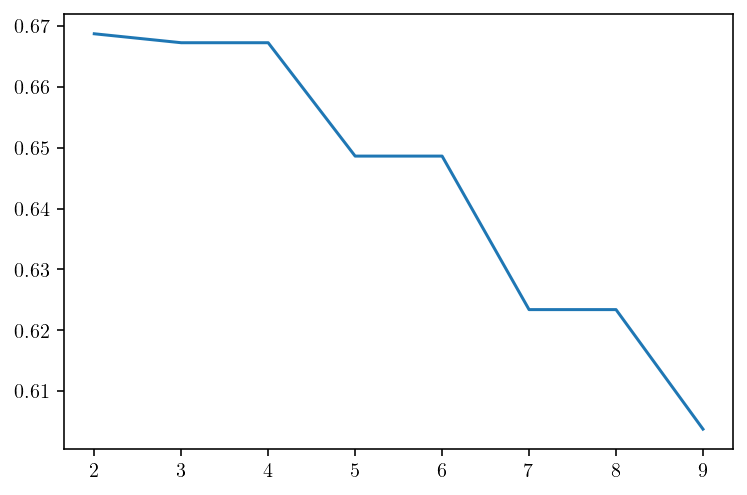

In [1382]:
plt.plot(np.arange(2,10),sols)

In [1298]:
.as_numer_denom()

(-4*\delta_r**10 - 20*\delta_r**12 + O(\delta_r**13),
 \delta_r**12 + 6*\delta_r**14 + O(\delta_r**15))

In [1263]:
sy.simplify(sy.expand(sy.log(Tdiff1)).diff(syddov).diff(syddov))

(20*\delta_r**4 - 4)/(\delta_r**10 - 2*\delta_r**6 + \delta_r**2)

In [1051]:
solc

-2/9 + 2*sqrt(2)/3

In [663]:
sy.series(sy.sqrt(-sy.log(1-syddov**4)),syddov,n=8)

\delta_r**2 + \delta_r**6/4 + O(\delta_r**8)

In [1031]:
frac

(c*sld**2 + sqrt(2)*sld + 3)**2/((c*sld**2 + sqrt(2)*sld)**3*(c*sld**2 + sqrt(2)*sld + 1))

In [1082]:
sy.series(1/frac.replace(c,solc),sld)

2*sqrt(2)*sld**3/9 + 4*sqrt(2)*sld**4/9 + sld**5*(8*sqrt(2)/81 + 16/81) + O(sld**6)

In [ ]:
seriesdiffT.re

In [1006]:
seriesdiffT = sy.series(sy.simplify((sy.log(xil**3*(xil+1)/(xil+3)**2/
                              (1-syddov**4)/syddov**2).replace(
    sld,sy.sqrt(-sy.log(1-syddov**4)))).diff(syddov))*syddov*(1-syddov**4)/4,syddov,n=7)

In [1233]:
seriesdiffT

1 + \delta_r**2*(3*sqrt(2)*c/4 + sqrt(2)/6) + \delta_r**4*(-3*c**2/4 + c/3 - 1/36) + \delta_r**6*(3*sqrt(2)*c**3/8 - 65*sqrt(2)*c/48 + 191*sqrt(2)/216) + O(\delta_r**7)

In [1022]:
solc = sy.solve(3*sy.sqrt(2)*c/4-1+sy.sqrt(2)/6,c)[0]
sy.simplify(solc)

-2/9 + 2*sqrt(2)/3

In [1012]:
sy.solve(-3*c**2/4+c/3-sy.Rational(1,36),c)

[1/9, 1/3]

In [1234]:
sy.simplify(seriesdiffT.replace(c,solc))

1 + \delta_r**2 + 4*sqrt(2)*\delta_r**4/9 - 29*\delta_r**4/36 + 233*sqrt(2)*\delta_r**6/243 - 139*\delta_r**6/108 + O(\delta_r**7)

In [1016]:
sy.simplify(seriesdiffT.replace(c,1))

1 + 11*sqrt(2)*\delta_r**2/12 - 4*\delta_r**4/9 - 41*sqrt(2)*\delta_r**6/432 + O(\delta_r**7)

In [930]:
2**.5-2/3

0.7475468957064285

In [931]:
solc.evalf()

0.720586819359841

In [933]:
2/3*(2**.5-1/3)

0.7205868193598413

In [776]:
4*2**.5/9-29/36

-0.1770161945008466

In [1028]:
sy.integrate(4*(1+syddov**2)/syddov/(1-syddov**4),syddov)

4*log(\delta_r) - 2*log(\delta_r**2 - 1)

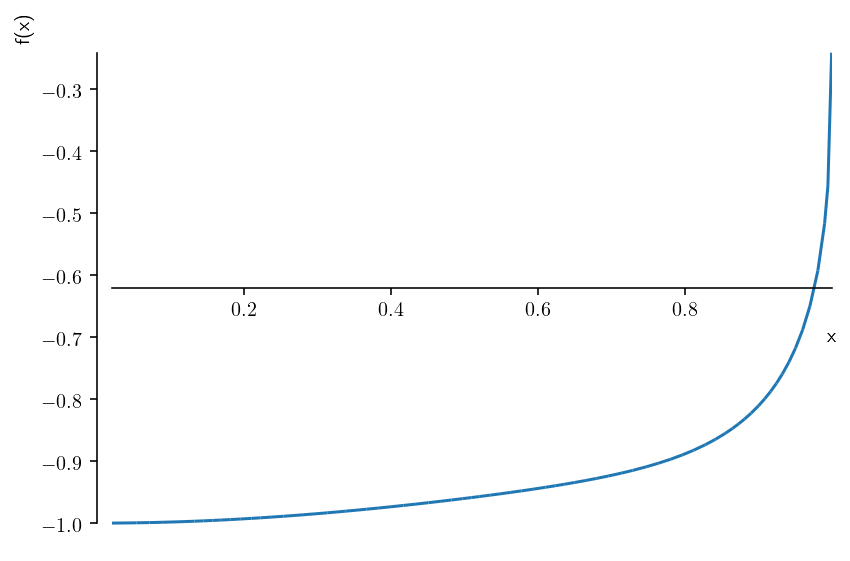

In [1025]:
sy.plot(((sy.simplify((sy.log(xil**3*(xil+1)/(xil+3)**2/
                              (1-syddov**4)/syddov**2).replace(
    sld,sy.sqrt(-sy.log(1-syddov**4))).replace(c,solc)).diff(syddov)).replace(syddov,c)*c*(1-c**4)/4-1)/-c**2,(c,0.02,0.9999)))


### Numpy plotting 

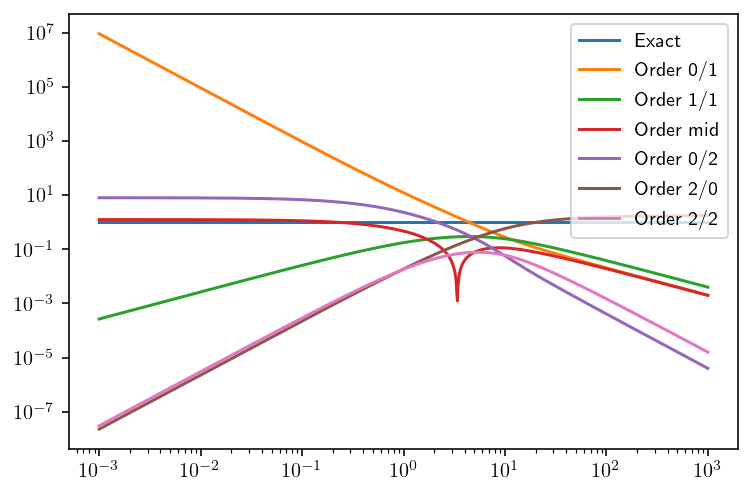

In [309]:
x = np.logspace(-3,3,1000)
daw = 1-sc.special.dawsn((x/2)**.5)/(x/2)**.5
dawapp1 = 1
dawapp2 = 1-(1/(1+1/3*x))
dawapp2b = 1-(1/(1+x))
dawapp2c = x/3/(1+x/5)
beta = 1
dawappmid = 1-(1/(1+beta/2*x))
b2 = 4/5
dawapp3 = 1-(((b2-2/3)*x/2+1)/(2*(b2-2/3)*(x/2)**2+b2*x/2+1))
plt.loglog(x,daw/daw,label='Exact')
plt.loglog(x,abs(dawapp1**2-daw**2)/daw**2,label='Order 0/1')
plt.loglog(x,abs(dawapp2**2-daw**2)/daw**2,label='Order 1/1')
plt.loglog(x,abs(dawappmid**2-daw**2)/daw**2,label='Order mid')
plt.loglog(x,abs(dawapp2b**2-daw**2)/daw**2,label='Order 0/2')
plt.loglog(x,abs(dawapp2c**2-daw**2)/daw**2,label='Order 2/0')
plt.loglog(x,abs(dawapp3**2-daw**2)/daw**2,label='Order 2/2')

plt.legend()

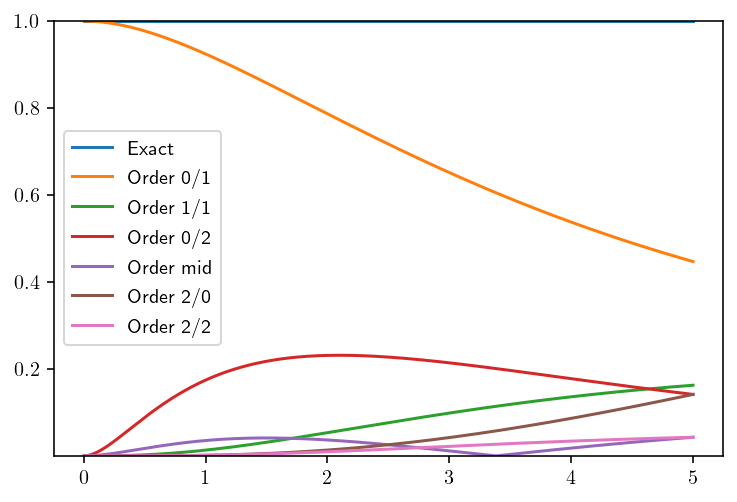

In [536]:
x = np.linspace(0,5,1000)
daw = 1-sc.special.dawsn((x/2)**.5)/(x/2)**.5
dawapp1 = 1
dawapp2 = 1-(1/(1+1/3*x))
dawapp2b = 1-(1/(1+x))
dawapp2c = x/3/(1+x/5)
beta = 1
dawappmid = 1-(1/(1+beta/2*x))
b2 = 4/5
dawapp3 = 1-(((b2-2/3)*x/2+1)/(2*(b2-2/3)*(x/2)**2+b2*x/2+1))
plt.plot(x,daw/daw,label='Exact')
plt.plot(x,abs(dawapp1**2-daw**2),label='Order 0/1')
plt.plot(x,abs(dawapp2**2-daw**2),label='Order 1/1')
plt.plot(x,abs(dawapp2b**2-daw**2),label='Order 0/2')
plt.plot(x,abs(dawappmid**2-daw**2),label='Order mid')
plt.plot(x,abs(dawapp2c**2-daw**2),label='Order 2/0')
plt.plot(x,abs(dawapp3**2-daw**2),label='Order 2/2')
plt.ylim(1e-6,1)
plt.legend()

In [534]:
np.max(np.nan_to_num(abs((1-(1/(1+beta*x)))**2-daw**2)))

0.23137401420210604

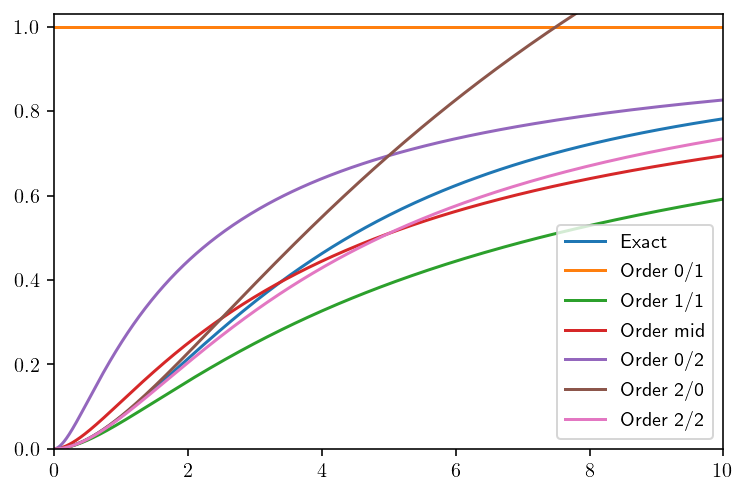

In [307]:
x = np.logspace(-3,np.log10(10),1000)



daw = 1-sc.special.dawsn((x/2)**.5)/(x/2)**.5
dawapp1 = np.ones_like(x)
beta = 1
dawmid = 1-(1/(1+beta/2*x))
dawapp2 = 1-(1/(1+1/3*x))
dawapp2b = 1-(1/(1+x))
dawapp2c = 5*x/(15+3*x)
b2 = 4/5
dawapp3 = 1-(((b2-2/3)*x/2+1)/(2*(b2-2/3)*(x/2)**2+b2*x/2+1))

plt.plot(x,daw**2,label='Exact')
plt.plot(x,dawapp1**2,label='Order 0/1')
plt.plot(x,dawapp2**2,label='Order 1/1')
plt.plot(x,dawmid**2,label='Order mid')
plt.plot(x,dawapp2b**2,label='Order 0/2')
plt.plot(x,dawapp2c**2,label='Order 2/0')
plt.plot(x,dawapp3**2,label='Order 2/2')
plt.xlim(0,np.max(x))
plt.ylim(0,1.03)
plt.legend()

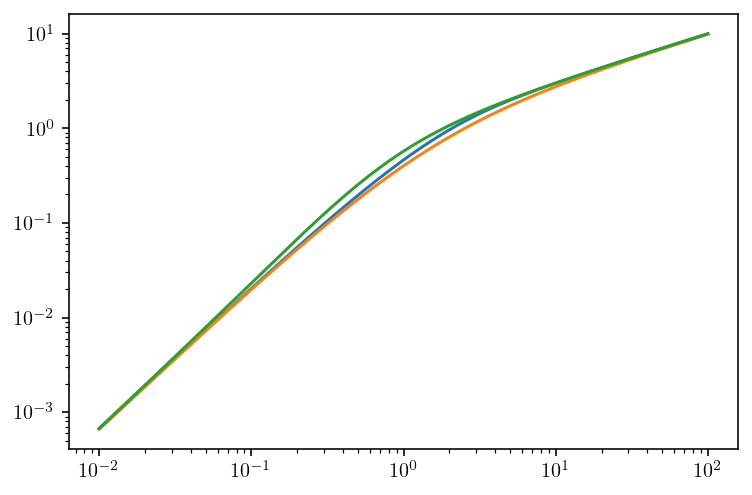

In [389]:
x = np.logspace(-2,2,1000)
daw = x**.5-sc.special.dawsn(x**.5)
dawapp = x**.5-x**.5*(1/(1+2/3*x))
beta = 1/3
dawapp2 =  x**.5-x**.5*((x+1)/(2*x**2+5/3*x+1))
plt.loglog(x,daw)
plt.loglog(x,dawapp)
plt.loglog(x,dawapp2)

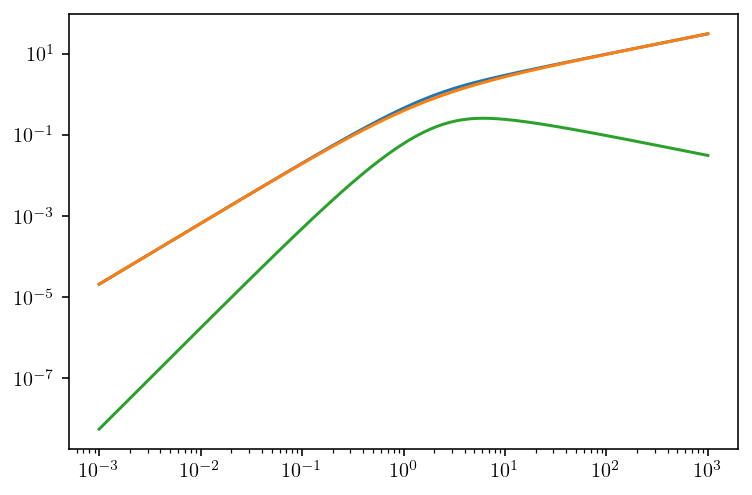

In [352]:
x = np.logspace(-3,3,1000)
daw = x**.5-sc.special.dawsn(x**.5)
dawapp = x**.5-x**.5*(1/(1+2/3*x))
beta = 1/3
dawapp2 = daw-dawapp
plt.loglog(x,daw)
plt.loglog(x,dawapp)
plt.loglog(x,dawapp2)

## Combining overlap and timescale

In [1145]:
ddov = np.linspace(0,1,10000)[100:-1] #Corresponds to d/d_ov
xiov = -1-sc.special.lambertw((-1+ddov**4)/np.exp(1),-1)
def xiovapp(c,ddov=ddov):
    return np.sqrt(2*np.log(1/(1-ddov**4)))+c*np.log(1/(1-ddov**4))

In [190]:
2**.5-2/3

0.7475468957064285

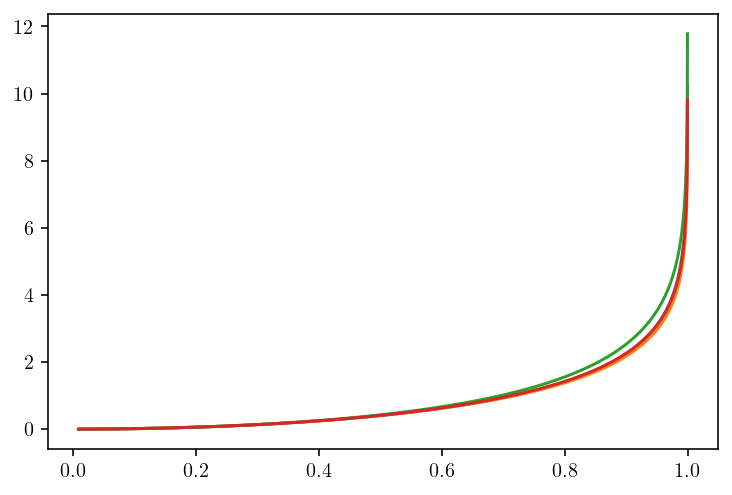

In [1146]:
plt.plot(ddov,xiov)
plt.plot(ddov,xiovapp(2/3))
plt.plot(ddov,xiovapp(1))
plt.plot(ddov,xiovapp(2**.5-2/3))

(0, 100)

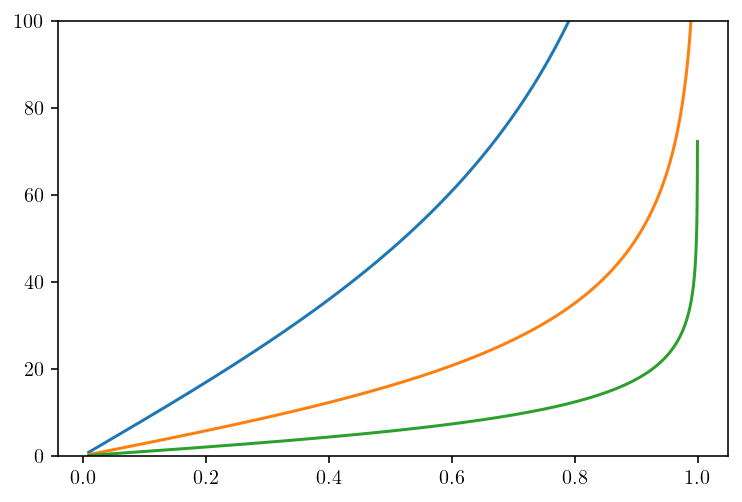

In [1152]:
for m in [1e-7,1e-5,1e-3]:
    plt.plot(ddov,xiov/ddov/get_plsep_ov(0.8,0.8,np.ones(3)*m))
plt.ylim(0,100)

In [191]:
ddov[(xiovapp(2**.5-2/3)/xiov-1)>0][-1]

0.9510951095109511

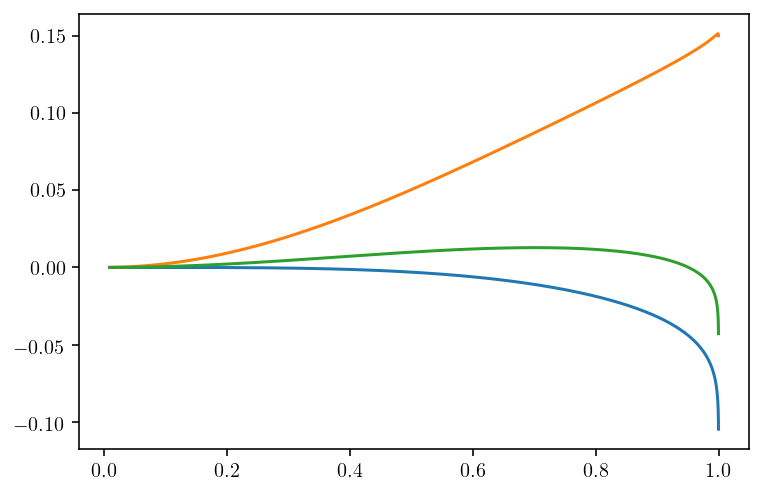

In [189]:
#plt.plot(ddov,xiov)
plt.plot(ddov,(xiovapp(2/3)/xiov-1))
plt.plot(ddov,(xiovapp(1)/xiov-1))
plt.plot(ddov,(xiovapp(2**.5-2/3)/xiov-1))

In [1419]:
## Part the depend on xi in Tins

def Txi(xi,F,ddov=None):
    if ddov is None:
        return xi*np.exp(xi)*F(xi)
    else:
        return xi*(xi+1)/(1-ddov**4)*F(xi)
def Fex(xi):
    return (1-sc.special.dawsn((xi/2)**.5)/(xi/2)**.5)**2

def F11(xi):
    return (xi/(3+xi))**2

def Fmid(xi):
    return (xi/(2+xi))**2
def F02(xi):
    return (xi/(1+xi))**2

def F22(xi):
    return (xi*(xi+5)/(xi**2+6*xi+15))**2
Txiex = Txi(xiov,Fex)/ddov**2
Txi22 = Txi(xiovapp(2**.5-2/3),F22,ddov=ddov)/ddov**2
Txi11 = Txi(xiovapp(2**.5-2/3),F11,ddov=ddov)/ddov**2
Txi02 = Txi(xiovapp(2**.5-2/3),F02,ddov=ddov)/ddov**2
Tximid = Txi(xiovapp(2**.5-2/3),Fmid,ddov=ddov)/ddov**2

Txi11_approx = Txi(2**.5*ddov**2+(2**.5-2/3)*ddov**4,F11,ddov=ddov)/ddov**2
Tapprox2 = (2**1.5/9*ddov**4+4*(1+ddov)*2**.5/9*ddov**6)/(1-ddov**4)
Tapproxlog = (2**1.5/9*(-np.log(1-ddov**4))**1.5+4*(1+ddov)*2**.5/9*(-np.log(1-ddov**4))**2)/(1-ddov**4)/ddov**2
Tapprox = (2**1.5/9*ddov**4)/(1-ddov**4)

In [1397]:
arg_inflex = np.argmin(abs(np.gradient(np.gradient(np.log10(Txiex).real,ddov),ddov)))

In [1399]:
slope_inflex = np.gradient(np.log10(Txiex).real,ddov)[arg_inflex]

(-5, 6.048717246322344)

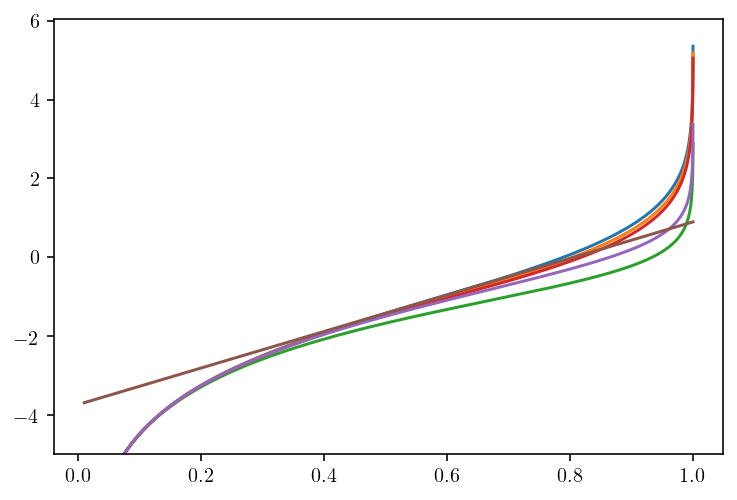

In [1400]:
plt.plot(ddov,np.log10(Txiex))
#plt.plot(ddov,np.log10(Txi22))
plt.plot(ddov,np.log10(Txi11))
#plt.plot(ddov,np.log10(Txi11_approx))
#plt.plot(ddov,np.log10(Txi02))
#plt.plot(ddov,np.log10(Tximid))

plt.plot(ddov,np.log10(Tapprox))
plt.plot(ddov,np.log10(Tapproxlog))
plt.plot(ddov,np.log10(Tapprox2))
plt.plot(ddov,np.log10(Txiex)[arg_inflex]+slope_inflex*(ddov-ddov[arg_inflex]))
plt.ylim(-5)


(-10, 10)

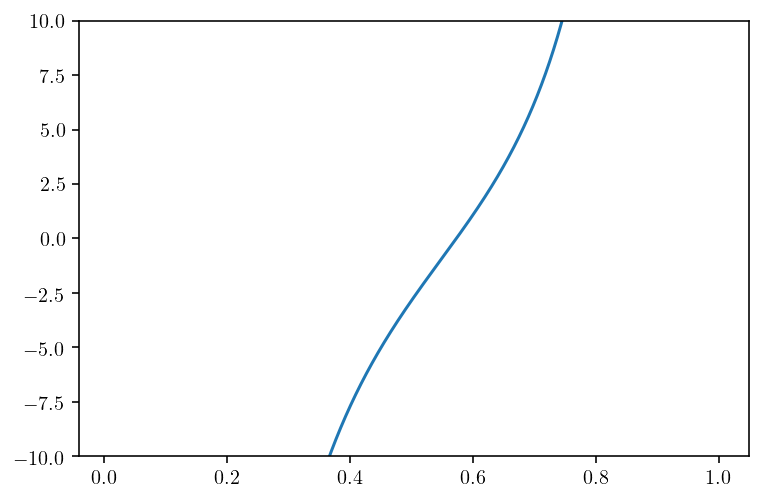

In [1395]:
plt.plot(ddov,np.gradient(np.gradient(np.log10(Txiex).real,ddov),ddov),)
plt.ylim(-10,10)

In [2464]:
infpointapprox = sy.simplify((4*sy.log(syddov)-sy.log(1-syddov**4)).diff(syddov).diff(syddov))

In [2469]:
solinf = sy.solve(infpointapprox)[1]
solinf

5**(3/4)/5

In [2470]:
(solinf).evalf()

0.668740304976422

In [2471]:
(4*sy.log(syddov)-sy.log(1-syddov**4)).replace(syddov,solinf).evalf()

-2.19101331733694

In [2473]:
(4*sy.log(syddov)-sy.log(1-syddov**4)).diff().replace(syddov,solinf).evalf()

7.47674390610610

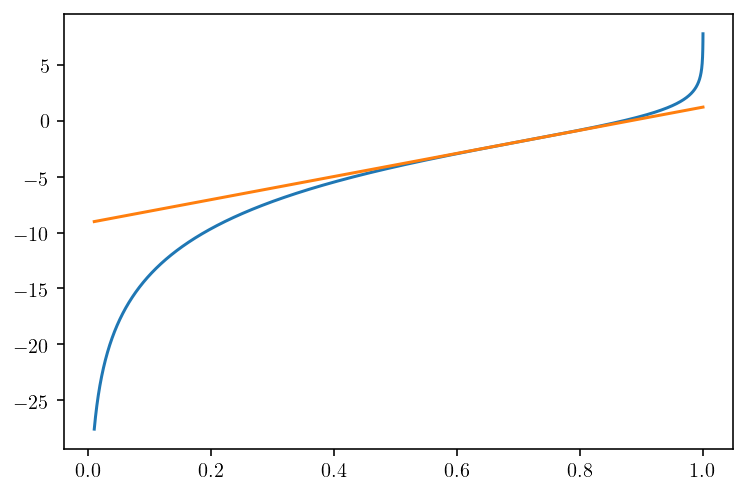

In [2476]:
plt.plot(ddov,np.log(ddov**6/(1-ddov**4)))
plt.plot(ddov,-1.75+10.37*(ddov-0.7109))


(0, 2)

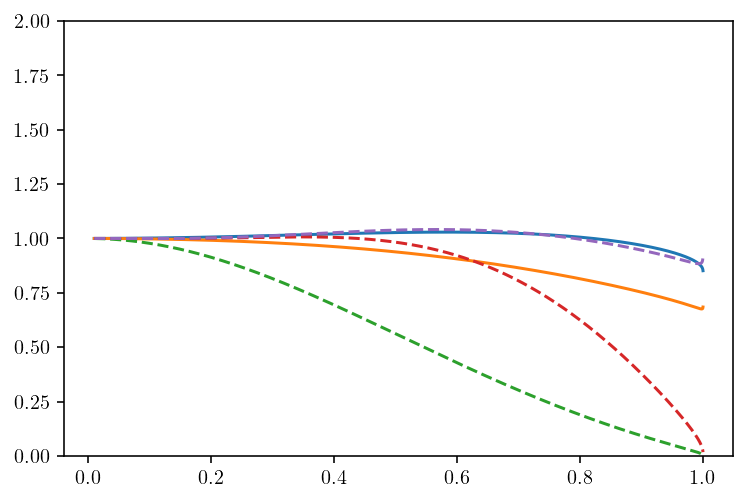

In [1420]:

plt.plot(ddov,abs(Txi22/Txiex))
plt.plot(ddov,abs(Txi11/Txiex))

#plt.plot(ddov,abs(Txi02/Txiex-1))
#plt.plot(ddov,abs(Tximid/Txiex-1))

plt.plot(ddov,abs(Tapprox/Txiex),'--')
plt.plot(ddov,abs(Tapprox2/Txiex),'--')
plt.plot(ddov,abs(Tapproxlog/Txiex),'--')

plt.ylim(0,2)
#plt.plot(invrho,np.log10(Txi(xiovapp(2**.5-2/3),Fex)))

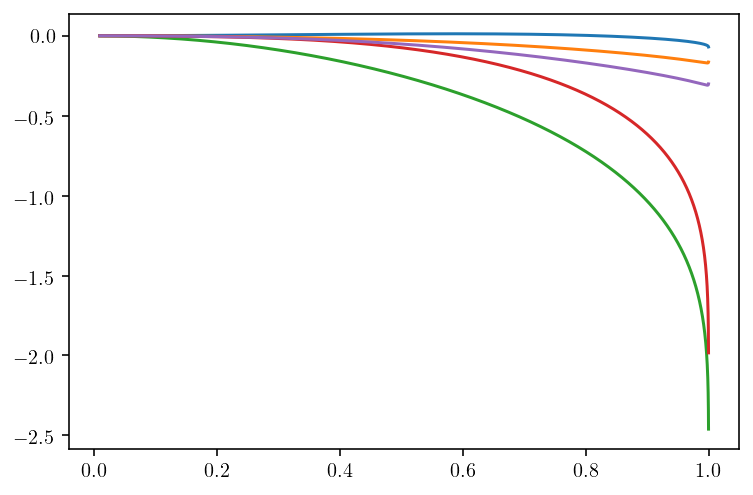

In [1402]:

plt.plot(ddov,np.log10(Txi22)-np.log10(Txiex))
plt.plot(ddov,np.log10(Txi11)-np.log10(Txiex))

plt.plot(ddov,np.log10(Tapprox)-np.log10(Txiex))
plt.plot(ddov,np.log10(Tapprox2)-np.log10(Txiex))
plt.plot(ddov,np.log10(Tapproxlog)-np.log10(Txiex))



#plt.plot(invrho,np.log10(Txi(xiovapp(2**.5-2/3),Fex)))

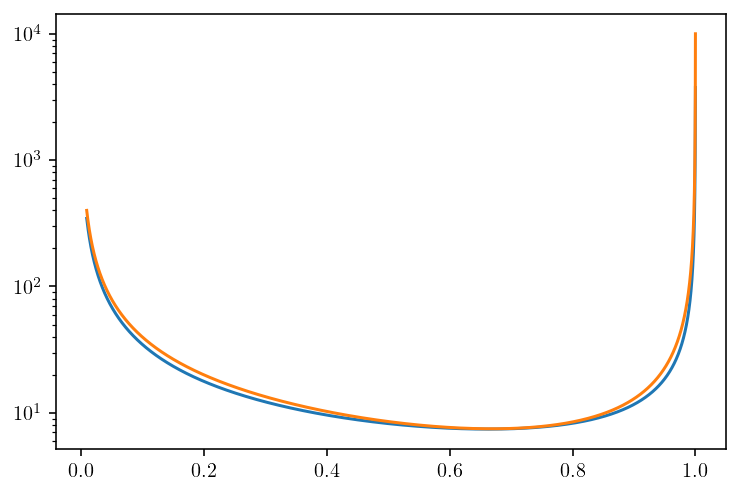

In [1232]:
plt.plot(ddov,np.gradient(np.log10(Txiex.real*ddov**4),ddov))

plt.yscale('log')
plt.plot(ddov,1/(ddov/4*(1-ddov**4)))

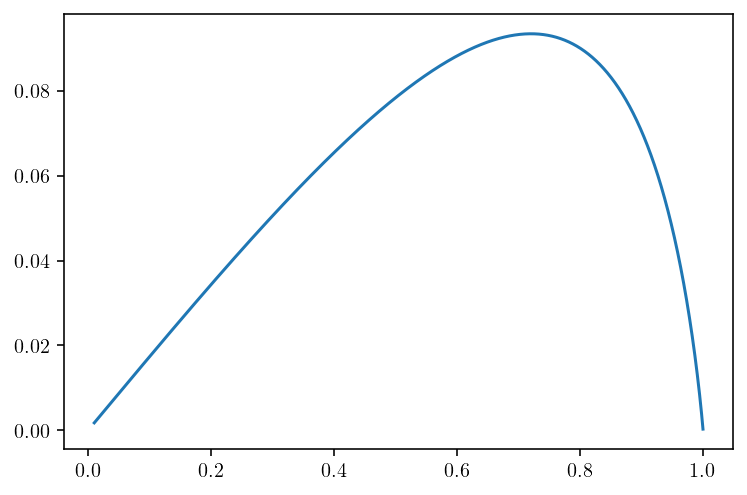

In [1208]:
plt.plot(ddov,1/(np.gradient(np.log10(Txiex.real),ddov)+4/ddov))

#plt.plot(ddov,1/4*(1-ddov**4)/ddov**3)

(0.01, 1)

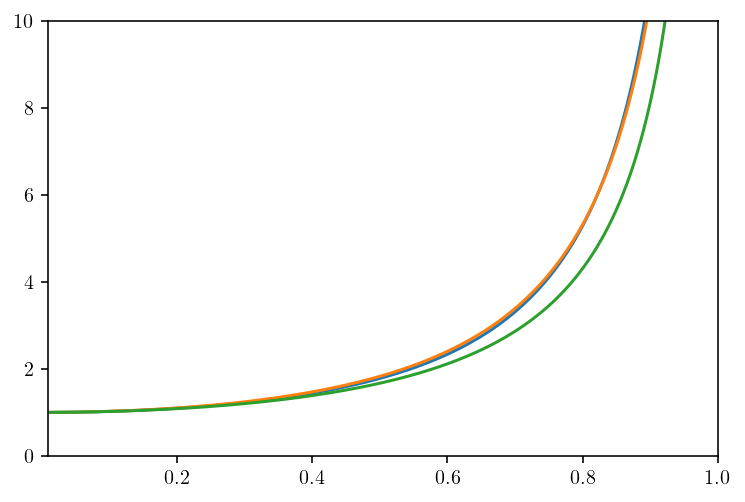

In [1117]:
plt.plot(ddov,(Txiex)*(1-ddov**4)/ddov**4/(2**1.5/9))
plt.plot(ddov,(Txi22)*(1-ddov**4)/ddov**4/(2**1.5/9))
plt.plot(ddov,(Txi11)*(1-ddov**4)/ddov**4/(2**1.5/9))
plt.ylim(1e-10,10)
plt.xlim(1e-2,1)
#plt.plot(invrho,np.log10(Txi(xiovapp(2**.5-2/3),Fex)))

In [1141]:
sy.series((1-syddov)/(1-syddov**4),syddov)

1 - \delta_r + \delta_r**4 - \delta_r**5 + O(\delta_r**6)

In [1145]:
sy.series(1/(1-syddov**2)**2,syddov)

1 + 2*\delta_r**2 + 3*\delta_r**4 + O(\delta_r**6)

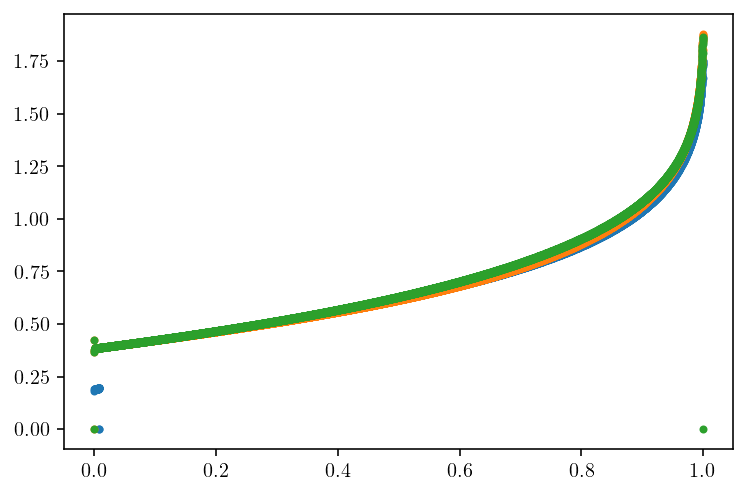

In [674]:
plt.plot(ddov,1/(ddov*(1-ddov))/np.gradient(np.log10(Txiex),ddov),'.')
plt.plot(ddov,1/(ddov*(1-ddov))/np.gradient(np.log10(Txi22),ddov),'.')
plt.plot(ddov,1/(ddov*(1-ddov))/np.gradient(np.log10(Txi11),ddov),'.')
#plt.plot(ddov,0.25*ddov*(1-ddov)*(4/3+ddov))
#plt.plot(invrho,np.log10(Txi(xiovapp(2**.5-2/3),Fex)))

In [673]:
(1/(ddov*(1-ddov))/np.gradient(np.log10(Txi22),ddov))[:10]*4/3

array([       nan, 0.        , 0.56693388, 0.48613242, 0.50407978,
       0.50677528, 0.50768014, 0.50847637, 0.5095342 , 0.51013766])

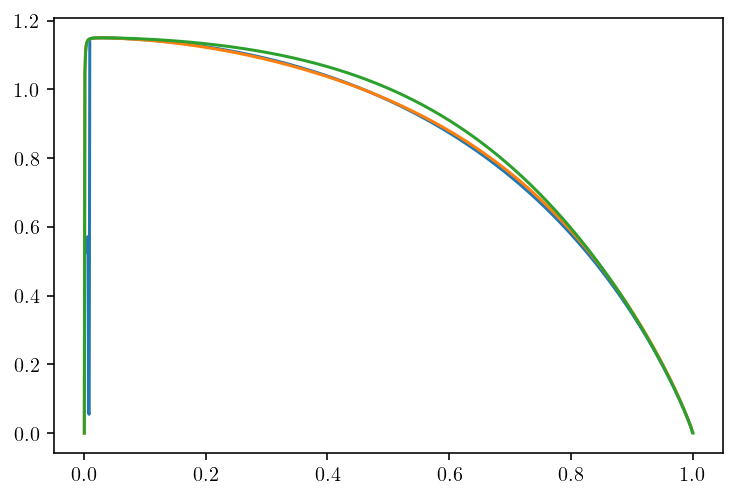

In [576]:
plt.plot(ddov,1/np.gradient(np.log10(Txiex),ddov)*3/ddov)
plt.plot(ddov,1/np.gradient(np.log10(Txi22),ddov)*3/ddov)
plt.plot(ddov,1/np.gradient(np.log10(Txi11),ddov)*3/ddov)
#plt.plot(invrho,np.log10(Txi(xiovapp(2**.5-2/3),Fex)))

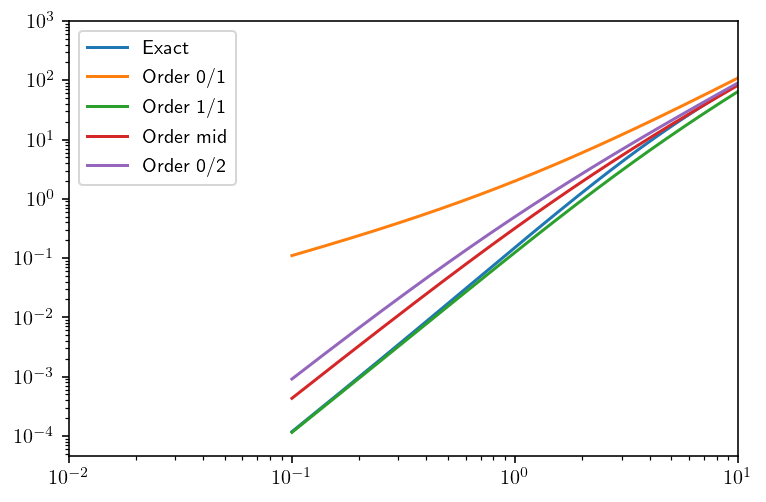

In [775]:
xi = np.logspace(-1,2,1000)
daw = (xi/2)**.5-sc.special.dawsn((xi/2)**.5)
dawapp1 = (xi/2)**.5
dawapp2 = (xi/2)**.5-(xi/2)**.5*(1/(1+2/3*(xi/2)))
beta = 4/3
dawmid = (xi/2)**.5-(xi/2)**.5*(1/(1+beta*(xi/2)))
dawapp2b = (xi/2)**.5-(xi/2)**.5*(1/(1+2*(xi/2)))
b2 = 4/5
dawapp3 = (xi/2)**.5-(xi/2)**.5*(((b2-2/3)*(xi/2)+1)/(2*(b2-2/3)*(xi/2)**2+b2*(xi/2)+1))
plt.loglog(xi,xi*(xi+1)*daw**2/(xi/2),label='Exact')
plt.loglog(xi,xi*(xi+1)*dawapp1**2/(xi/2),label='Order 0/1')
plt.loglog(xi,xi*(xi+1)*dawapp2**2/(xi/2),label='Order 1/1')
plt.loglog(xi,xi*(xi+1)*dawmid**2/(xi/2),label='Order mid')
plt.loglog(xi,xi*(xi+1)*dawapp2b**2/(xi/2),label='Order 0/2')
#plt.loglog(xi,xi*(xi+1)*dawapp3**2/(xi/2),label='Order 2/2')
plt.xlim(1e-2,np.max(x))
plt.ylim(0,1e3)
plt.legend()

# Putting some real numbers

In [587]:
import scipy.optimize as optimize

In [2483]:
# Equally spaced and equal mass

In [1627]:
masses = 1e-4*np.ones(3)

def getLogpart(plsep,eta):
    return abs(np.log(plsep**2/(eta*(1-eta))))+abs(np.log(plsep/eta)*np.log(plsep/(1-eta)))
def get_Mfac(nu12,nu23,masses):
    m1,m2,m3 = masses
    eta = nu12*(1-nu23)/(1-nu12*nu23)
    return (m1*m3/m0**2*(eta**2/nu12**(4/3)+1+(1-eta)**2*nu23**(4/3)))**.5

def get_plsep_ov(nu12,nu23,masses):
    m1,m2,m3 = masses
    m0=1
    eta = nu12*(1-nu23)/(1-nu12*nu23)

    plsep = 1/(1/(1-nu12**(2/3))+1/(1-nu23**(2/3)))
    Mfac = get_Mfac(nu12,nu23,masses)
    Ares = 4*2**.5*np.sqrt(38/pi)/3
    return (Mfac*A*(eta*(1-eta))**1.5)**.25


In [1749]:
def exact_xiov(nu12,nu23,masses,fudge=1):
    plsep_ov = get_plsep_ov(nu12,nu23,masses)*fudge
    al12 = nu12**(2/3)
    al23 = nu23**(2/3)
    plsep = (1-al12)*(1-al23)/(2-al12-al23)
    return -1-sc.special.lambertw((-1+(plsep/plsep_ov)**4)/np.exp(1),-1).real

def Tsurv(nu12,nu23,masses,fudge=1,res=True,exact_F=True,realLaplaceEMS=False):
    "In unit of P_1"
    if realLaplaceEMS:
        plsepov = 0.5*(1-np.exp(-2*get_plsep_ov(nu12,nu23,masses)*fudge))
    else:
        plsepov = get_plsep_ov(nu12,nu23,masses)*fudge
    al12 = nu12**(2/3)
    al23 = nu23**(2/3)
    eta = nu12*(1-nu23)/(1-nu12*nu23)
    plsep = (1-al12)*(1-al23)/(2-al12-al23)
    
    
    
    if exact_F:
        xiov = exact_xiov(nu12,nu23,masses,fudge=fudge)
        F = (1-sc.special.dawsn((xiov/2)**.5)/(xiov/2)**.5)**2
        Tnorm = xiov*(xiov+1)/(1-(plsep/plsepov)**4)*F
    else:
        Tnorm = 2**1.5/9*(plsep/plsepov)**6/(1-(plsep/plsepov)**4)*10**(-np.log(1-(plsep/plsepov)**4))
        
    
    A = np.sqrt(38/pi)
    Mfac = get_Mfac(nu12,nu23,masses)
    PrefacD = Mfac*nu12*A*2*pi*np.sqrt(eta*(1-eta)) #2pi from mean motion over period
    
    
    if res:
        Deta,u0=distance_eta_diffusion_direction(nu12,nu23,masses)
        
        Tsurv = ((np.maximum(Deta,np.sum(masses)**(2/3)/plsep**(1/3))/plsep)**2/(PrefacD) # the Deta is in unit of plsep since plsep already in Tnorm
                 *Tnorm*3/2*np.maximum(0.4,u0)**2*np.maximum(1-u0,0.4)**2)
    else:
        Tsurv = (3/2)**2/PrefacD*Tnorm*3/32 #Deta=3/2 in units of plsep
    #Tsurv += 0.001* (3/2*plsep)**2/(Mfac/nu12*np.sqrt(Logpart/2*eta*(1-eta))*plsep**2)*Tnorm
    return Tsurv
    
def Tnorm(nu12,nu23,masses,fudge=1,exact_F=True):
    "In unit of P_1"
    plsepov = get_plsep_ov(nu12,nu23,masses)*fudge
    al12 = nu12**(2/3)
    al23 = nu23**(2/3)
    eta = nu12*(1-nu23)/(1-nu12*nu23)
    plsep = (1-al12)*(1-al23)/(2-al12-al23)
    
    
    if exact_F:
        xiov = exact_xiov(nu12,nu23,masses,fudge=fudge)
        F = (1-sc.special.dawsn((xiov/2)**.5)/(xiov/2)**.5)**2
        Tnorm = xiov*(xiov+1)/(1-(plsep/plsepov)**4)*F
    else:
        Tnorm = 2**1.5/9*(plsep/plsepov)**6/(1-(plsep/plsepov)**4)*10**(-np.log(1-(plsep/plsepov)**4))

    return Tnorm


def Tnorm_plsepr(plsepr,exact_F=True):
    "Tnorm as a function of plsep/plsepov for curve comparison"
    plsepov = get_plsep_ov(nu12,nu23,masses)*fudge

    
    if exact_F:
        xiov = -1-sc.special.lambertw((-1+(plsepr)**4)/np.exp(1),-1).real
        F = (1-sc.special.dawsn((xiov/2)**.5)/(xiov/2)**.5)**2
        Tnorm = xiov*(xiov+1)/(1-(plsepr)**4)*F
    else:
        Tnorm = 2**1.5/9*(plsepr)**6/(1-(plsepr)**4)*10**(-np.log(1-(plsepr)**4))

    return Tnorm


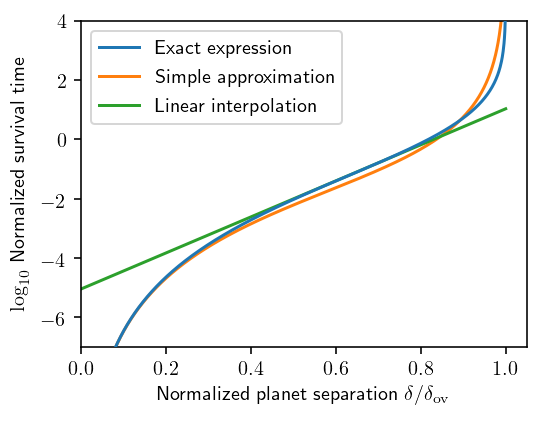

In [1748]:
fig,ax = plt.subplots(figsize=(4,3))
plsepr = np.linspace(0,1,1000)
plt.plot(plsepr,np.log10(Tnorm_plsepr(plsepr,exact_F=True)),label='Exact expression',zorder=3)
plt.plot(plsepr,np.log10(Tnorm_plsepr(plsepr,exact_F=False)),label='Simple approximation')
plt.plot(plsepr,bfun+afun*plsepr,label='Linear interpolation')
plt.ylim(-7,4)
plt.xlim(0,1.05)
plt.legend()
plt.xlabel(r'Normalized planet separation $\delta/\delta_{\mathrm{ov}}$')
plt.ylabel(r'$\log_{10}$ Normalized survival time')
fig.savefig('../Paper/normalizedtime.pdf')

(1e-05, 1000000000.0)

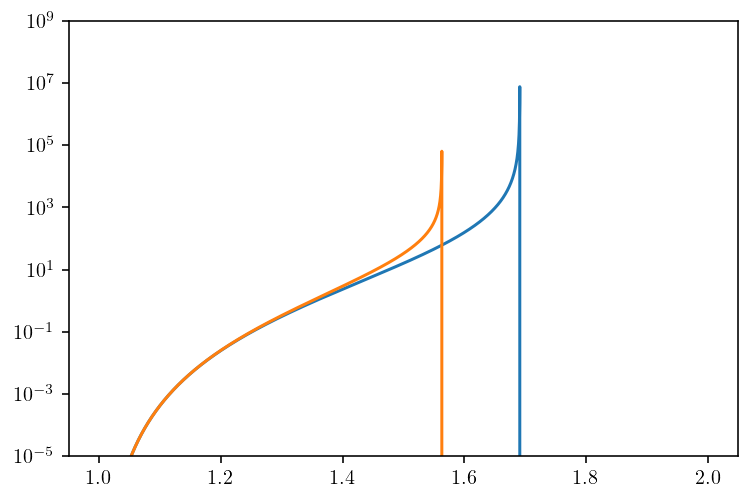

In [1756]:
nu12_large=np.linspace(0.5,1,10000)
plt.semilogy(1/nu12_large,Tsurv(nu12_large,nu12_large,1e-3*np.ones(3),res=False))
plt.semilogy(1/nu12_large,Tsurv(nu12_large,nu12_large,1e-3*np.ones(3),res=False,realLaplaceEMS=True))
plt.ylim(1e-5,1e9)

(1e-05, 1000000000.0)

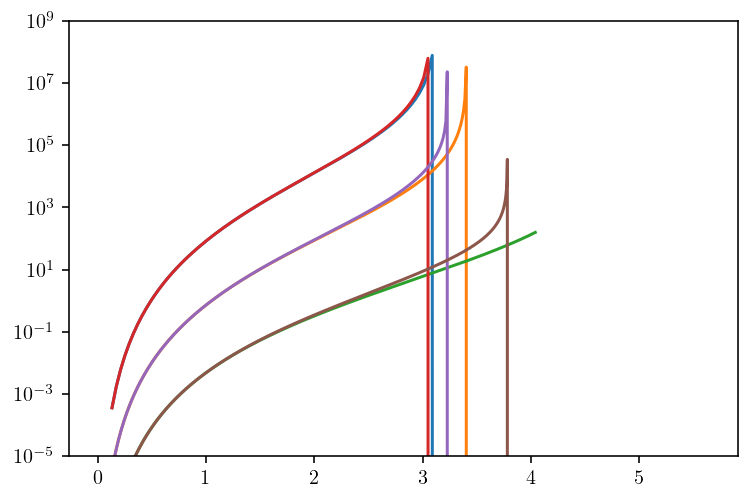

In [1750]:

plt.semilogy((1/nu12-1)/get_plsep_ov(nu12,nu12,1e-7*np.ones(3)),Tsurv(nu12,nu12,1e-7*np.ones(3),res=False))
plt.semilogy((1/nu12-1)/get_plsep_ov(nu12,nu12,1e-5*np.ones(3)),Tsurv(nu12,nu12,1e-5*np.ones(3),res=False))

plt.semilogy((1/nu12-1)/get_plsep_ov(nu12,nu12,1e-3*np.ones(3)),Tsurv(nu12,nu12,1e-3*np.ones(3),res=False))

plt.semilogy((1/nu12-1)/get_plsep_ov(nu12,nu12,1e-7*np.ones(3)),Tsurv(nu12,nu12,1e-7*np.ones(3),res=False,realLaplaceEMS=True))
plt.semilogy((1/nu12-1)/get_plsep_ov(nu12,nu12,1e-5*np.ones(3)),Tsurv(nu12,nu12,1e-5*np.ones(3),res=False,realLaplaceEMS=True))


plt.ylim(1e-5,1e9)

(1, 10000000000.0)

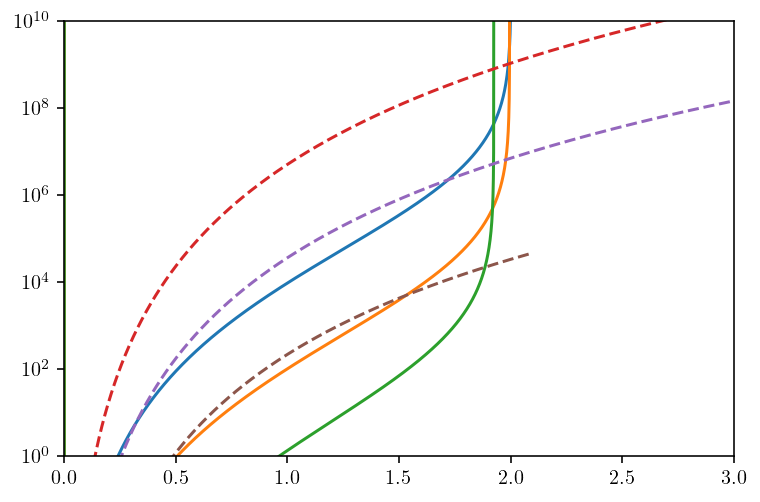

In [1846]:

plt.semilogy((1-nu12_large**(2/3))/(1e-7)**.25,np.nan_to_num(10**np.log10(st.Tsurv(nu12_large,nu12_large,1e-7*np.ones(3),res=False)),nan=1e15))
plt.semilogy((1-nu12_large**(2/3))/(1e-5)**.25,np.nan_to_num(10**np.log10(st.Tsurv(nu12_large,nu12_large,1e-5*np.ones(3),res=False)),nan=1e15))
plt.semilogy((1-nu12_large**(2/3))/(1e-3)**.25,np.nan_to_num(10**np.log10(st.Tsurv(nu12_large,nu12_large,1e-3*np.ones(3),res=False)),nan=1e15))
plt.semilogy((1-nu12_large**(2/3))/(1e-7)**.25,-1/8*(1-nu12_large**(2/3))**8*np.log((1-nu12_large**(2/3)))/(1e-7)**3,'--')
plt.semilogy((1-nu12_large**(2/3))/(1e-5)**.25,-1/8*(1-nu12_large**(2/3))**8*np.log((1-nu12_large**(2/3)))/(1e-5)**3,'--')
plt.semilogy((1-nu12_large**(2/3))/(1e-3)**.25,-1/8*(1-nu12_large**(2/3))**8*np.log((1-nu12_large**(2/3)))/(1e-3)**3,'--')



plt.xlim(0,3)
plt.ylim(1,1e10)

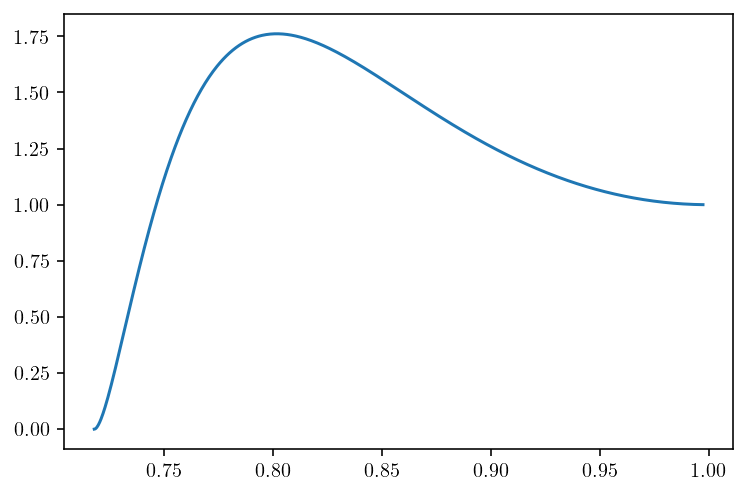

In [1847]:
plt.plot(nu12,st.Tsurv(nu12,nu12,1e-4*np.ones(3),exact_F=True)/st.Tsurv(nu12,nu12,1e-4*np.ones(3),exact_F=False))


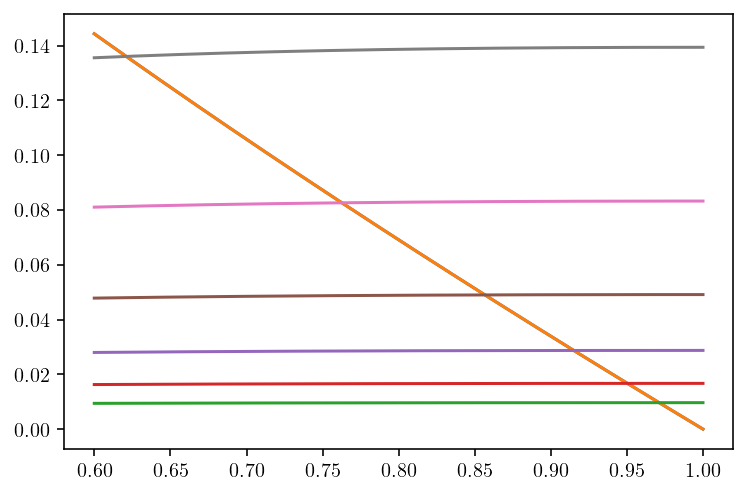

In [286]:
plsep = 1/(1/(1-nu12**(2/3))+1/(1-nu23**(2/3)))
plt.plot(nu12,plsep)
al12 = nu12**(2/3)
al23 = nu23**(2/3)
plsep = (1-al12)*(1-al23)/(2-al12-al23)
plt.plot(nu12,plsep)
for k in np.logspace(-8,-3,6):
    plt.plot(nu12,get_plsep_ov(nu12,nu23,k*np.ones(3)))


-1.224148600630396

In [82]:
plsep = 1/(1/(1-nu12**(2/3))+1/(1-nu23**(2/3)))


In [571]:
9/2**1.5/2

1.590990257669732

(-8, 12)

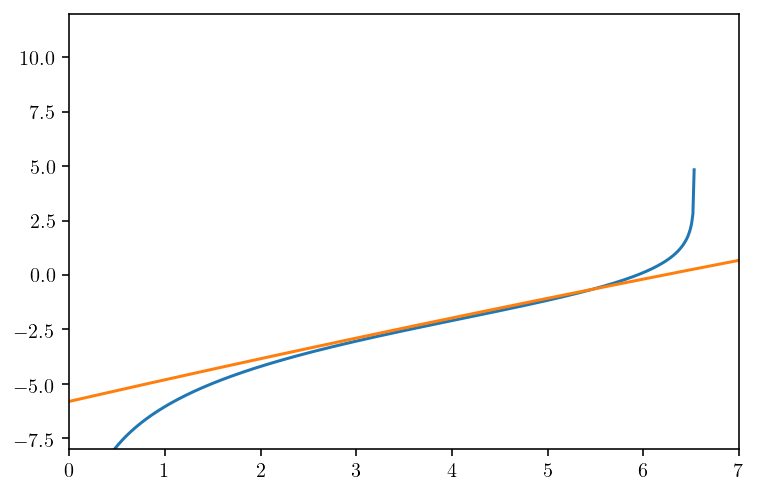

In [792]:
for k in [.3e-5]:
    plsep_ov = get_plsep_ov(nu12,nu23,k*np.ones(3))
    plt.plot((nu12**(-2/3)-1)/(2*k/3)**(1/3),np.log10(k*Tsurv(nu12,nu23,k*np.ones(3),res=False)))
    plt.plot((nu12**(-2/3)-1)/(2*k/3)**(1/3),bfun+np.log10(k*3/(32*pi*0.5)/1.1/k)+afun*plsep/plsep_ov)
    
plt.xlim(0,7)
plt.ylim(-8,12)

(0, 1)

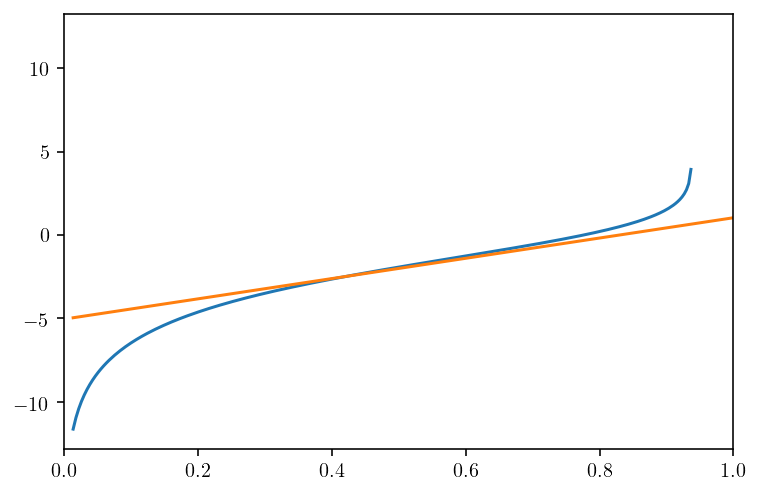

In [1690]:
m=1e-5

plt.plot(plsep/get_plsep_ov(0.8,0.8,m*np.ones(3)),np.log10(Tnorm(nu12,nu23,m*np.ones(3),)))
plt.plot(plsep/get_plsep_ov(0.8,0.8,m*np.ones(3)),bfun+afun*plsep/get_plsep_ov(0.8,0.8,m*np.ones(3)))
plt.xlim(0,1)

(0, 1)

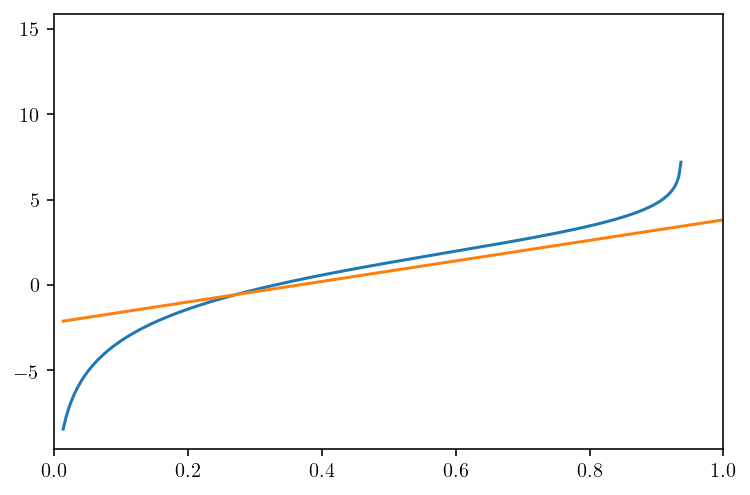

In [1697]:
m=1e-5

plt.plot(plsep/get_plsep_ov(0.8,0.8,m*np.ones(3)),np.log10(Tsurv(nu12,nu23,m*np.ones(3),res=False)))
plt.plot(plsep/get_plsep_ov(0.8,0.8,m*np.ones(3)),np.log10(3/32*nu12/2/pi/A/get_Mfac(nu12,nu12,m*np.ones(3))*2)+bfun+afun*plsep/get_plsep_ov(0.8,0.8,m*np.ones(3)))
plt.xlim(0,1)

In [1715]:
np.log10(3/32*nu12/2/pi/A).mean()+bfun

array([-7.52991616])

In [1704]:
np.log10(3/32*nu12/2/pi/A/get_Mfac(nu12,nu12,np.ones(3))*2).mean()+bfun

array([-7.31578579])

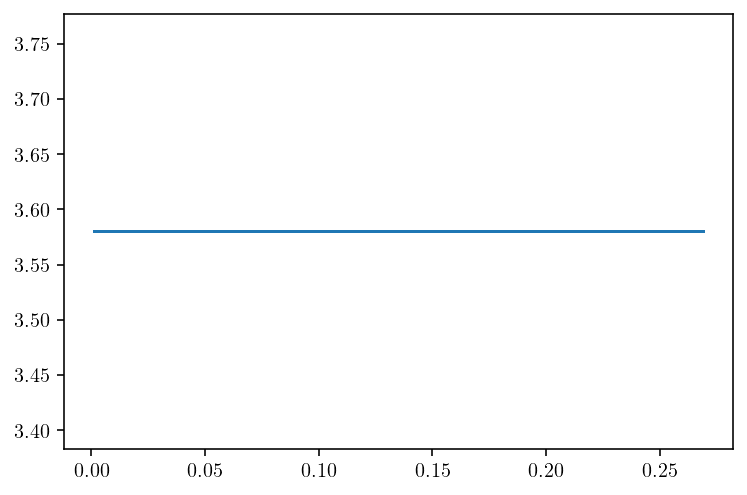

In [1713]:
plt.plot((1-nu12**(2/3)),afun*plsep/get_plsep_ov(0.8,0.8,1e-4*np.ones(3))*1e-4**.25/(1-nu12**(2/3)))

In [1617]:
bfun+np.log10(3/(32*pi*2**.5*np.sqrt(38/pi)))

array([-6.76631956])

In [1618]:
#Equal spacing time estimate
bfun+np.log10(3/(32*pi*2**.5*np.sqrt(38/pi)))-np.log10(1.5**.5*.25**.5)

array([-6.55333519])

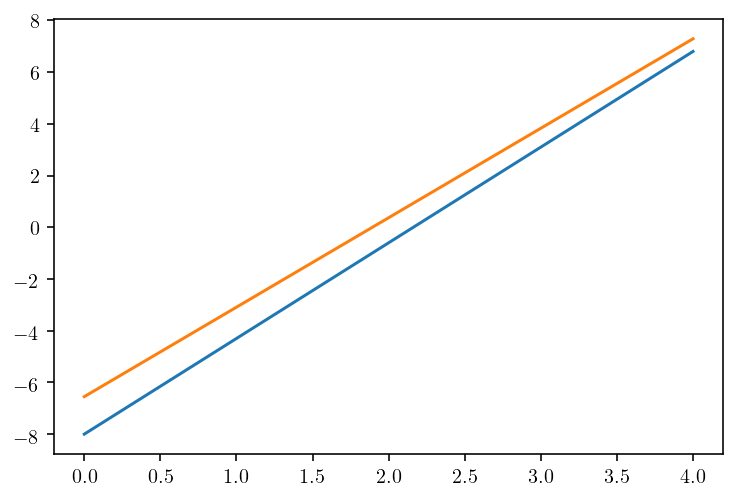

In [1619]:
Faber = np.linspace(0,4,100)
plt.plot(Faber,-8+3.7*Faber)
plt.plot(Faber,-6.55+3.46*Faber)

In [1620]:
afun/(2*1.16)

array([2.62303148])

In [30]:
p_adj = np.loadtxt('../StabilityImage/csvs/external/obertas_pratio.txt')
t_exit = np.loadtxt('../StabilityImage/csvs/external/obertas_t_exit.txt')

obset = pd.DataFrame(np.array([p_adj,t_exit]).T,columns=['prat','tinst'],)

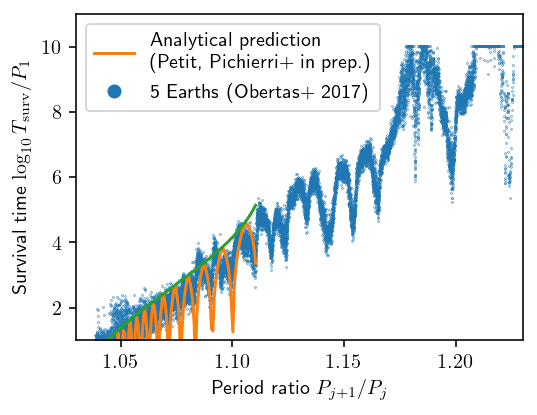

In [1717]:

fig,ax = plt.subplots(figsize=(4,3))
plt.plot(obset.prat,np.log10(obset.tinst),'.',ms=0.5,)
fudge=1.
plsep = 1/(1/(1-nu12**(2/3))+1/(1-nu23**(2/3)))
plsep_ov = get_plsep_ov(nu12,nu23,3e-6*np.ones(3))*fudge
plt.plot(1/nu12[plsep<plsep_ov],np.log10((Tsurv(nu12,nu12,3e-6*np.ones(3),fudge=fudge))[plsep<plsep_ov]),label='Analytical prediction\n (Petit, Pichierri+ in prep.)')
plt.plot(1/nu12[plsep<plsep_ov],np.log10((Tsurv(nu12,nu12,3e-6*np.ones(3),res=False,fudge=fudge))[plsep<plsep_ov]))
plt.ylim(1,11)
plt.xlabel(r'Period ratio $P_{j+1}/P_j$')
plt.ylabel(r'Survival time $\log_{10}T_{\mathrm{surv}}/P_1$')
plt.xlim(1.03,1.23)
plt.plot([0,0],ls=' ',marker='o',c='tab:blue',label="5 Earths (Obertas+ 2017)")
plt.legend(loc=2)
fig.savefig('Figures/Obertas_gabriele.pdf',bbox_inches='tight')

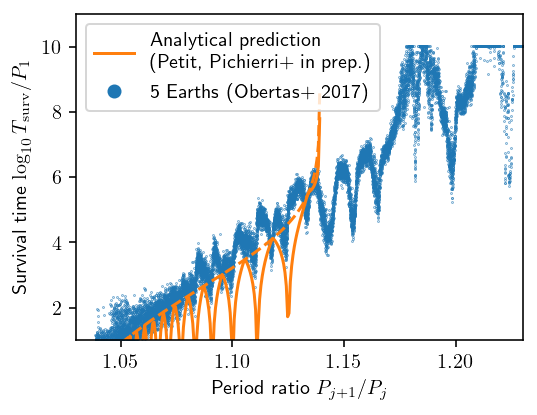

In [1764]:

fig,ax = plt.subplots(figsize=(4,3))
plt.plot(obset.prat,np.log10(obset.tinst),'.',ms=0.5,)
fudge=1
plsep = 1/(1/(1-nu12**(2/3))+1/(1-nu23**(2/3)))
plsep_ov = get_plsep_ov(nu12,nu23,3e-6*np.ones(3))*fudge
plt.plot(1/nu12,np.log10((st.Tsurv(nu12,nu12,3e-6*np.ones(3),fudge=fudge))),label='Analytical prediction\n (Petit, Pichierri+ in prep.)')
plt.plot(1/nu12,np.log10((st.Tsurv(nu12,nu12,3e-6*np.ones(3),res=False,fudge=fudge))),'--',c='tab:orange')
plt.ylim(1,11)
plt.xlabel(r'Period ratio $P_{j+1}/P_j$')
plt.ylabel(r'Survival time $\log_{10}T_{\mathrm{surv}}/P_1$')
plt.xlim(1.03,1.23)
plt.plot([0,0],ls=' ',marker='o',c='tab:blue',label="5 Earths (Obertas+ 2017)")
plt.legend(loc=2)
fig.savefig('Figures/Obertas_gabrielev2.pdf',bbox_inches='tight')

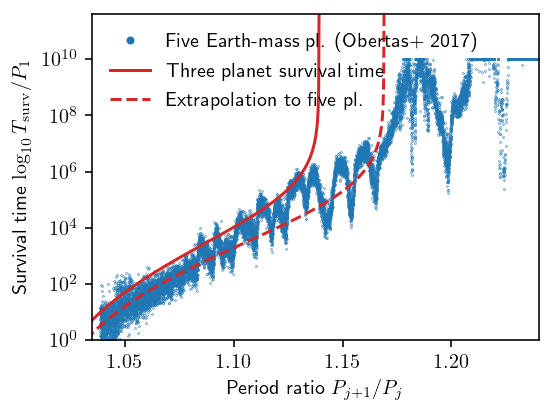

In [41]:

fig,ax = plt.subplots(figsize=(4,3))
plt.plot(obset.prat,(obset.tinst),'.',ms=0.5,rasterized=True)
plt.plot([0,0],ls=' ',marker='o',ms=3,c='tab:blue',label="Five Earth-mass pl. (Obertas+ 2017)")
fudge=2.
plsep = 1/(1/(1-nu12**(2/3))+1/(1-nu23**(2/3)))
plsep_ov = st.get_plsep_ov(nu12,nu23,3e-6*np.ones(3))*fudge
#plt.plot(1/nu12,np.log10((st.Tsurv(nu12,nu12,3e-6*np.ones(3),fudge=fudge))),label='Analytical prediction\n (Petit, Pichierri+ in prep.)')
plt.semilogy(1/nu12,10**(np.nan_to_num(np.log10((st.Tsurv(nu12,nu12,3e-6*np.ones(3),res=False,fudge=1))),nan=13)),
             c='tab:red',label="  Three planet survival time")
plt.semilogy(1/nu12,10**(np.nan_to_num(np.log10((st.Tsurv(nu12,nu12,3e-6*np.ones(3),res=False,fudge=fudge))),nan=13)),
             c='tab:red',ls='--',label="  Extrapolation to five pl.")
plt.ylim(1,4e11)
plt.xlabel(r'Period ratio $P_{j+1}/P_j$')
plt.ylabel(r'Survival time $\log_{10}T_{\mathrm{surv}}/P_1$')
plt.xlim(1.035,1.24)


plt.legend(loc=2,framealpha=0)
fig.savefig('../Paper/Figures/Obertas_comp.pdf',bbox_inches='tight',dpi=300)

(-8, 10.676136174522604)

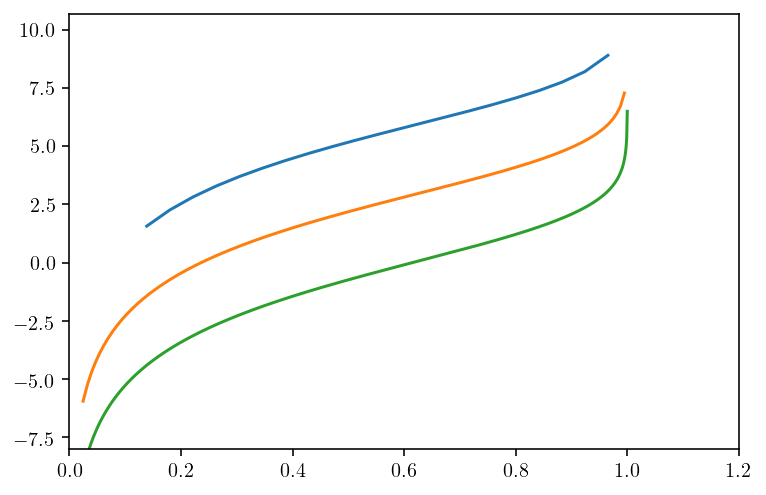

In [1821]:
for k in np.logspace(-9,-3,3):
    plsep_ov = get_plsep_ov(nu12,nu23,k*np.ones(3))
    #plt.plot(plsep/plsep_ov,np.log10(Tsurv(nu12,nu23,k*np.ones(3),res=False,exact_F=False)))
    plt.plot(plsep/plsep_ov,np.log10(Tsurv(nu12,nu23,k*np.ones(3),res=False,exact_F=True)))
#plt.plot(plsep/plsep_ov,np.log10(27/16*1*plsep**2/plsep_ov**4*(1/(1-(plsep/plsep_ov)**4))))
plt.xlim(0,1.2)
plt.ylim(-8)

In [721]:
del_inf

array([0.62871293])

(-8, 4.8750360115337505)

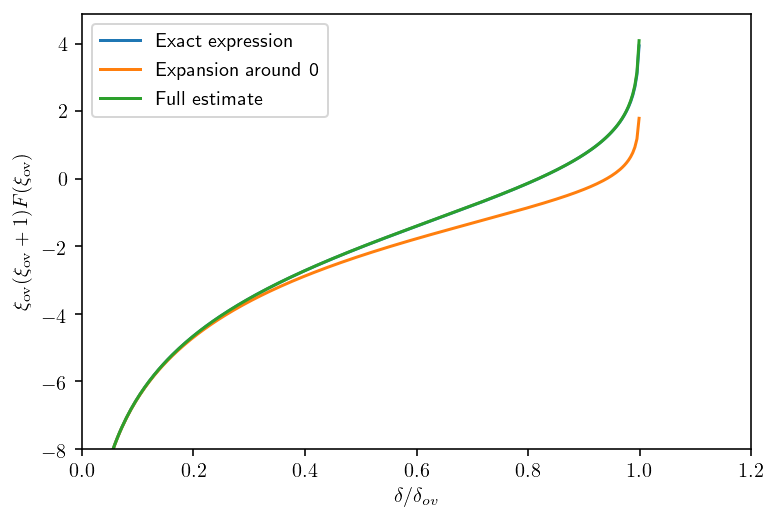

In [1867]:
k=1e-5
plsep_ov = get_plsep_ov(nu12,nu23,k*np.ones(3))
plt.plot(plsep/plsep_ov,np.log10(Tnorm(nu12,nu23,k*np.ones(3),exact_F=True)),label = 'Exact expression')
plt.plot(plsep/plsep_ov,np.log10(2**1.5/9*(plsep/plsep_ov)**6/(1-(plsep/plsep_ov)**4)),label='Initial estimate')
plt.plot(plsep/plsep_ov,np.log10(2**1.5/9*(plsep/plsep_ov)**6/(1-(plsep/plsep_ov)**4))+np.sqrt(-np.log(1-(plsep/plsep_ov)**4)),label='Full estimate')
plt.xlim(0,1.2)
plt.ylabel('log Normalized survival time')
plt.xlabel('$\delta/\delta_{ov}$')
plt.legend()
plt.ylim(-8)

(-1, 0.26906128050077627)

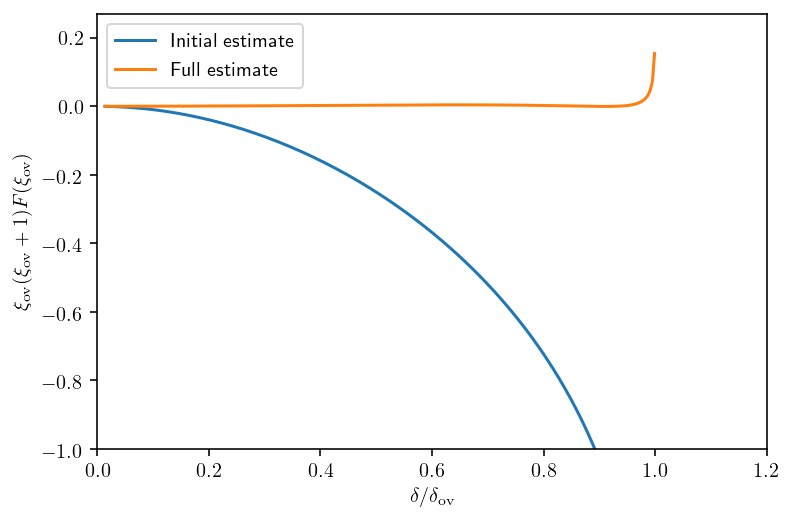

In [1868]:
k=1e-5
plsep_ov = get_plsep_ov(nu12,nu23,k*np.ones(3))
#plt.plot(plsep/plsep_ov,np.log10(Tnorm(nu12,nu23,k*np.ones(3),exact_F=True)),label = 'Exact expression')
plt.plot(plsep/plsep_ov,np.log10(2**1.5/9*(plsep/plsep_ov)**6/(1-(plsep/plsep_ov)**4))-np.log10(Tnorm(nu12,nu23,k*np.ones(3),exact_F=True)),label='Initial estimate')
plt.plot(plsep/plsep_ov,np.log10(2**1.5/9*(plsep/plsep_ov)**6/(1-(plsep/plsep_ov)**4))+np.sqrt(-np.log(1-(plsep/plsep_ov)**4))-np.log10(Tnorm(nu12,nu23,k*np.ones(3),exact_F=True)),label='Full estimate')
plt.xlim(0,1.2)
plt.ylabel(r'$\xi_{\mathrm{ov}}(\xi_{\mathrm{ov}}+1)F(\xi_{\mathrm{ov}})$')
plt.xlabel(r'$\delta/\delta_{\mathrm{ov}}$')
plt.legend()
plt.ylim(-1)

(-8, 5)

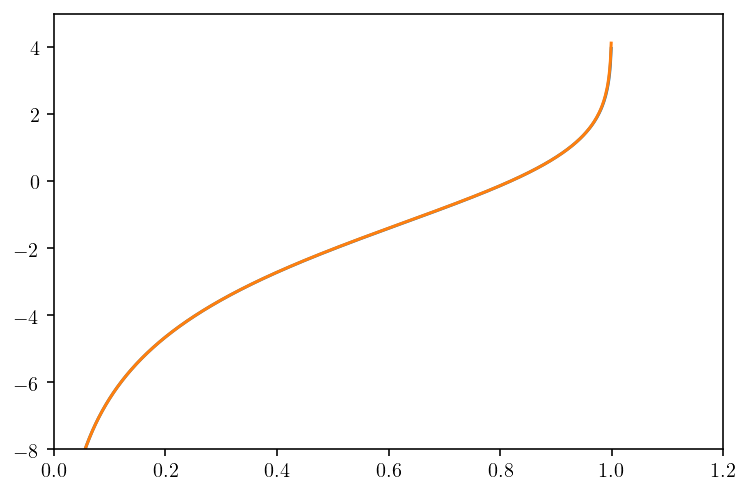

In [494]:
k=1e-5
plsep_ov = get_plsep_ov(nu12,nu23,k*np.ones(3))
plt.plot(plsep/plsep_ov,np.log10(Tnorm(nu12,nu23,k*np.ones(3),exact_F=True)))
plt.plot(plsep/plsep_ov,np.log10(2**1.5/9*(plsep/plsep_ov)**6/(1-(plsep/plsep_ov)**4))+np.sqrt(-np.log(1-(plsep/plsep_ov)**4)))
#plt.plot(plsep/plsep_ov,)
plt.xlim(0,1.2)
plt.ylim(-8,5)

In [688]:
dr = np.linspace(0,1,10000)
xiov = -1-sc.special.lambertw((-1+dr**4)/np.exp(1),-1).real
F = (1-sc.special.dawsn((xiov/2)**.5)/(xiov/2)**.5)**2
Tnorm_num = xiov*(xiov+1)/(1-dr**4)*F

miracleTnorm = dr**6/(1-dr**4)*10**(np.sqrt(-np.log(1-dr**4)))

array([1.62081857])

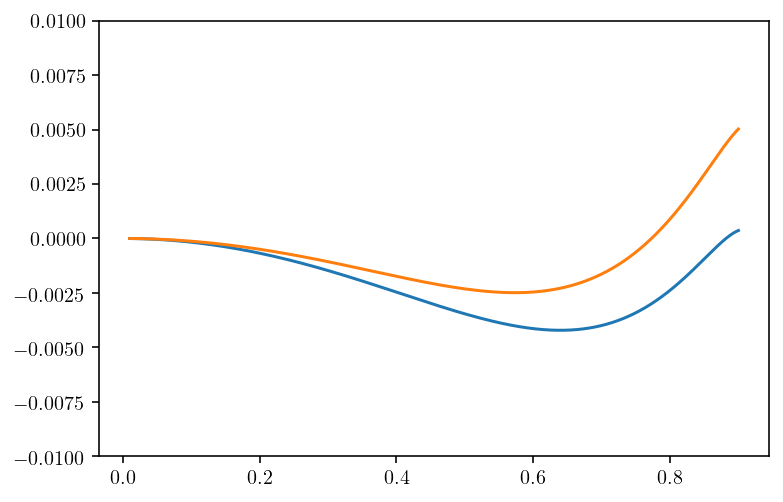

In [1852]:
dr = np.linspace(0,1,10000)[100:-1000]
xiov = -1-sc.special.lambertw((-1+dr**4)/np.exp(1),-1).real
F = (1-sc.special.dawsn((xiov/2)**.5)/(xiov/2)**.5)**2
sTnorm = xiov*(xiov+1)*F
smTnorm = 2*2**.5/9*dr**6*10**(np.sqrt(-np.log(1-dr**4)))
def approx(b):
    smTnorm = 2*2**.5/9*dr**6*np.exp(b*np.sqrt(-2*np.log(1-dr**4)))
    return np.log10(sTnorm/smTnorm)
sapprbest = optimize.least_squares(approx,1.6)
plt.plot(dr,np.log10(sTnorm/smTnorm))
plt.plot(dr,sapprbest.fun)
plt.ylim(-.01,.01)
sapprbest.x

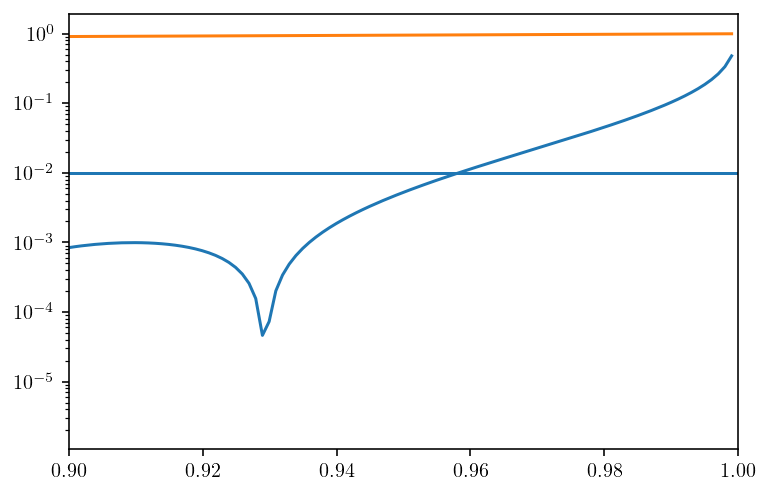

In [1889]:
dr = np.linspace(0,1,1000)[10:]
xiov = -1-sc.special.lambertw((-1+dr**4)/np.exp(1),-1).real
F = (1-sc.special.dawsn((xiov/2)**.5)/(xiov/2)**.5)**2
sTnorm = xiov*(xiov+1)*F
smTnorm = 2*2**.5/9*dr**6*10**(np.sqrt(-np.log(1-dr**4)))
plt.xlim(0.9,1)
plt.axhline(1e-2)
plt.semilogy(dr,abs(-(sTnorm-smTnorm)/sTnorm))
plt.semilogy(dr,abs(-(sTnorm-2*2**.5/9*dr**6)/sTnorm))

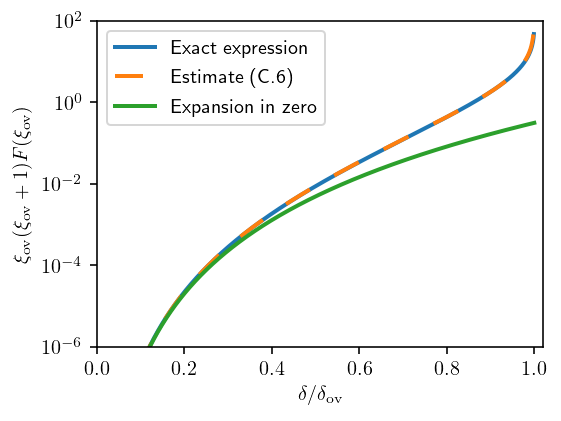

In [28]:
fig,ax=plt.subplots(figsize=(4,3))

dr = np.linspace(0,1,1000)[10:]
xiov = -1-sc.special.lambertw((-1+dr**4)/np.exp(1),-1).real
F = (1-sc.special.dawsn((xiov/2)**.5)/(xiov/2)**.5)**2
sTnorm = xiov*(xiov+1)*F
smTnorm = 2*2**.5/9*dr**6*10**(np.sqrt(-np.log(1-dr**4)))

plt.semilogy(dr,sTnorm,label='Exact expression',lw=2)
plt.semilogy(dr,smTnorm,'--',label='Estimate (C.6)',dashes=(7, 7),lw=2)
plt.semilogy(dr,2*2**.5/9*dr**6,label='Expansion in zero',lw=2)
plt.xlim(0,1.02)
plt.ylim(1e-6,1e2)
plt.legend()
plt.ylabel(r'$\xi_{\mathrm{ov}}(\xi_{\mathrm{ov}}+1)F(\xi_{\mathrm{ov}})$')
plt.xlabel(r'$\delta/\delta_{\mathrm{ov}}$')
fig.savefig('../Paper/Figures/normDiffestimate.pdf')

(-8, 8.320614232589307)

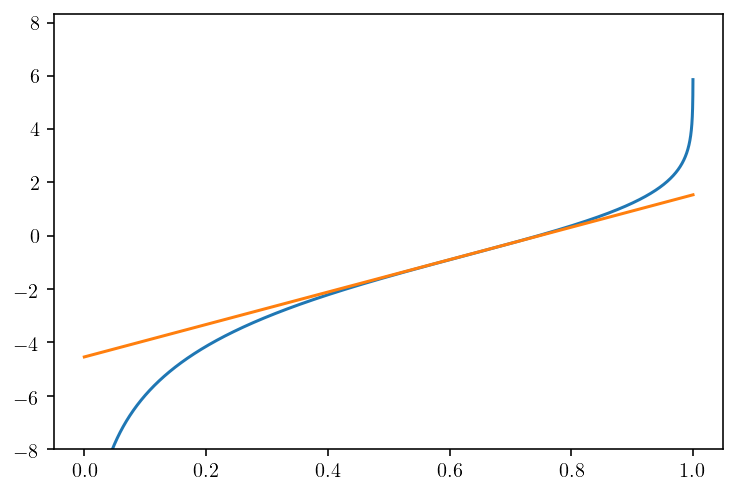

In [690]:
plt.plot(dr,np.log10(Tnorm_num*9/2**1.5))
plt.plot(dr,bfun+afun*dr)
plt.ylim(-8)

ValueError: operands could not be broadcast together with shapes (1000,) (1999,) 

In [1632]:
nu,eta = nus_to_nu_eta(nu12,nu23)
al12 = nu12**(2/3)
plsep = (1-al12)/2


array([0.58533145, 0.58533144, 0.58533142, 0.5853314 , 0.58533137,
       0.58533134, 0.58533131, 0.58533127, 0.58533123, 0.58533118,
       0.58533113, 0.58533108, 0.58533102, 0.58533096, 0.58533089,
       0.58533082, 0.58533075, 0.58533067, 0.58533059, 0.58533051,
       0.58533042, 0.58533032, 0.58533023, 0.58533013, 0.58533002,
       0.58532992, 0.5853298 , 0.58532969, 0.58532957, 0.58532944,
       0.58532932, 0.58532918, 0.58532905, 0.58532891, 0.58532877,
       0.58532862, 0.58532847, 0.58532831, 0.58532816, 0.58532799,
       0.58532783, 0.58532766, 0.58532748, 0.5853273 , 0.58532712,
       0.58532694, 0.58532675, 0.58532655, 0.58532636, 0.58532615,
       0.58532595, 0.58532574, 0.58532553, 0.58532531, 0.58532509,
       0.58532486, 0.58532464, 0.5853244 , 0.58532417, 0.58532393,
       0.58532368, 0.58532344, 0.58532318, 0.58532293, 0.58532267,
       0.5853224 , 0.58532214, 0.58532187, 0.58532159, 0.58532131,
       0.58532103, 0.58532074, 0.58532045, 0.58532016, 0.58531

In [1639]:
(afun*plsep/get_plsep_ov(nu12,nu23,np.ones(3))/(1-al12)).mean()

3.55797242783826

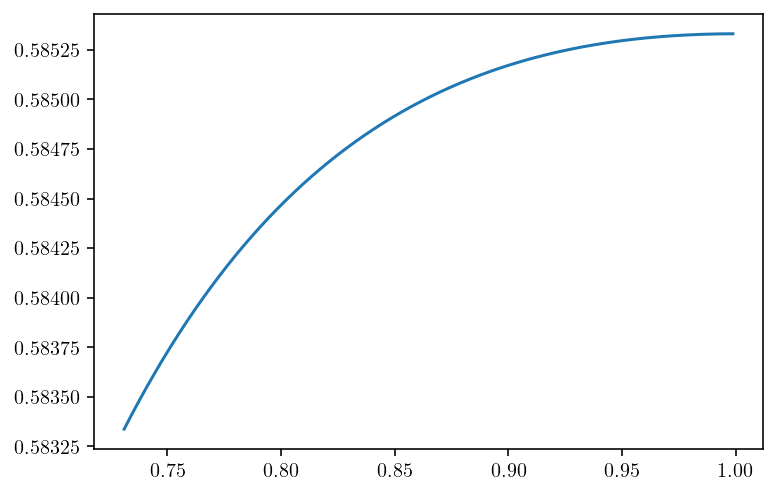

In [1637]:
plt.plot(al12,plsep/get_plsep_ov(nu12,nu23,1e-4*np.ones(3))/(1-al12)/10)

AttributeError: 'list' object has no attribute 'mean'

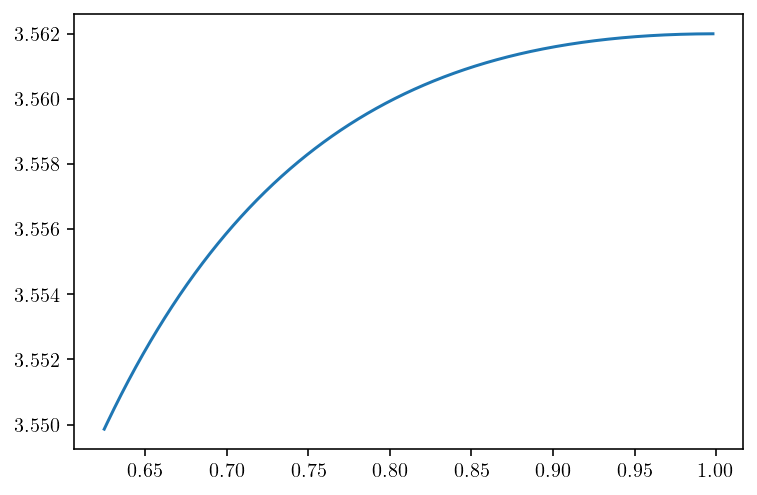

In [1638]:
plt.plot(nu12,(afun*plsep/get_plsep_ov(nu12,nu23,np.ones(3))/(1-al12)))
plt.xlim(0.5,1)

In [1623]:
(afun/2/1.16)

array([2.62303148])

In [784]:
(bfun+np.log10(3/(32*pi)) -np.log10(get_Mfac(nu12,nu23,np.ones(3))*np.sqrt(nus_to_eta(nu12,nu23)*(1-nus_to_eta(nu12,nu23))*getLogpart(plsep,nus_to_eta(nu12,nu23))))).mean()

-6.326667662821527

In [777]:
get_Mfac(nu12,nu23,np.ones(3))*np.sqrt(nus_to_eta(nu12,nu23)*(1-nus_to_eta(nu12,nu23))*getLogpart(plsep,nus_to_eta(nu12,nu23)))

array([1.14946182, 1.14992671, 1.15039167, ..., 5.36842108, 5.61827625,
       6.045098  ])

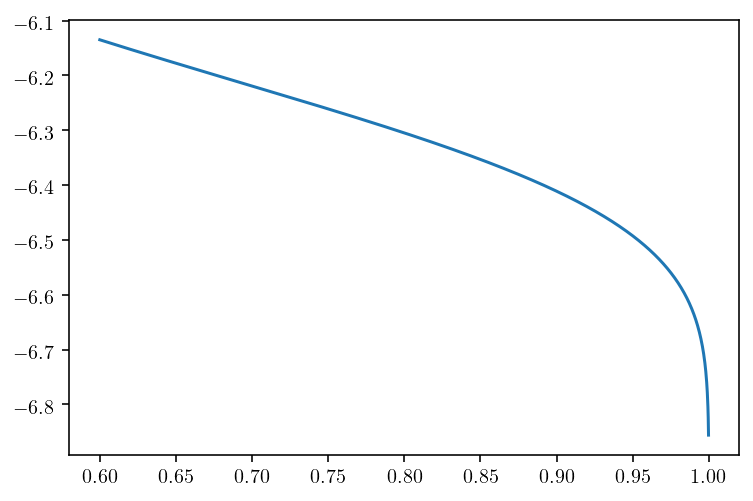

In [787]:
plt.plot(nu12,bfun+np.log10(3/(32*pi)) -np.log10(get_Mfac(nu12,nu23,np.ones(3))*np.sqrt(nus_to_eta(nu12,nu23)*(1-nus_to_eta(nu12,nu23))*getLogpart(plsep,nus_to_eta(nu12,nu23)))))

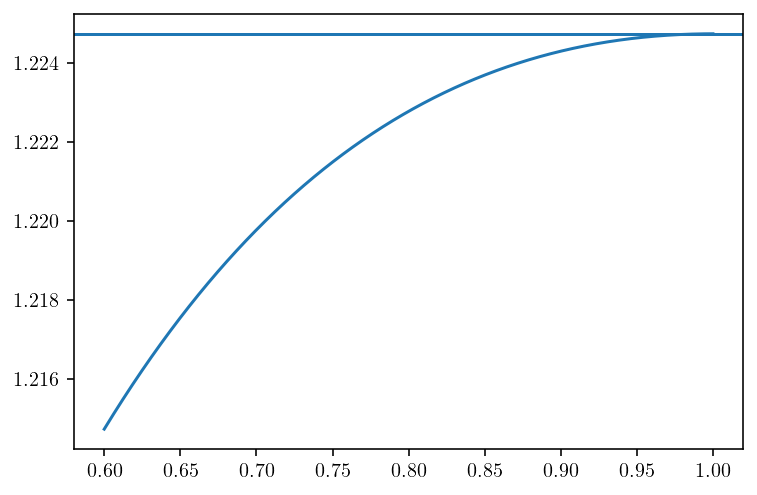

In [778]:
plt.plot(nu12,get_Mfac(nu12,nu23,np.ones(3)))
plt.axhline(1.5**.5)

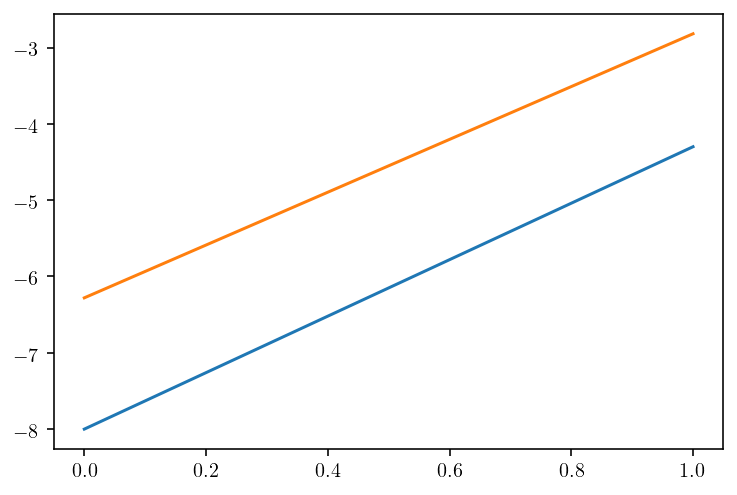

In [785]:
plt.plot(dr,-8+3.7*dr)
plt.plot(dr,-6.28+3.46*dr)

## Inflexion point nice estmiate

In [608]:
import sympy as sy
sydel = sy.Symbol('\delta_r')

In [1673]:
syTnormapprox = sy.log(2*sy.sqrt(2)/9*sydel**6/(1-sydel**4)*10**(sy.sqrt(-sy.log(1-sydel**4))))/sy.log(10)
syTnormapprox

log(2*10**(sqrt(-log(1 - \delta_r**4)))*sqrt(2)*\delta_r**6/(9*(1 - \delta_r**4)))/log(10)

In [1674]:
syTnormapprox.diff().diff()

9*10**(-sqrt(-log(1 - \delta_r**4)))*sqrt(2)*sqrt(-log(1 - \delta_r**4))*(-4*10**(sqrt(-log(1 - \delta_r**4)))*sqrt(2)*\delta_r**9*sqrt(-log(1 - \delta_r**4))*log(10)/(9*(1 - \delta_r**4)**2*log(1 - \delta_r**4)) + 8*10**(sqrt(-log(1 - \delta_r**4)))*sqrt(2)*\delta_r**9/(9*(1 - \delta_r**4)**2) + 4*10**(sqrt(-log(1 - \delta_r**4)))*sqrt(2)*\delta_r**5/(3*(1 - \delta_r**4)))/(2*\delta_r**3*log(1 - \delta_r**4)) - 9*10**(-sqrt(-log(1 - \delta_r**4)))*sqrt(2)*(-4*10**(sqrt(-log(1 - \delta_r**4)))*sqrt(2)*\delta_r**9*sqrt(-log(1 - \delta_r**4))*log(10)/(9*(1 - \delta_r**4)**2*log(1 - \delta_r**4)) + 8*10**(sqrt(-log(1 - \delta_r**4)))*sqrt(2)*\delta_r**9/(9*(1 - \delta_r**4)**2) + 4*10**(sqrt(-log(1 - \delta_r**4)))*sqrt(2)*\delta_r**5/(3*(1 - \delta_r**4)))/(\delta_r**3*log(10)) + 9*10**(-sqrt(-log(1 - \delta_r**4)))*sqrt(2)*(1 - \delta_r**4)*(-16*10**(sqrt(-log(1 - \delta_r**4)))*sqrt(2)*\delta_r**12*sqrt(-log(1 - \delta_r**4))*log(10)/(3*(1 - \delta_r**4)**3*log(1 - \delta_r**4)) - 8*10

In [1675]:
funTnorm = sy.lambdify(sydel,syTnormapprox)
fundTnorm = sy.lambdify(sydel,syTnormapprox.diff())
funddTnorm = sy.lambdify(sydel,syTnormapprox.diff().diff())

In [1676]:
del_inf = optimize.fsolve(funddTnorm,0.6)

In [1677]:
del_inf

array([0.62871293])

In [1678]:
afun = fundTnorm(del_inf)
print(afun)

[6.08543303]


In [1679]:
bfun = funTnorm(del_inf)-del_inf*fundTnorm(del_inf)
print(bfun)

[-5.05200662]


In [1680]:
funTnorm(del_inf)

array([-1.22601617])

In [1681]:
np.log(27/32/4*(2/3)**.5*np.sqrt(pi/38)/pi)

-4.150083974757263

(-10, 10)

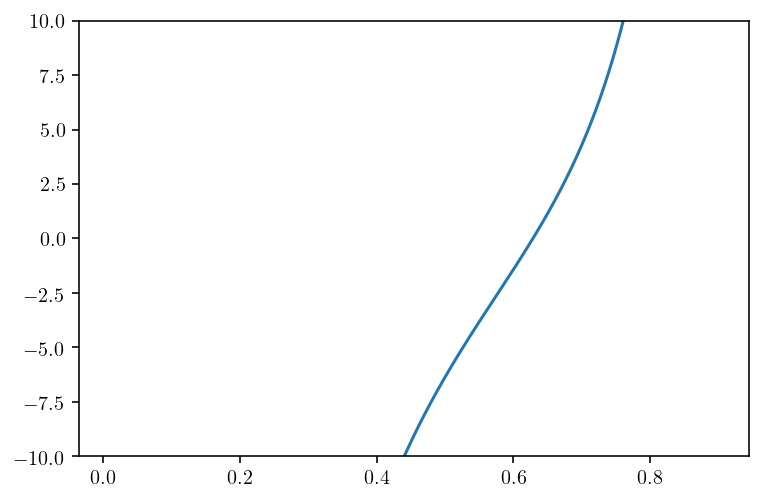

In [625]:
plt.plot(dr,funddTnorm(dr))
plt.ylim(-10,10)

## Generalized period ratio $\nu$

In [192]:
import sympy as sy

In [193]:
nu,nu12,nu23,eta = sy.symbols(r'\nu,\nu_{12},\nu_{23},\eta')

In [194]:
nuexpr = 1/(1/(1/nu12-1)+1/(1-nu23))

etaexpr = (1-nu23)/(1/nu12-nu23)

In [998]:
sy.solve(nuexpr-nu,nu23)[0]

(\nu + \nu_{12} - 1)/(\nu*\nu_{12} + \nu_{12} - 1)

In [999]:
sy.simplify(nuexpr)

(-\nu_{12}*\nu_{23} + \nu_{12} + \nu_{23} - 1)/(\nu_{12}*\nu_{23} - 1)

In [975]:
sy.simplify(etaexpr)

\nu_{12}*(\nu_{23} - 1)/(\nu_{12}*\nu_{23} - 1)

In [1044]:
sy.simplify(etaexpr+nu12*nu23*(1-etaexpr))

\nu_{12}

In [972]:
sy.solve([nuexpr-nu,etaexpr-eta],[nu12,nu23])[0][0]

\eta/(\eta + \nu)

In [973]:
sy.solve(sy.solve([nuexpr-nu,etaexpr-eta],[nu12,nu23])[0][1]

(\eta + \nu - 1)/(\eta - 1)

In [1007]:
sy.simplify(sy.simplify(etaexpr.diff(nu12))**2+sy.simplify((etaexpr.diff(nu23)))**2)

(\nu_{12}**2*(-\nu_{12}*\nu_{23} + \nu_{12}*(\nu_{23} - 1) + 1)**2 + (\nu_{23} - 1)**2)/(\nu_{12}*\nu_{23} - 1)**4

In [1054]:
deta1 = sy.simplify(etaexpr.diff(nu12))
deta2 = sy.simplify(etaexpr.diff(nu23))
deta2=sy.expand(deta2.as_numer_denom()[0])/deta2.as_numer_denom()[1]

In [1055]:
deta1

(1 - \nu_{23})/(\nu_{12}*\nu_{23} - 1)**2

In [1056]:
deta2

(\nu_{12}**2 - \nu_{12})/(\nu_{12}*\nu_{23} - 1)**2

(\nu_{12}**2 - \nu_{12})/(\nu_{12}*\nu_{23} - 1)**2

In [1045]:
dnu1 = sy.simplify(nuexpr.diff(nu12))
dnu2 = sy.simplify(nuexpr.diff(nu23))

In [1046]:
dnu1

-(\nu_{23} - 1)**2/(\nu_{12}*\nu_{23} - 1)**2

In [1047]:
dnu2

-(\nu_{12} - 1)**2/(\nu_{12}*\nu_{23} - 1)**2

In [1059]:
sy.simplify(nuexpr)

(-\nu_{12}*\nu_{23} + \nu_{12} + \nu_{23} - 1)/(\nu_{12}*\nu_{23} - 1)

In [1057]:
sy.simplify(deta1*dnu1+deta2*dnu2)

(\nu_{12}*(1 - \nu_{12})**3 + (\nu_{23} - 1)**3)/(\nu_{12}*\nu_{23} - 1)**4

In [1069]:
nueq,dnueq = sy.symbols(r'\nu_{eq},\delta\nu_{eq}')

In [1070]:
etaeq = etaexpr.replace(nu12,1-dnueq).replace(nu23,1-dnueq)

In [1094]:
sy.series(etaeq**2/(1-dnueq)**sy.Rational(4,3))

1/4 + \delta\nu_{eq}/12 - \delta\nu_{eq}**2/144 - 13*\delta\nu_{eq}**3/324 - 709*\delta\nu_{eq}**4/15552 - 1883*\delta\nu_{eq}**5/46656 + O(\delta\nu_{eq}**6)

In [1098]:
sy.series(sy.sqrt(1+etaeq**2/(1-dnueq)**sy.Rational(4,3)+(1-etaeq)**2*(1-dnueq)**sy.Rational(4,3))*(etaeq*(1-etaeq))**sy.Rational(3,2))

sqrt(6)/16 - 11*sqrt(6)*\delta\nu_{eq}**2/432 - 11*sqrt(6)*\delta\nu_{eq}**3/432 - 3163*sqrt(6)*\delta\nu_{eq}**4/186624 - 787*sqrt(6)*\delta\nu_{eq}**5/93312 + O(\delta\nu_{eq}**6)

In [1074]:
sy.series(sy.simplify(etaeq*(1-etaeq))**sy.Rational(3,2),dnueq)

1/8 - 3*\delta\nu_{eq}**2/64 - 3*\delta\nu_{eq}**3/64 - 33*\delta\nu_{eq}**4/1024 - 9*\delta\nu_{eq}**5/512 + O(\delta\nu_{eq}**6)

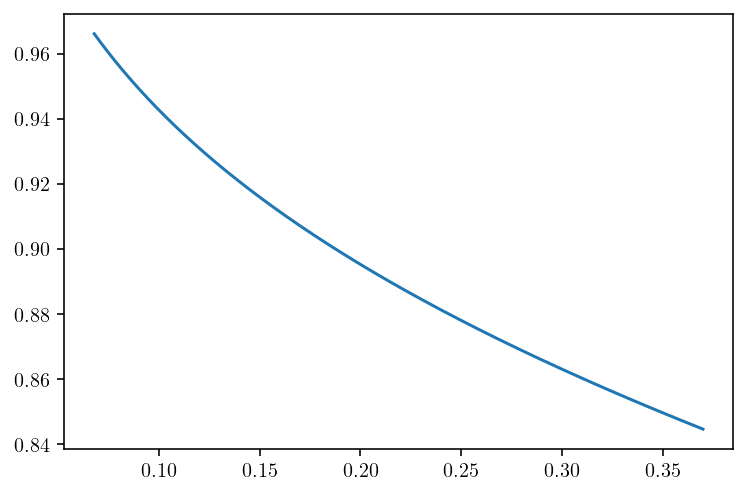

In [1116]:
nogendeq = np.linspace(1-(0.90)**(2/3),1-(0.5)**(2/3),1000)
deq = nogendeq/2
plt.plot(nogendeq,((2*np.log(1/deq)+np.log(1/deq)**2)/24)**(1/8))

In [219]:
sy.simplify(nu12**3*(1-etaexpr)-etaexpr*nu23)

\nu_{12}*(\nu_{12}**3 - \nu_{12}**2 - \nu_{23}**2 + \nu_{23})/(\nu_{12}*\nu_{23} - 1)

In [200]:
sy.simplify(sy.expand(sy.simplify((1-etaexpr)*etaexpr).as_numer_denom()[0]))

\nu_{12}*(\nu_{12}*\nu_{23} - \nu_{12} - \nu_{23} + 1)

In [1100]:
2**(-3/8)*3**(-1/8)

0.6721614402841942

# Pichierri 2020  

Text(0, 0.5, '$k^{-2}\\left(1-\\frac{1}{k}\\right)^{N-3}$')

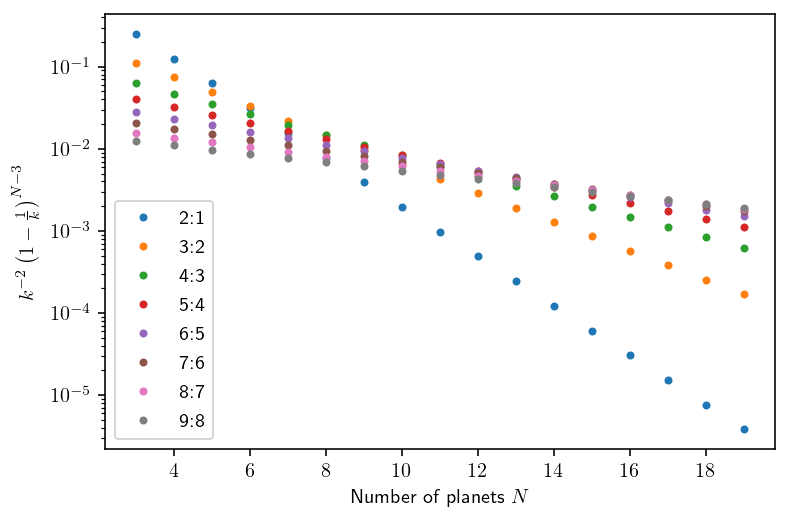

In [487]:
ks=np.arange(2,10)
Ns=np.arange(3,20)
#plt.axhline((2*1.28e-3)**(1/2))
for k in ks:
    plt.semilogy(Ns,1/k**2*(1.-1/k)**(Ns-3),'.',label=f'{k}:{k-1}')
plt.legend()
plt.xlabel(r'Number of planets $N$')
plt.ylabel(r'$k^{-2}\left(1-\frac{1}{k}\right)^{N-3}$')

Text(0, 0.5, 'Order of magnitude of max planet mass')

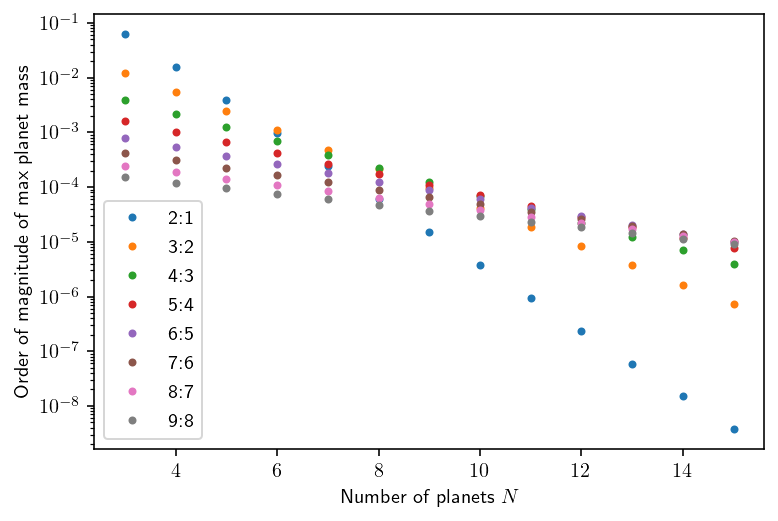

In [486]:
ks=np.arange(2,10)
Ns=np.arange(3,16)
plt.axhline((1-1.46))

for k in ks:
    plt.semilogy(Ns,(1/k**2*(1.-1/k)**(Ns-3))**2,'.',label=f'{k}:{k-1}')
plt.legend()
plt.xlabel(r'Number of planets $N$ in chain')
plt.ylabel(r'Order of magnitude of max planet mass')